In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

import snntorch as snn
from snntorch import spikegen, utils, surrogate
from snntorch.functional import quant

import brevitas.nn as qnn
# from brevitas.nn import QuantConv1d, QuantIdentity, QuantLinear, BatchNorm1dToQuantScaleBias
from brevitas.quant import Int8WeightPerTensorFloat, Int8ActPerTensorFloat, Int32Bias
from brevitas.export import export_qonnx
from brevitas.core.scaling      import ScalingImplType
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.quant        import QuantType


from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
#from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

import optuna

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import csv, copy, glob
import imblearn, imblearn.over_sampling
from collections import Counter, OrderedDict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize, normalize
from scipy.signal import butter, lfilter, freqz

import os, sys, time, datetime, argparse, json


/home/velox-217533/anaconda3/envs/fau_snn_torch-cuda/lib/python3.12/site-packages/brevitas/graph/equalize.py:69: UserWarning: fast_hadamard_transform package not found, using standard pytorch kernels
  warnings.warn("fast_hadamard_transform package not found, using standard pytorch kernels")
/home/velox-217533/anaconda3/envs/fau_snn_torch-cuda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
# random.seed(seed)
torch.cuda.manual_seed_all(seed) # for multi-GPU setups

In [3]:
def load_train_test_data(
    mitbih_train_path='/home/velox-217533/Projects/fau_projects/research/data/mitbih_processed_intra_patient_4class_180_center90_filtered/train',
    folders=None, random_state=42,
    max_files_per_folder=None
):
    if folders is None:
        folders = ['normal', 'sveb', 'veb', 'f']
    label_mapping = {'normal': 0, 'sveb': 1, 'veb': 2, 'f': 3}
    
    def scan_folder(base_path):
        X_parts, y_parts = [], []
        expected_cols = None
    
        for folder in folders:
            folder_path = os.path.join(base_path, folder)
            csvs = sorted(
                glob.glob(os.path.join(folder_path, '*.csv')) +
                glob.glob(os.path.join(folder_path, '*.CSV'))
            )
            if not csvs:
                print(f'Warning: no CSVs found in: {folder_path}')
                continue
    
            for fpath in csvs:
                df = pd.read_csv(
                    fpath, dtype=np.float32, engine='c',
                    usecols=lambda c: c != 'Unnamed: 0'
                )
                if df.shape[0] == 0:
                    df = pd.read_csv(fpath, header=None, dtype=np.float32, engine='c')
    
                df = df.dropna(axis=1, how='all')
    
                arr = df.to_numpy(copy=False)
                if expected_cols is None:
                    expected_cols = arr.shape[1]
                elif arr.shape[1] != expected_cols:
                    raise ValueError(
                        f'Inconsistent column count: {fpath} has {arr.shape[1]}, expected {expected_cols}'
                    )
    
                X_parts.append(arr)
                y_parts.extend([label_mapping[folder]] * arr.shape[0])
    
        if not X_parts:
            raise FileNotFoundError(f'No usable CSV rows under {base_path} (folders={folders})')
    
        X = np.vstack(X_parts).astype(np.float32, copy=False)
        y = np.asarray(y_parts, dtype=np.int64)
        return X, y
    
    # Load and shuffle
    X_mit, y_mit = scan_folder(mitbih_train_path)
    print(f'Loaded: MIT-BIH {X_mit.shape}')
    
    rng = np.random.RandomState(random_state)
    perm = rng.permutation(len(y_mit))
    X = X_mit[perm]
    y = y_mit[perm]
    
    # OPTION 3: NO SCALING - data already z-score normalized from preprocessing
    # Data will have mean≈0, std≈1, range≈[-3, 3]
    print(f"Data range after z-score normalization: [{X.min():.2f}, {X.max():.2f}]")
    print(f"Data mean: {X.mean():.4f}, std: {X.std():.4f}")
    
    # Handle any NaNs just in case
    X = np.nan_to_num(X, nan=0.0).astype(np.float32, copy=False)
    
    # Convert to torch tensors
    X_train_tensor = torch.from_numpy(X).unsqueeze(1)   # (N, 1, L)
    y_train = torch.from_numpy(y)                       # (N,)
    
    print("Class distribution:", Counter(y_train.tolist()))
    print("X train shape:", tuple(X_train_tensor.shape))
    print("y_train shape:", tuple(y_train.shape))
    print("Data tensor loaded successfully")
    
    return X_train_tensor, y_train

In [4]:
def create_csnn_datasets(X_train, y_train, X_test=None, y_test=None):
    """
    Create TensorDataset objects for SNN training.

    Args:
        X_train_spikes (torch.Tensor): Spike-encoded training data
        y_train (torch.Tensor): Training labels
        X_test_spikes (torch.Tensor): Spike-encoded testing data
        y_test (torch.Tensor): Testing labels

    Returns:
        tuple: (train_dataset, test_dataset)
    """
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    if X_test is None:
        print("dataset created successfully")
        return train_dataset
    else:
        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    return train_dataset, test_dataset

In [5]:
# X_train_tensor, y_train = load_train_test_data()

In [6]:
def create_qcsnn_model(num_bits=8, input_size=180, stride2=1, kernel_size=3, 
                       dropout2=0.35, beta2=0.5, slope2=25, 
                       threshold2=0.5, learn_beta2=True, learn_threshold2=True):
    """Factory function to create a fresh QCSNN instance"""
    
    spike_grad2 = snn.surrogate.fast_sigmoid(slope=slope2)
    
    # Calculate output sizes
    output_size1 = (input_size - kernel_size) // stride2 + 1
    output_size1 = output_size1 // 2
    output_size2 = (output_size1 - kernel_size) // stride2 + 1
    output_size2 = output_size2 // 2
    flattened_size = output_size2 * 24
    
    model = torch.nn.Sequential(OrderedDict([
        # ── Input quantiser ──────────────────────────────
        ("qcsnet2_cblk1_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),

        # ── First Conv block ─────────────────────────────
        ("qcsnet2_cblk1_qconv1d",
         qnn.QuantConv1d(
             1, 16, 3, stride=stride2, bias=False,
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),

        ("qcsnet2_cblk1_batch_norm",
         qnn.BatchNorm1dToQuantScaleBias(
             16,
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             bias_quant=Int32Bias,
             return_quant_tensor=True)),
        
        ("qcsnet2_cblk1_leaky",
         snn.Leaky(beta=beta2, learn_beta=learn_beta2,
                   spike_grad=spike_grad2,
                   threshold=threshold2, learn_threshold=learn_threshold2,
                   init_hidden=True)),
        
        ("qcsnet2_cblk1_max_pool", torch.nn.MaxPool1d(2, 2)),

        # ── Second Conv block ────────────────────────────
        ("qcsnet2_cblk2_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
        
        ("qcsnet2_cblk2_qconv1d",
         qnn.QuantConv1d(
             16, 24, 3, stride=stride2, bias=False,
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),

        ("qcsnet2_cblk2_batch_norm",
         qnn.BatchNorm1dToQuantScaleBias(
             24,
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             bias_quant=Int32Bias,
             return_quant_tensor=True)),

        ("qcsnet2_cblk2_drp", torch.nn.Dropout(dropout2)),
        
        ("qcsnet2_cblk2_leaky",
         snn.Leaky(beta=beta2, learn_beta=learn_beta2,
                   spike_grad=spike_grad2,
                   threshold=threshold2, learn_threshold=learn_threshold2,
                   init_hidden=True)),
        
        ("qcsnet2_cblk2_max_pool", torch.nn.MaxPool1d(2, 2)),

        # ── Dense head ──────────────────────────────────
        ("qcsnet2_flatten", torch.nn.Flatten()),
        
        ("qcsnet2_lblk1_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
        
        ("qcsnet2_lblk1_qlinear",
         qnn.QuantLinear(
             flattened_size, 2, bias=False,
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),
        
        ("qcsnet2_lblk1_leaky",
         snn.Leaky(beta=beta2, learn_beta=learn_beta2,
                   spike_grad=spike_grad2,
                   threshold=threshold2, learn_threshold=learn_threshold2,
                   init_hidden=True, output=True)),
    ]))
    
    # CRITICAL FIX: Manually override runtime_shape
    model.qcsnet2_cblk1_batch_norm.runtime_shape = (1, -1, 1)
    model.qcsnet2_cblk2_batch_norm.runtime_shape = (1, -1, 1)
    
    return model


In [7]:
def create_qcsnn_model_4class(num_bits=8, input_size=180, stride4=1, kernel_size=3, 
                               dropout4=0.35, beta4=0.5, slope4=25, 
                               threshold4=0.5, learn_beta4=True, learn_threshold4=True):
    """Factory function for 4-class QCSNN with 3 conv blocks + 2 linear blocks"""
    
    spike_grad4 = snn.surrogate.fast_sigmoid(slope=slope4)
    
    # Calculate output sizes after 3 conv blocks
    output_size1 = (input_size - kernel_size) // stride4 + 1
    output_size1 = output_size1 // 2  # MaxPool
    
    output_size2 = (output_size1 - kernel_size) // stride4 + 1
    output_size2 = output_size2 // 2  # MaxPool
    
    output_size3 = (output_size2 - kernel_size) // stride4 + 1
    output_size3 = output_size3 // 2  # MaxPool
    
    flattened_size = output_size3 * 24  # 24 channels from 3rd conv block
    
    print(f"Output sizes: Block1={output_size1}, Block2={output_size2}, Block3={output_size3}")
    print(f"Flattened size: {flattened_size}")
    
    model = torch.nn.Sequential(OrderedDict([
        # ── Input quantiser ──────────────────────────────
        ("qcsnet4_cblk1_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
    
        # ── First Conv block ─────────────────────────────
        ("qcsnet4_cblk1_qconv1d",
         qnn.QuantConv1d(
             1, 16, 3, stride=stride4, bias=False,
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),
    
        ("qcsnet4_cblk1_batch_norm",
         qnn.BatchNorm1dToQuantScaleBias(
             16,
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             bias_quant=Int32Bias,
             return_quant_tensor=True)),
        
        ("qcsnet4_cblk1_leaky",
         snn.Leaky(beta=beta4, learn_beta=learn_beta4,
                   spike_grad=spike_grad4,
                   threshold=threshold4, learn_threshold=learn_threshold4,
                   init_hidden=True)),
        
        ("qcsnet4_cblk1_max_pool", torch.nn.MaxPool1d(2, 2)),
    
        # ── Second Conv block ────────────────────────────
        ("qcsnet4_cblk2_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
        
        ("qcsnet4_cblk2_qconv1d",
         qnn.QuantConv1d(
             16, 16, 3, stride=stride4, bias=False,  # 16→16 channels
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),
    
        ("qcsnet4_cblk2_batch_norm",
         qnn.BatchNorm1dToQuantScaleBias(
             16,  # 16 channels
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             bias_quant=Int32Bias,
             return_quant_tensor=True)),
    
        ("qcsnet4_cblk2_leaky",
         snn.Leaky(beta=beta4, learn_beta=learn_beta4,
                   spike_grad=spike_grad4,
                   threshold=threshold4, learn_threshold=learn_threshold4,
                   init_hidden=True)),
        
        ("qcsnet4_cblk2_max_pool", torch.nn.MaxPool1d(2, 2)),
    
        # ── Third Conv block ────────────────────────────
        ("qcsnet4_cblk3_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
        
        ("qcsnet4_cblk3_qconv1d",
         qnn.QuantConv1d(
             16, 24, 3, stride=stride4, bias=False,  # 16→24 channels
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),
    
        ("qcsnet4_cblk3_batch_norm",
         qnn.BatchNorm1dToQuantScaleBias(
             24,  # 24 channels
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             bias_quant=Int32Bias,
             return_quant_tensor=True)),
        
        ("qcsnet4_cblk3_leaky",
         snn.Leaky(beta=beta4, learn_beta=learn_beta4,
                   spike_grad=spike_grad4,
                   threshold=threshold4, learn_threshold=learn_threshold4,
                   init_hidden=True)),
        
        ("qcsnet4_cblk3_max_pool", torch.nn.MaxPool1d(2, 2)),
    
        # ── Dense head (2 linear blocks) ──────────────────────────────
        ("qcsnet4_flatten", torch.nn.Flatten()),
        
        # Linear block 1
        ("qcsnet4_lblk1_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
        
        ("qcsnet4_lblk1_qlinear",
         qnn.QuantLinear(
             flattened_size, 128, bias=False,  # Hidden layer with 128 units
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),
        
        ("qcsnet4_lblk1_leaky",
         snn.Leaky(beta=beta4, learn_beta=learn_beta4,
                   spike_grad=spike_grad4,
                   threshold=threshold4, learn_threshold=learn_threshold4,
                   init_hidden=True)),
        
        # Linear block 2
        ("qcsnet4_lblk2_input",
         qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
        
        ("qcsnet4_lblk2_qlinear",
         qnn.QuantLinear(
             128, 4, bias=False,  # Output layer: 4 classes
             weight_bit_width=num_bits,
             weight_quant=Int8WeightPerTensorFloat,
             output_quant=Int8ActPerTensorFloat,
             return_quant_tensor=True)),
        
        ("qcsnet4_lblk2_leaky",
         snn.Leaky(beta=beta4, learn_beta=learn_beta4,
                   spike_grad=spike_grad4,
                   threshold=threshold4, learn_threshold=learn_threshold4,
                   init_hidden=True, output=True)),
    ]))
    
    # CRITICAL FIX: Manually override runtime_shape for all 3 BatchNorm layers
    model.qcsnet4_cblk1_batch_norm.runtime_shape = (1, -1, 1)
    model.qcsnet4_cblk2_batch_norm.runtime_shape = (1, -1, 1)
    model.qcsnet4_cblk3_batch_norm.runtime_shape = (1, -1, 1)
    
    return model


In [8]:

def forward_pass(model, num_steps, data):
    """Run SNN for num_steps and collect spike/membrane recordings"""
    mem_rec = []
    spk_rec = []
    utils.reset(model)  # resets hidden states for all LIF neurons in net
    
    for step in range(num_steps):
        spk_out, mem_out = model(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)
    
    return torch.stack(spk_rec), torch.stack(mem_rec)


In [11]:
# Load test data (adjust function name if different)
mitbih_test_path='/home/velox-217533/Projects/fau_projects/research/data/mitbih_processed_intra_patient_4class_180_center90_filtered/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data, test_targets = load_train_test_data(mitbih_test_path)
test_dataset = create_csnn_datasets(test_data, test_targets)

print(f"Test set size: {len(test_data)}")
print(f"Test normal samples: {(test_targets == 0).sum()}")
print(f"Test sveb samples: {(test_targets == 1).sum()}")
print(f"Test veb samples: {(test_targets == 2).sum()}")
print(f"Test f samples: {(test_targets == 3).sum()}")

Loaded: MIT-BIH (20161, 180)
Data range after z-score normalization: [-5.26, 6.12]
Data mean: 0.0000, std: 1.0000
Class distribution: Counter({0: 18052, 2: 1393, 1: 557, 3: 159})
X train shape: (20161, 1, 180)
y_train shape: (20161,)
Data tensor loaded successfully
dataset created successfully
Test set size: 20161
Test normal samples: 18052
Test sveb samples: 557
Test veb samples: 1393
Test f samples: 159


In [12]:
testloader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    pin_memory=(device.type == 'cuda'),
    num_workers=0
)


In [13]:
@torch.no_grad()
def evaluate_two_stage(model2, model4, dataloader, device, num_steps):
    """
    Two-stage cascaded evaluation:
    Stage 1: Binary model (Normal=0 vs Abnormal=1)
    Stage 2: If Abnormal → 4-class model (Normal=0, SVEB=1, VEB=2, F=3)
    
    Returns metrics for the final 4-class predictions.
    """
    model2.eval()
    model4.eval()
    
    # Confusion matrix for 4-class final output
    tp = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]
    
    total_correct = 0
    n_seen = 0
    
    for x, y_multi in dataloader:
        x = x.to(device, non_blocking=True) 
        y_multi = y_multi.to(device, non_blocking=True).long()
        
        # ========== STAGE 1: Binary Classification ==========
        out2, _ = forward_pass(model2, num_steps, x)
        out2 = out2.mean(0)  # (B, 2)
        pred_binary = out2.argmax(1)  # 0=Normal, 1=Abnormal
        
        # ========== STAGE 2: Conditional 4-class ==========
        pred_final = torch.zeros_like(pred_binary)  # Initialize all as Normal (0)
        
        # Find samples predicted as abnormal by Stage 1
        abnormal_mask = (pred_binary == 1)
        
        if abnormal_mask.any():
            # Run 4-class model ONLY on abnormal samples
            x_abnormal = x[abnormal_mask]
            out4, _ = forward_pass(model4, num_steps, x_abnormal)
            out4 = out4.mean(0)  # (N_abnormal, 4)
            pred_4class = out4.argmax(1)  # 0/1/2/3
            
            # Map 4-class predictions to final output
            pred_final[abnormal_mask] = pred_4class
        
        # Samples predicted as Normal by Stage 1 remain 0
        
        # Update metrics
        bs = y_multi.size(0)
        total_correct += (pred_final == y_multi).sum().item()
        n_seen += bs
        
        # Update confusion matrix
        for i in range(4):
            tp[i] += ((pred_final == i) & (y_multi == i)).sum().item()
            fp[i] += ((pred_final == i) & (y_multi != i)).sum().item()
            tn[i] += ((pred_final != i) & (y_multi != i)).sum().item()
            fn[i] += ((pred_final != i) & (y_multi == i)).sum().item()
    
    # Calculate per-class metrics
    EPS = 1e-8
    prec = [tp[i] / (tp[i] + fp[i] + EPS) for i in range(4)]
    rec = [tp[i] / (tp[i] + fn[i] + EPS) for i in range(4)]
    spec = [tn[i] / (tn[i] + fp[i] + EPS) for i in range(4)]
    f1 = [2*prec[i]*rec[i] / (prec[i] + rec[i] + EPS) for i in range(4)]
    
    accuracy = 100.0 * total_correct / max(n_seen, 1)
    
    metrics = {
        'accuracy': accuracy,
        'precision': prec,
        'recall': rec,
        'specificity': spec,
        'f1-score': f1,
        'precision_macro': sum(prec)/4,
        'recall_macro': sum(rec)/4,
        'specificity_macro': sum(spec)/4,
        'f1_macro': sum(f1)/4,
    }
    
    return metrics

In [15]:
# Load BINARY model from extracted weights file
model2_filepath = '/home/velox-217533/Projects/fau_projects/research/snn_quant/model2/intra_patient_models/weights_sd/fold5_binary_fpga_weights.pth'
model2 = create_qcsnn_model()
model2.load_state_dict(torch.load(model2_filepath))

model2.to(device)
model2.eval()

# Load 4-CLASS model from extracted weights file
model4_filepath = '/home/velox-217533/Projects/fau_projects/research/snn_quant/model4/intra_patient_models/weights_sd/fold5_4class_fpga_weights.pth'
model4 = create_qcsnn_model_4class()
model4.load_state_dict(torch.load(model4_filepath))
model4.to(device)
model4.eval()

# Now evaluate
results = evaluate_two_stage(model2, model4, testloader, device, num_steps=10)

Output sizes: Block1=89, Block2=43, Block3=20
Flattened size: 480


/home/velox-217533/anaconda3/envs/fau_snn_torch-cuda/lib/python3.12/site-packages/torch/_tensor.py:1645: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1939.)
  return super().rename(names)


In [16]:

# Print results
print("\n" + "="*80)
print("TWO-STAGE CASCADED CLASSIFIER RESULTS (FPGA Deployment Weights)")
print("="*80)
print(f"Overall Accuracy: {results['accuracy']:.2f}%")
print(f"\nMacro Metrics:")
print(f"  Precision: {results['precision_macro']:.4f}")
print(f"  Recall:    {results['recall_macro']:.4f}")
print(f"  F1-Score:  {results['f1_macro']:.4f}")

print(f"\n{'Class':<10} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'F1-Score':<12}")
print("-"*80)
class_names = ['Normal', 'SVEB', 'VEB', 'F']
for i, name in enumerate(class_names):
    print(f"{name:<10} {results['precision'][i]:<12.4f} "
          f"{results['recall'][i]:<12.4f} "
          f"{results['specificity'][i]:<12.4f} "
          f"{results['f1-score'][i]:<12.4f}")

print("\n" + "="*80)
print("COMPARISON TO STANDALONE 4-CLASS MODEL")
print("="*80)
print("Standalone 4-class (Python weighted softmax): 93.95% accuracy")
print(f"Two-stage cascaded:                            {results['accuracy']:.2f}% accuracy")
print(f"Difference:                                    {results['accuracy'] - 93.95:+.2f}%")
print("="*80)


TWO-STAGE CASCADED CLASSIFIER RESULTS (FPGA Deployment Weights)
Overall Accuracy: 94.18%

Macro Metrics:
  Precision: 0.7097
  Recall:    0.8231
  F1-Score:  0.7551

Class      Precision    Recall       Specificity  F1-Score    
--------------------------------------------------------------------------------
Normal     0.9865       0.9535       0.8881       0.9697      
SVEB       0.6704       0.6499       0.9909       0.6600      
VEB        0.6672       0.9282       0.9656       0.7763      
F          0.5149       0.7610       0.9943       0.6142      

COMPARISON TO STANDALONE 4-CLASS MODEL
Standalone 4-class (Python weighted softmax): 93.95% accuracy
Two-stage cascaded:                            94.18% accuracy
Difference:                                    +0.23%


In [17]:
@torch.no_grad()
def evaluate_two_stage_with_thresholds(model2, model4, dataloader, device, num_steps,
                                       binary_threshold=0.70,
                                       class4_weights={0: 0.628, 1: 1.203, 2: 1.531, 3: 1.500}):
    """
    Two-stage cascaded evaluation WITH THRESHOLDS:
    Stage 1: Binary model with threshold (P(Abnormal) >= 0.70)
    Stage 2: 4-class model with probability re-weighting
    """
    model2.eval()
    model4.eval()
    
    # Confusion matrix for 4-class final output
    tp = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]
    
    total_correct = 0
    n_seen = 0
    
    for x, y_multi in dataloader:
        x = x.to(device, non_blocking=True) 
        y_multi = y_multi.to(device, non_blocking=True).long()
        
        # ========== STAGE 1: Binary with Threshold ==========
        out2, _ = forward_pass(model2, num_steps, x)
        out2 = out2.mean(0)  # (B, 2)
        probs2 = torch.softmax(out2, dim=1)
        prob_abnormal = probs2[:, 1]  # P(Abnormal)
        
        # Apply threshold
        pred_binary = (prob_abnormal >= binary_threshold).long()  # 0=Normal, 1=Abnormal
        
        # ========== STAGE 2: 4-class with Probability Weighting ==========
        pred_final = torch.zeros_like(pred_binary)  # Initialize all as Normal (0)
        
        # Find samples predicted as abnormal by Stage 1
        abnormal_mask = (pred_binary == 1)
        
        if abnormal_mask.any():
            # Run 4-class model ONLY on abnormal samples
            x_abnormal = x[abnormal_mask]
            out4, _ = forward_pass(model4, num_steps, x_abnormal)
            out4 = out4.mean(0)  # (N_abnormal, 4)
            
            # Apply probability re-weighting
            probs4 = torch.softmax(out4, dim=1)
            weighted_probs = probs4.clone()
            for class_id, weight in class4_weights.items():
                weighted_probs[:, class_id] /= weight
            
            pred_4class = weighted_probs.argmax(dim=1)  # 0/1/2/3
            
            # Map 4-class predictions to final output
            pred_final[abnormal_mask] = pred_4class
        
        # Samples predicted as Normal by Stage 1 remain 0
        
        # Update metrics
        bs = y_multi.size(0)
        total_correct += (pred_final == y_multi).sum().item()
        n_seen += bs
        
        # Update confusion matrix
        for i in range(4):
            tp[i] += ((pred_final == i) & (y_multi == i)).sum().item()
            fp[i] += ((pred_final == i) & (y_multi != i)).sum().item()
            tn[i] += ((pred_final != i) & (y_multi != i)).sum().item()
            fn[i] += ((pred_final != i) & (y_multi == i)).sum().item()
    
    # Calculate per-class metrics
    EPS = 1e-8
    prec = [tp[i] / (tp[i] + fp[i] + EPS) for i in range(4)]
    rec = [tp[i] / (tp[i] + fn[i] + EPS) for i in range(4)]
    spec = [tn[i] / (tn[i] + fp[i] + EPS) for i in range(4)]
    f1 = [2*prec[i]*rec[i] / (prec[i] + rec[i] + EPS) for i in range(4)]
    
    accuracy = 100.0 * total_correct / max(n_seen, 1)
    
    metrics = {
        'accuracy': accuracy,
        'precision': prec,
        'recall': rec,
        'specificity': spec,
        'f1-score': f1,
        'precision_macro': sum(prec)/4,
        'recall_macro': sum(rec)/4,
        'specificity_macro': sum(spec)/4,
        'f1_macro': sum(f1)/4,
    }
    
    return metrics

In [18]:
# Evaluate with tuned thresholds
results = evaluate_two_stage_with_thresholds(
    model2, 
    model4, 
    testloader, 
    device, 
    num_steps=10,
    binary_threshold=0.70,
    class4_weights={0: 0.628, 1: 1.203, 2: 1.531, 3: 1.500}
)

# Print results (use the print code from before)

In [19]:

# Print results
print("\n" + "="*80)
print("TWO-STAGE CASCADED CLASSIFIER RESULTS (FPGA Deployment Weights)")
print("="*80)
print(f"Overall Accuracy: {results['accuracy']:.2f}%")
print(f"\nMacro Metrics:")
print(f"  Precision: {results['precision_macro']:.4f}")
print(f"  Recall:    {results['recall_macro']:.4f}")
print(f"  F1-Score:  {results['f1_macro']:.4f}")

print(f"\n{'Class':<10} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'F1-Score':<12}")
print("-"*80)
class_names = ['Normal', 'SVEB', 'VEB', 'F']
for i, name in enumerate(class_names):
    print(f"{name:<10} {results['precision'][i]:<12.4f} "
          f"{results['recall'][i]:<12.4f} "
          f"{results['specificity'][i]:<12.4f} "
          f"{results['f1-score'][i]:<12.4f}")

print("\n" + "="*80)
print("COMPARISON TO STANDALONE 4-CLASS MODEL")
print("="*80)
print("Standalone 4-class (Python weighted softmax): 93.95% accuracy")
print(f"Two-stage cascaded:                            {results['accuracy']:.2f}% accuracy")
print(f"Difference:                                    {results['accuracy'] - 93.95:+.2f}%")
print("="*80)


TWO-STAGE CASCADED CLASSIFIER RESULTS (FPGA Deployment Weights)
Overall Accuracy: 94.79%

Macro Metrics:
  Precision: 0.7703
  Recall:    0.7739
  F1-Score:  0.7645

Class      Precision    Recall       Specificity  F1-Score    
--------------------------------------------------------------------------------
Normal     0.9796       0.9664       0.8279       0.9730      
SVEB       0.8123       0.5907       0.9961       0.6840      
VEB        0.6949       0.8844       0.9712       0.7783      
F          0.5943       0.6541       0.9965       0.6228      

COMPARISON TO STANDALONE 4-CLASS MODEL
Standalone 4-class (Python weighted softmax): 93.95% accuracy
Two-stage cascaded:                            94.79% accuracy
Difference:                                    +0.84%


In [29]:
import subprocess
import time
import numpy as np

def get_gpu_power():
    """Get current GPU power draw in Watts"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'],
            capture_output=True, text=True
        )
        return float(result.stdout.strip())
    except:
        return None

@torch.no_grad()
def evaluate_two_stage_batched(model2, model4, dataloader, device, num_steps,
                                binary_threshold_scaled=85,
                                measure_energy=True):
    """
    Two-stage cascaded evaluation - BATCHED (matches FPGA workflow):
    1. Run ALL samples through Stage 1 (binary), collect abnormal indices
    2. Run ONLY abnormal samples through Stage 2 (4-class)
    """
    model2.eval()
    model4.eval()
    
    # Logit adjustments for 4-class (matches FPGA)
    LOGIT_ADJ_NORMAL = 47
    LOGIT_ADJ_SVEB   = -19
    LOGIT_ADJ_VEB    = -43
    LOGIT_ADJ_F      = -41
    logit_adjustments = torch.tensor([LOGIT_ADJ_NORMAL, LOGIT_ADJ_SVEB, 
                                      LOGIT_ADJ_VEB, LOGIT_ADJ_F], 
                                     device=device, dtype=torch.float32)
    
    # Collect all data first
    all_x = []
    all_y = []
    for x, y in dataloader:
        all_x.append(x)
        all_y.append(y)
    
    all_x = torch.cat(all_x, dim=0)  # Keep on CPU
    all_y = torch.cat(all_y, dim=0).to(device).long()
    n_samples = len(all_x)
    
    print(f"\n{'='*80}")
    print(f"STAGE 1: Running binary classification on ALL {n_samples} samples")
    print(f"{'='*80}")
    
    # ========== STAGE 1: Binary - ALL SAMPLES ==========
    power_samples_stage1 = []
    predictions = torch.zeros(n_samples, dtype=torch.long, device=device)
    abnormal_indices = []
    
    stage1_start_time = time.time()
    
    # Process in batches for Stage 1
    batch_size = dataloader.batch_size
    for i in range(0, n_samples, batch_size):
        if measure_energy:
            power = get_gpu_power()
            if power:
                power_samples_stage1.append(power)
        
        x_batch = all_x[i:i+batch_size].to(device, non_blocking=True)
        
        out2, _ = forward_pass(model2, num_steps, x_batch)
        out2 = out2.mean(0)  # (B, 2)
        
        # Apply LOGIT threshold: (y1 - y0) * 100 >= 85
        y0 = out2[:, 0]
        y1 = out2[:, 1]
        diff = y1 - y0
        diff_scaled = diff * 100
        is_abnormal = (diff_scaled >= binary_threshold_scaled)
        
        # Track abnormal sample indices (keep on CPU)
        batch_abnormal_indices = torch.where(is_abnormal)[0].cpu() + i
        abnormal_indices.extend(batch_abnormal_indices.tolist())
        
        torch.cuda.synchronize()
    
    stage1_time = time.time() - stage1_start_time
    
    print(f"Stage 1 complete: {len(abnormal_indices)}/{n_samples} classified as abnormal ({len(abnormal_indices)/n_samples*100:.1f}%)")
    
    # ========== STAGE 2: 4-class - ONLY ABNORMAL SAMPLES ==========
    if len(abnormal_indices) > 0:
        print(f"\n{'='*80}")
        print(f"STAGE 2: Running 4-class on {len(abnormal_indices)} abnormal samples")
        print(f"{'='*80}")
        
        power_samples_stage2 = []
        stage2_start_time = time.time()
        
        # Process abnormal samples in batches (indices stay on CPU)
        for i in range(0, len(abnormal_indices), batch_size):
            if measure_energy:
                power = get_gpu_power()
                if power:
                    power_samples_stage2.append(power)
            
            batch_indices = abnormal_indices[i:i+batch_size]  # List of ints
            x_batch = all_x[batch_indices].to(device, non_blocking=True)
            
            out4, _ = forward_pass(model4, num_steps, x_batch)
            out4 = out4.mean(0)  # (B, 4)
            
            # Apply LOGIT adjustments
            adjusted_logits = out4 * 100 + logit_adjustments.unsqueeze(0)
            
            # Argmax over adjusted logits
            pred_4class = adjusted_logits.argmax(dim=1)
            
            # Update predictions for these abnormal samples
            predictions[batch_indices] = pred_4class
            
            torch.cuda.synchronize()
        
        stage2_time = time.time() - stage2_start_time
        print(f"Stage 2 complete: Updated {len(abnormal_indices)} predictions")
    else:
        stage2_time = 0
        power_samples_stage2 = []
    
    total_time = stage1_time + stage2_time
    
    # ========== Calculate Metrics ==========
    predictions = predictions.cpu().numpy()
    labels = all_y.cpu().numpy()
    
    # Confusion matrix
    tp = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]
    
    for i in range(4):
        tp[i] = np.sum((predictions == i) & (labels == i))
        fp[i] = np.sum((predictions == i) & (labels != i))
        tn[i] = np.sum((predictions != i) & (labels != i))
        fn[i] = np.sum((predictions != i) & (labels == i))
    
    EPS = 1e-8
    prec = [tp[i] / (tp[i] + fp[i] + EPS) for i in range(4)]
    rec = [tp[i] / (tp[i] + fn[i] + EPS) for i in range(4)]
    spec = [tn[i] / (tn[i] + fp[i] + EPS) for i in range(4)]
    f1 = [2*prec[i]*rec[i] / (prec[i] + rec[i] + EPS) for i in range(4)]
    
    accuracy = 100.0 * np.sum(predictions == labels) / n_samples
    
    # Energy metrics
    energy_metrics = {}
    if measure_energy:
        avg_power_stage1 = np.mean(power_samples_stage1) if power_samples_stage1 else 0
        avg_power_stage2 = np.mean(power_samples_stage2) if power_samples_stage2 else 0
        
        # Weighted average power (Stage 1 processes 100%, Stage 2 processes X%)
        stage2_ratio = len(abnormal_indices) / n_samples if n_samples > 0 else 0
        weighted_avg_power = (avg_power_stage1 + avg_power_stage2 * stage2_ratio) / (1 + stage2_ratio)
        
        time_per_inference = total_time / n_samples
        energy_per_inference = weighted_avg_power * time_per_inference  # Joules
        
        energy_metrics = {
            'avg_power_stage1_W': avg_power_stage1,
            'avg_power_stage2_W': avg_power_stage2,
            'weighted_avg_power_W': weighted_avg_power,
            'total_time_s': total_time,
            'stage1_time_s': stage1_time,
            'stage2_time_s': stage2_time,
            'time_per_inference_ms': time_per_inference * 1000,
            'energy_per_inference_mJ': energy_per_inference * 1000,
            'throughput_samples_per_sec': n_samples / total_time,
            'stage2_invocation_rate': stage2_ratio * 100,
            'total_samples': n_samples,
        }
    
    metrics = {
        'accuracy': accuracy,
        'precision': prec,
        'recall': rec,
        'specificity': spec,
        'f1-score': f1,
        'precision_macro': sum(prec)/4,
        'recall_macro': sum(rec)/4,
        'specificity_macro': sum(spec)/4,
        'f1_macro': sum(f1)/4,
    }
    
    if energy_metrics:
        metrics['energy'] = energy_metrics
    
    return metrics

In [30]:
# Usage:
metrics = evaluate_two_stage_batched(
    model2, model4, testloader, device, num_steps=10,
    binary_threshold_scaled=85,
    measure_energy=True
)

# Print results
print(f"\n{'='*80}")
print(f"TWO-STAGE CASCADED CLASSIFIER - FINAL RESULTS (GPU)")
print(f"{'='*80}")
print(f"Overall Accuracy: {metrics['accuracy']:.2f}%\n")

class_names = ['Normal', 'SVEB', 'VEB', 'F']
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)
for i in range(4):
    print(f"{class_names[i]:<10} {metrics['precision'][i]:<12.4f} {metrics['recall'][i]:<12.4f} {metrics['f1-score'][i]:<12.4f}")

if 'energy' in metrics:
    e = metrics['energy']
    print(f"\n{'='*80}")
    print(f"ENERGY METRICS")
    print(f"{'='*80}")
    print(f"Stage 1 Power: {e['avg_power_stage1_W']:.2f} W")
    print(f"Stage 2 Power: {e['avg_power_stage2_W']:.2f} W")
    print(f"Weighted Avg Power: {e['weighted_avg_power_W']:.2f} W")
    print(f"Time per Inference: {e['time_per_inference_ms']:.3f} ms")
    print(f"Energy per Inference: {e['energy_per_inference_mJ']:.3f} mJ")
    print(f"Throughput: {e['throughput_samples_per_sec']:.1f} samples/sec")
    print(f"Stage 2 Invocation: {e['stage2_invocation_rate']:.1f}%")
    print(f"Total Time: {e['total_time_s']:.2f} s")


STAGE 1: Running binary classification on ALL 20161 samples
Stage 1 complete: 2584/20161 classified as abnormal (12.8%)

STAGE 2: Running 4-class on 2584 abnormal samples
Stage 2 complete: Updated 2584 predictions

TWO-STAGE CASCADED CLASSIFIER - FINAL RESULTS (GPU)
Overall Accuracy: 94.69%

Class      Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
Normal     0.9781       0.9668       0.9724      
SVEB       0.8123       0.5907       0.6840      
VEB        0.6937       0.8650       0.7700      
F          0.5943       0.6541       0.6228      

ENERGY METRICS
Stage 1 Power: 43.19 W
Stage 2 Power: 50.54 W
Weighted Avg Power: 44.02 W
Time per Inference: 0.253 ms
Energy per Inference: 11.150 mJ
Throughput: 3948.5 samples/sec
Stage 2 Invocation: 12.8%
Total Time: 5.11 s


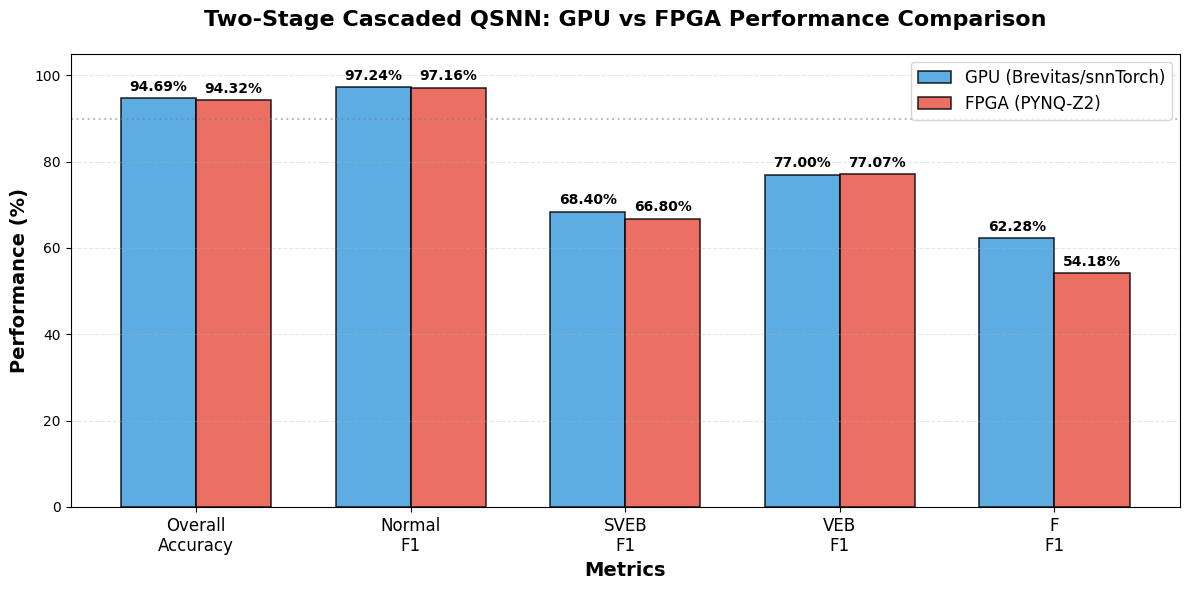

Bar graph saved as 'gpu_vs_fpga_performance.png'


In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Data from Table 1
metrics = ['Overall\nAccuracy', 'Normal\nF1', 'SVEB\nF1', 'VEB\nF1', 'F\nF1']
gpu_values = [94.69, 97.24, 68.40, 77.00, 62.28]
fpga_values = [94.32, 97.16, 66.80, 77.07, 54.18]

# Set up the bar positions
x = np.arange(len(metrics))
width = 0.35

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
bars1 = ax.bar(x - width/2, gpu_values, width, label='GPU (Brevitas/snnTorch)', 
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, fpga_values, width, label='FPGA (PYNQ-Z2)', 
               color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize the plot
ax.set_ylabel('Performance (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=14, fontweight='bold')
ax.set_title('Two-Stage Cascaded QSNN: GPU vs FPGA Performance Comparison', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12, loc='upper right')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

# Add horizontal line at 90% for reference
ax.axhline(y=90, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, label='90% threshold')

plt.tight_layout()
plt.savefig('gpu_vs_fpga_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Bar graph saved as 'gpu_vs_fpga_performance.png'")

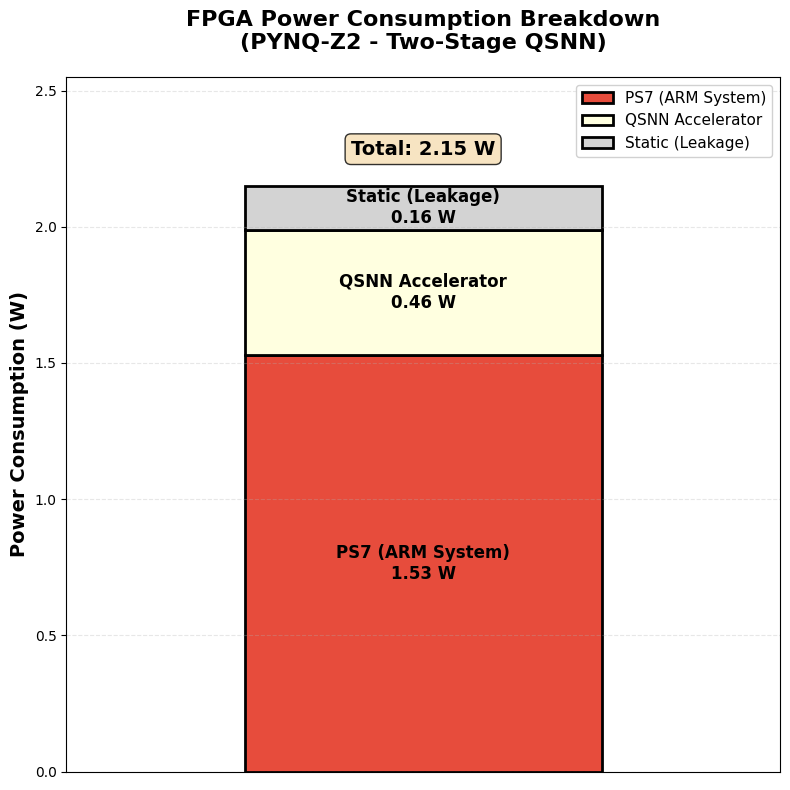

Stacked bar chart saved as 'fpga_power_breakdown.png'

Power breakdown:
  PS7 (ARM System): 1.53 W (71.2%)
  QSNN Accelerator: 0.46 W (21.4%)
  Static (Leakage): 0.16 W (7.4%)
  Total: 2.15 W


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Data from FPGA Power Consumption table
components = ['PS7 (ARM System)', 'QCSNN Accelerator', 'Static (Leakage)']
power_values = [1.53, 0.46, 0.16]  # Ordered from largest to smallest
colors = ['#e74c3c', 'lightyellow', 'lightgray']  # Gray, light orange, light green

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Create stacked bar (single bar)
bottom = 0
bars = []
for i, (component, power, color) in enumerate(zip(components, power_values, colors)):
    bar = ax.bar(0, power, bottom=bottom, color=color, edgecolor='black', 
                 linewidth=2, width=0.5, label=component)
    bars.append(bar)
    
    # Add text label in the middle of each segment
    ax.text(0, bottom + power/2, f'{component}\n{power:.2f} W', 
            ha='center', va='center', fontsize=12, fontweight='bold')
    
    bottom += power

# Add total at the top
total_power = sum(power_values)
ax.text(0, total_power + 0.1, f'Total: {total_power:.2f} W', 
        ha='center', va='bottom', fontsize=14, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Customize plot
ax.set_ylabel('Power Consumption (W)', fontsize=14, fontweight='bold')
ax.set_title('FPGA Power Consumption Breakdown\n(PYNQ-Z2 - Two-Stage QSNN)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0, total_power + 0.4])
ax.set_xlim([-0.5, 0.5])
ax.set_xticks([])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.savefig('fpga_power_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stacked bar chart saved as 'fpga_power_breakdown.png'")
print(f"\nPower breakdown:")
for component, power in zip(components, power_values):
    percentage = (power / total_power) * 100
    print(f"  {component}: {power:.2f} W ({percentage:.1f}%)")
print(f"  Total: {total_power:.2f} W")

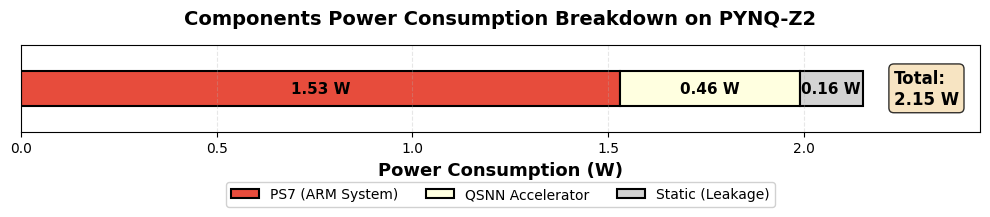

Horizontal stacked bar chart saved as 'fpga_power_breakdown.png'

Power breakdown:
  PS7 (ARM System): 1.53 W (71.2%)
  QSNN Accelerator: 0.46 W (21.4%)
  Static (Leakage): 0.16 W (7.4%)
  Total: 2.15 W


In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Data from FPGA Power Consumption table
components = ['PS7 (ARM System)', 'QCSNN Accelerator', 'Static (Leakage)']
power_values = [1.53, 0.46, 0.16]  # Ordered from largest to smallest
colors = ['#e74c3c', 'lightyellow', 'lightgray']  # Gray, light orange, light green

# Create figure (horizontal, smaller size)
fig, ax = plt.subplots(figsize=(10, 3))

# Create horizontal stacked bar
left = 0
bars = []
for i, (component, power, color) in enumerate(zip(components, power_values, colors)):
    bar = ax.barh(0, power, left=left, color=color, edgecolor='black', 
                  linewidth=1.5, height=0.4, label=component)
    bars.append(bar)
    
    # Add text label in the middle of each segment
    ax.text(left + power/2, 0, f'{power:.2f} W', 
            ha='center', va='center', fontsize=11, fontweight='bold')
    
    left += power

# Add total at the end
total_power = sum(power_values)
ax.text(total_power + 0.08, 0, f'Total:\n{total_power:.2f} W', 
        ha='left', va='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Customize plot
ax.set_xlabel('Power Consumption (W)', fontsize=13, fontweight='bold')
ax.set_title('Components Power Consumption Breakdown on PYNQ-Z2', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim([0, total_power + 0.3])
ax.set_ylim([-0.5, 0.5])
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.50), 
          ncol=3, fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('fpga_power_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("Horizontal stacked bar chart saved as 'fpga_power_breakdown.png'")
print(f"\nPower breakdown:")
for component, power in zip(components, power_values):
    percentage = (power / total_power) * 100
    print(f"  {component}: {power:.2f} W ({percentage:.1f}%)")
print(f"  Total: {total_power:.2f} W")

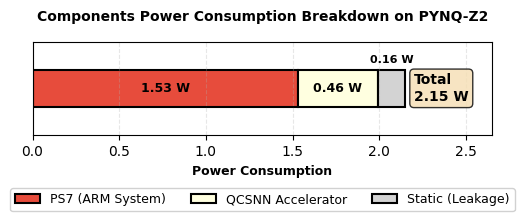

Horizontal stacked bar chart saved as 'fpga_power_breakdown.png'

Power breakdown:
  PS7 (ARM System): 1.53 W (71.2%)
  QCSNN Accelerator: 0.46 W (21.4%)
  Static (Leakage): 0.16 W (7.4%)
  Total: 2.15 W


In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Data from FPGA Power Consumption table
components = ['PS7 (ARM System)', 'QCSNN Accelerator', 'Static (Leakage)']
power_values = [1.53, 0.46, 0.16]  # Ordered from largest to smallest
colors = ['#e74c3c', 'lightyellow', 'lightgray']  # Gray, light orange, light green

# Create figure with reduced size (0.7x)
fig, ax = plt.subplots(figsize=(8*0.7, 3))

# Create horizontal stacked bar
left = 0
bars = []
for i, (component, power, color) in enumerate(zip(components, power_values, colors)):
    bar = ax.barh(0, power, left=left, color=color, edgecolor='black', 
                  linewidth=1.5, height=0.4, label=component)
    bars.append(bar)
    
    # Add text label - position based on segment size
    if power > 0.3:  # Large segments - text inside
        ax.text(left + power/2, 0, f'{power:.2f} W', 
                ha='center', va='center', fontsize=9, fontweight='bold')
    else:  # Small segments - text outside/above
        ax.text(left + power/2, 0.25, f'{power:.2f} W', 
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    left += power

# Add total at the end
total_power = sum(power_values)
ax.text(total_power + 0.05, 0, f'Total\n{total_power:.2f} W', 
        ha='left', va='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.3))

# Customize plot
ax.set_xlabel('Power Consumption', fontsize=9, fontweight='bold')
ax.set_title('Components Power Consumption Breakdown on PYNQ-Z2', 
             fontsize=10, fontweight='bold', pad=15)
ax.set_xlim([0, total_power + 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add legend below the bar
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), 
          ncol=3, fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.savefig('fpga_power_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("Horizontal stacked bar chart saved as 'fpga_power_breakdown.png'")
print(f"\nPower breakdown:")
for component, power in zip(components, power_values):
    percentage = (power / total_power) * 100
    print(f"  {component}: {power:.2f} W ({percentage:.1f}%)")
print(f"  Total: {total_power:.2f} W")

Bar graph saved successfully!
Files created:
  - gpu_fpga_comparison.png (high resolution)
  - gpu_fpga_comparison.pdf (vector format)


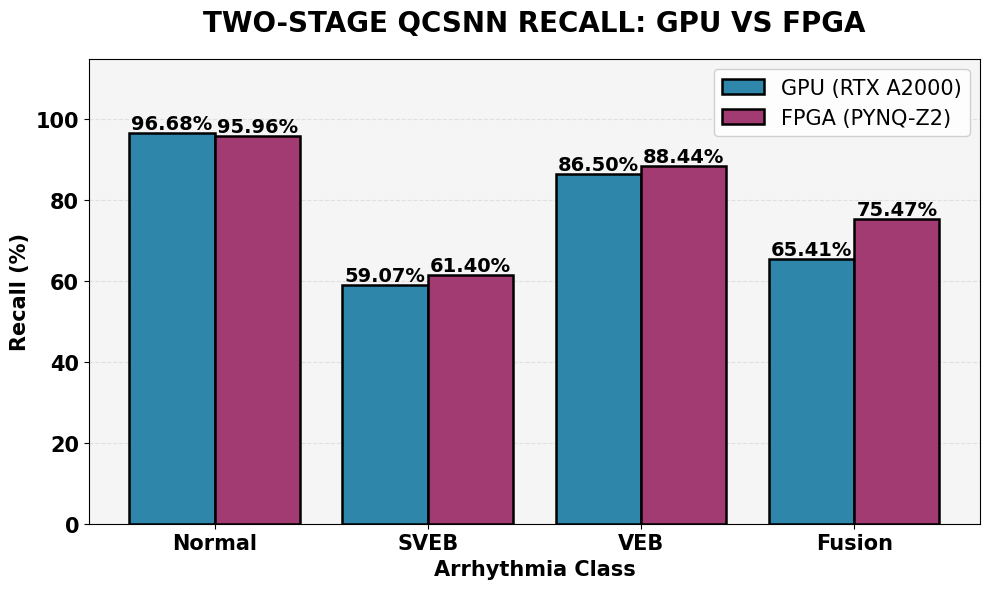

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data
classes = ['Normal', 'SVEB', 'VEB', 'Fusion']
gpu_scores = [96.68, 59.07, 86.50, 65.41]
fpga_scores = [95.96, 61.40, 88.44, 75.47]

# Set up the figure with professional styling
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of bars and positions
bar_width = 0.40
x_pos = np.arange(len(classes))

# Create bars
bars1 = ax.bar(x_pos - bar_width/2, gpu_scores, bar_width, 
               label='GPU (RTX A2000)', color='#2E86AB', edgecolor='black', linewidth=1.8)
bars2 = ax.bar(x_pos + bar_width/2, fpga_scores, bar_width, 
               label='FPGA (PYNQ-Z2)', color='#A23B72', edgecolor='black', linewidth=1.8)

# Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
ax.set_xlabel('Arrhythmia Class', fontsize=15, fontweight='bold')
ax.set_ylabel('Recall (%)', fontsize=15, fontweight='bold')
ax.set_title('TWO-STAGE QCSNN RECALL: GPU VS FPGA', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(classes, fontsize=15, fontweight='bold')

# Increase y-tick font size and weight
ax.tick_params(axis='y', labelsize=15)
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')

ax.legend(fontsize=15, loc='upper right', framealpha=0.9)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Set y-axis limits
ax.set_ylim(0, 115)

# Add a subtle background color
ax.set_facecolor('#F5F5F5')

# Tight layout
plt.tight_layout()

# Save the figure
plt.savefig('gpu_fpga_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('gpu_fpga_comparison.pdf', bbox_inches='tight')

print("Bar graph saved successfully!")
print("Files created:")
print("  - gpu_fpga_comparison.png (high resolution)")
print("  - gpu_fpga_comparison.pdf (vector format)")

Bar graph saved successfully!
Files created:
  - gpu_fpga_comparison_precision.png (high resolution)
  - gpu_fpga_comparison_precision.pdf (vector format)


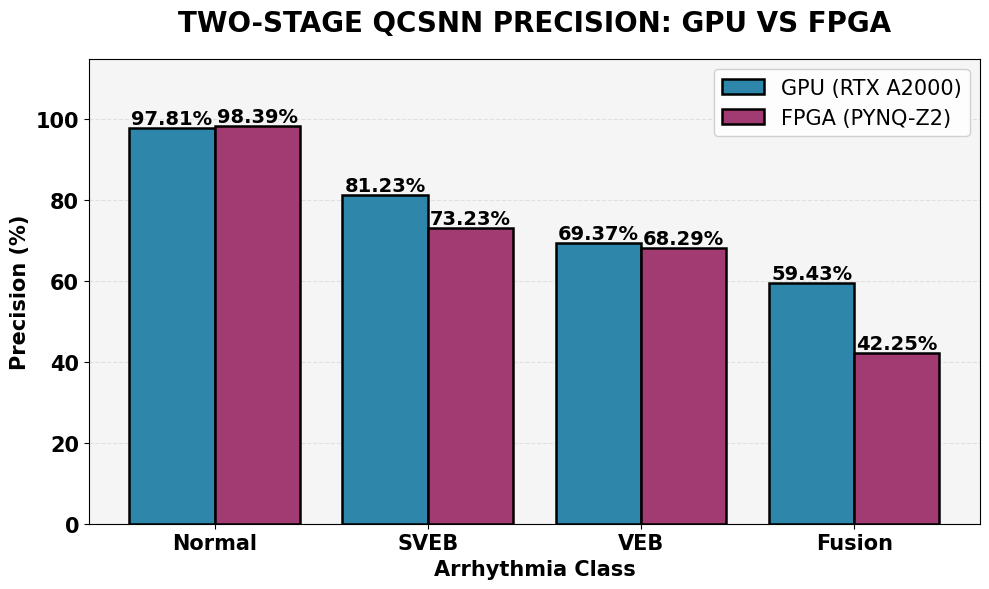

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
classes = ['Normal', 'SVEB', 'VEB', 'Fusion']
gpu_scores = [97.81, 81.23, 69.37, 59.43]
fpga_scores = [98.39, 73.23, 68.29, 42.25]

# Normal 97.81% 98.39% +0.72
# SVEB 81.23% 73.23% +8.00
# VEB 69.37% 68.29% +1.08
# F 59.43% 42.25% +17.18

# Set up the figure with professional styling
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of bars and positions
bar_width = 0.40
x_pos = np.arange(len(classes))

# Create bars
bars1 = ax.bar(x_pos - bar_width/2, gpu_scores, bar_width, 
               label='GPU (RTX A2000)', color='#2E86AB', edgecolor='black', linewidth=1.8)
bars2 = ax.bar(x_pos + bar_width/2, fpga_scores, bar_width, 
               label='FPGA (PYNQ-Z2)', color='#A23B72', edgecolor='black', linewidth=1.8)

# Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the plot
ax.set_xlabel('Arrhythmia Class', fontsize=15, fontweight='bold')
ax.set_ylabel('Precision (%)', fontsize=15, fontweight='bold')
ax.set_title('TWO-STAGE QCSNN PRECISION: GPU VS FPGA', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(classes, fontsize=15, fontweight='bold')

# Increase y-tick font size and weight
ax.tick_params(axis='y', labelsize=15)
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')

ax.legend(fontsize=15, loc='upper right', framealpha=0.9)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Set y-axis limits
ax.set_ylim(0, 115)

# Add a subtle background color
ax.set_facecolor('#F5F5F5')

# Tight layout
plt.tight_layout()

# Save the figure
plt.savefig('gpu_fpga_comparison_precision.png', dpi=300, bbox_inches='tight')
plt.savefig('gpu_fpga_comparison_precision.pdf', bbox_inches='tight')

print("Bar graph saved successfully!")
print("Files created:")
print("  - gpu_fpga_comparison_precision.png (high resolution)")
print("  - gpu_fpga_comparison_precision.pdf (vector format)")

In [ ]:
# Collect test outputs properly
model = fold_results_with_probs['fold5']['model']
model.eval()

all_logits = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()
        
        out, _ = forward_pass(model, num_steps, x)  # (T, B, 4)
        out = out.mean(0)  # (B, 4) - logits
        
        all_logits.append(out.cpu())
        all_labels.append(y.cpu())

all_logits = torch.cat(all_logits)  # (N, 4)
all_labels = torch.cat(all_labels)  # (N,)

# Method 1: Plain argmax on logits (no weights, no softmax)
preds_argmax = all_logits.argmax(dim=1)

# Method 2: Weighted softmax (your deployed approach)
probs = torch.softmax(all_logits, dim=1)
weighted_probs = probs.clone()
weights = {0: 0.628, 1: 1.203, 2: 1.531, 3: 1.500}
for class_id, weight in weights.items():
    weighted_probs[:, class_id] /= weight
preds_weighted = weighted_probs.argmax(dim=1)

# Compare
acc_argmax = (preds_argmax == all_labels).float().mean().item()
acc_weighted = (preds_weighted == all_labels).float().mean().item()

print(f"Plain argmax accuracy:   {acc_argmax:.4f} ({acc_argmax*100:.2f}%)")
print(f"Weighted softmax accuracy: {acc_weighted:.4f} ({acc_weighted*100:.2f}%)")

# Per-class comparison
class_names = ['Normal', 'SVEB', 'VEB', 'F']
for c in range(4):
    mask = all_labels == c
    acc_c_argmax = (preds_argmax[mask] == all_labels[mask]).float().mean().item()
    acc_c_weighted = (preds_weighted[mask] == all_labels[mask]).float().mean().item()
    print(f"{class_names[c]:<10} - Argmax: {acc_c_argmax:.4f}, Weighted: {acc_c_weighted:.4f}")

In [ ]:
# # Extract NEW clinical thresholds from Fold 5
# fold5_thresholds_clinical = {
#     0: fold_thresholds_clinical['fold5'][0]['threshold'],  # 0.3567
#     1: fold_thresholds_clinical['fold5'][1]['threshold'],  # 0.4576
#     2: fold_thresholds_clinical['fold5'][2]['threshold'],  # 0.4086
#     3: fold_thresholds_clinical['fold5'][3]['threshold']   # 0.4668
# }

# # Evaluate with CLINICAL thresholds
# test_metrics_clinical = evaluate_with_tuned_thresholds(
#     fold_results_with_probs['fold5']['model'],
#     test_loader,
#     device,
#     num_steps=10,
#     thresholds=fold5_thresholds_clinical
# )

# # Print properly formatted comparison
# class_names = ['Normal', 'SVEB', 'VEB', 'F']
# print("\n" + "="*90)
# print("COMPARISON: Original vs Clinical Thresholds (Fold 5 Test Set)")
# print("="*90)
# print(f"{'Class':<10} {'Strategy':<12} {'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
# print("-"*90)

# # Original results
# orig = [(0.9910, 0.9202, 0.9543), (0.5110, 0.7487, 0.6074), 
#         (0.6272, 0.9361, 0.7512), (0.2744, 0.8679, 0.4169)]
# orig_thresh = [0.3567, 0.4133, 0.4497, 0.4420]

# for i, name in enumerate(class_names):
#     # Original
#     print(f"{name:<10} {'Original':<12} {orig_thresh[i]:<12.4f} "
#           f"{orig[i][0]:<12.4f} {orig[i][1]:<12.4f} {orig[i][2]:<12.4f}")
#     # Clinical
#     print(f"{'':<10} {'Clinical':<12} {fold5_thresholds_clinical[i]:<12.4f} "
#           f"{test_metrics_clinical['precision'][i]:<12.4f} "
#           f"{test_metrics_clinical['recall'][i]:<12.4f} "
#           f"{test_metrics_clinical['f1'][i]:<12.4f}")
#     print()

In [ ]:
# print("Threshold comparison:")
# print(f"{'Class':<10} {'Original':<12} {'Clinical':<12} {'Change':<12}")
# print("-"*50)
# orig_thresh = {0: 0.3567, 1: 0.4133, 2: 0.4497, 3: 0.4420}
# class_names = ['Normal', 'SVEB', 'VEB', 'F']
# for i in range(4):
#     print(f"{class_names[i]:<10} {orig_thresh[i]:<12.4f} "
#           f"{fold5_thresholds_clinical[i]:<12.4f} "
#           f"{fold5_thresholds_clinical[i] - orig_thresh[i]:<+12.4f}")

In [ ]:
# print("\nDEBUG: Testing threshold application...")
# print(f"Thresholds being passed: {fold5_thresholds_clinical}")

# # Add debug output to the function
# test_metrics_clinical_debug = evaluate_with_tuned_thresholds(
#     fold_results_with_probs['fold5']['model'],
#     test_loader,
#     device,
#     num_steps=10,
#     thresholds=fold5_thresholds_clinical
# )

# print(f"\nTest accuracy: {test_metrics_clinical_debug['accuracy']:.4f}")
# print(f"F recall: {test_metrics_clinical_debug['recall'][3]:.4f}")
# print(f"F precision: {test_metrics_clinical_debug['precision'][3]:.4f}")

In [ ]:
# def evaluate_with_probability_weights(model, test_loader, device, num_steps, weights):
#     """
#     Apply probability weights before argmax.
#     Lower weight = boost that class (easier to predict)
#     Higher weight = suppress that class (harder to predict)
    
#     pred = argmax(P(class_i) / weight_i)
#     """
#     model.eval()
    
#     all_probs = []
#     all_labels = []
    
#     with torch.no_grad():
#         for x, y in test_loader:
#             x = x.to(device, non_blocking=True)
#             y = y.to(device, non_blocking=True).long()
            
#             out, _ = forward_pass(model, num_steps, x)
#             out = out.mean(0)
#             probs = torch.softmax(out, dim=1)
            
#             all_probs.append(probs.cpu())
#             all_labels.append(y.cpu())
    
#     all_probs = torch.cat(all_probs).numpy()  # (N, 4)
#     all_labels = torch.cat(all_labels).numpy()  # (N,)
    
#     # Apply weights: divide probabilities by weights
#     weighted_probs = all_probs.copy()
#     for class_id, weight in weights.items():
#         weighted_probs[:, class_id] /= weight
    
#     # Predict class with highest weighted probability
#     predictions = weighted_probs.argmax(axis=1)
    
#     # Calculate metrics
#     num_classes = 4
#     tp = [0] * num_classes
#     fp = [0] * num_classes
#     tn = [0] * num_classes
#     fn = [0] * num_classes
    
#     for i in range(num_classes):
#         tp[i] = ((predictions == i) & (all_labels == i)).sum()
#         fp[i] = ((predictions == i) & (all_labels != i)).sum()
#         tn[i] = ((predictions != i) & (all_labels != i)).sum()
#         fn[i] = ((predictions != i) & (all_labels == i)).sum()
    
#     EPS = 1e-8
#     prec = [tp[i] / (tp[i] + fp[i] + EPS) for i in range(num_classes)]
#     rec = [tp[i] / (tp[i] + fn[i] + EPS) for i in range(num_classes)]
#     f1 = [2 * prec[i] * rec[i] / (prec[i] + rec[i] + EPS) for i in range(num_classes)]
    
#     acc = (predictions == all_labels).sum() / len(all_labels)
    
#     return {
#         'accuracy': acc,
#         'precision': prec,
#         'recall': rec,
#         'f1': f1,
#     }


# def tune_probability_weights(probs, labels, target_recalls, weight_range=(0.5, 2.0), n_steps=20):
#     """
#     Grid search to find optimal probability weights for target recalls.
    
#     Args:
#         probs: (N, 4) probability array
#         labels: (N,) label array
#         target_recalls: {class_id: target_recall}
#         weight_range: (min_weight, max_weight) to search
#         n_steps: number of steps in grid
#     """
#     class_names = ['Normal', 'SVEB', 'VEB', 'F']
    
#     # Start with uniform weights (baseline = argmax)
#     best_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
    
#     # We'll tune one class at a time, prioritizing clinical importance
#     # Order: VEB (most important), SVEB, F, Normal
#     tune_order = [2, 1, 3, 0]  # VEB, SVEB, F, Normal
    
#     print("\n" + "="*70)
#     print("TUNING PROBABILITY WEIGHTS (Grid Search)")
#     print("="*70)
    
#     for class_id in tune_order:
#         class_name = class_names[class_id]
#         target_recall = target_recalls[class_id]
        
#         print(f"\n--- Tuning {class_name} (class {class_id}) ---")
#         print(f"Target recall: {target_recall:.2f}")
        
#         # Grid search for this class's weight
#         weights_to_try = np.linspace(weight_range[0], weight_range[1], n_steps)
#         best_weight = 1.0
#         best_metric = -float('inf')
#         results = []
        
#         for weight in weights_to_try:
#             # Test this weight
#             test_weights = best_weights.copy()
#             test_weights[class_id] = weight
            
#             # Apply weights
#             weighted_probs = probs.copy()
#             for cid, w in test_weights.items():
#                 weighted_probs[:, cid] /= w
            
#             preds = weighted_probs.argmax(axis=1)
            
#             # Calculate recall for this class
#             tp = ((preds == class_id) & (labels == class_id)).sum()
#             fn = ((preds != class_id) & (labels == class_id)).sum()
#             recall = tp / (tp + fn + 1e-8)
            
#             # Calculate precision
#             fp = ((preds == class_id) & (labels != class_id)).sum()
#             precision = tp / (tp + fp + 1e-8)
#             f1 = 2 * precision * recall / (precision + recall + 1e-8)
            
#             results.append((weight, recall, precision, f1))
            
#             # Objective: maximize F1 while meeting recall constraint
#             if recall >= target_recall:
#                 if f1 > best_metric:
#                     best_metric = f1
#                     best_weight = weight
        
#         # Update weights
#         best_weights[class_id] = best_weight
        
#         # Find best result
#         best_result = [r for r in results if r[0] == best_weight][0]
#         _, best_rec, best_prec, best_f1 = best_result
        
#         print(f"Optimal weight: {best_weight:.3f}")
#         print(f"Achieved - Prec: {best_prec:.4f}, Rec: {best_rec:.4f}, F1: {best_f1:.4f}")
        
#         # Show if target was met
#         if best_rec >= target_recall:
#             print(f"✓ Target recall met!")
#         else:
#             print(f"✗ Target recall NOT met (best possible: {best_rec:.4f})")
    
#     return best_weights


# # Apply to Fold 5
# print("\n" + "="*70)
# print("FOLD 5 - Probability Weight Tuning")
# print("="*70)

# # Use validation probabilities from fold_results_with_probs
# val_probs = fold_results_with_probs['fold5']['probs'].numpy()
# val_labels = fold_results_with_probs['fold5']['labels'].numpy()

# # Tune weights
# optimal_weights = tune_probability_weights(
#     val_probs,
#     val_labels,
#     target_recalls={
#         0: 0.90,  # Normal
#         1: 0.70,  # SVEB
#         2: 0.90,  # VEB (most important!)
#         3: 0.50   # F (least important)
#     },
#     weight_range=(0.3, 3.0),
#     n_steps=30
# )

# print("\n" + "="*70)
# print("FINAL OPTIMAL WEIGHTS")
# print("="*70)
# class_names = ['Normal', 'SVEB', 'VEB', 'F']
# for class_id, name in enumerate(class_names):
#     print(f"{name:<10}: {optimal_weights[class_id]:.3f}")

# # Evaluate on test set
# print("\n" + "="*70)
# print("TEST SET - Fold 5 with Probability Weights")
# print("="*70)

# test_metrics_weighted = evaluate_with_probability_weights(
#     fold_results_with_probs['fold5']['model'],
#     test_loader,
#     device,
#     num_steps=10,
#     weights=optimal_weights
# )

# print(f"Accuracy: {test_metrics_weighted['accuracy']*100:.2f}%\n")
# for i, name in enumerate(class_names):
#     print(f"{name:<10} - Prec: {test_metrics_weighted['precision'][i]:.4f}, "
#           f"Rec: {test_metrics_weighted['recall'][i]:.4f}, "
#           f"F1: {test_metrics_weighted['f1'][i]:.4f}")

# prec_macro = np.mean(test_metrics_weighted['precision'])
# rec_macro = np.mean(test_metrics_weighted['recall'])
# f1_macro = np.mean(test_metrics_weighted['f1'])
# print(f"\nMacro - Prec: {prec_macro:.4f}, Rec: {rec_macro:.4f}, F1: {f1_macro:.4f}")

In [ ]:
# # Retune with corrected priorities
# optimal_weights_corrected = tune_probability_weights(
#     val_probs,
#     val_labels,
#     target_recalls={
#         0: 0.90,  # Normal - high
#         1: 0.78,  # SVEB - HIGHER than F (more dangerous!)
#         2: 0.90,  # VEB - highest (life-threatening)
#         3: 0.50   # F - LOWER than SVEB (benign)
#     },
#     weight_range=(0.3, 3.0),
#     n_steps=30
# )

# print("\n" + "="*70)
# print("CORRECTED OPTIMAL WEIGHTS")
# print("="*70)
# class_names = ['Normal', 'SVEB', 'VEB', 'F']
# for class_id, name in enumerate(class_names):
#     print(f"{name:<10}: {optimal_weights_corrected[class_id]:.3f}")

# # Evaluate on test
# test_metrics_corrected = evaluate_with_probability_weights(
#     fold_results_with_probs['fold5']['model'],
#     test_loader,
#     device,
#     num_steps=10,
#     weights=optimal_weights_corrected
# )

# print("\n" + "="*70)
# print("TEST SET - Fold 5 with CORRECTED Weights")
# print("="*70)
# print(f"Accuracy: {test_metrics_corrected['accuracy']*100:.2f}%\n")
# for i, name in enumerate(class_names):
#     print(f"{name:<10} - Prec: {test_metrics_corrected['precision'][i]:.4f}, "
#           f"Rec: {test_metrics_corrected['recall'][i]:.4f}, "
#           f"F1: {test_metrics_corrected['f1'][i]:.4f}")

In [ ]:
# # Manually adjust F weight - make it easier to predict
# optimal_weights_manual = optimal_weights_corrected.copy()
# optimal_weights_manual[3] = 1.5  # Lower from 2.534 to 1.5

# print("\n" + "="*70)
# print("MANUALLY ADJUSTED WEIGHTS")
# print("="*70)
# class_names = ['Normal', 'SVEB', 'VEB', 'F']
# for class_id, name in enumerate(class_names):
#     print(f"{name:<10}: {optimal_weights_manual[class_id]:.3f}")

# # Evaluate on test
# test_metrics_manual = evaluate_with_probability_weights(
#     fold_results_with_probs['fold5']['model'],
#     test_loader,
#     device,
#     num_steps=10,
#     weights=optimal_weights_manual
# )

# print("\n" + "="*70)
# print("TEST SET - Fold 5 with MANUAL WEIGHTS")
# print("="*70)
# print(f"Accuracy: {test_metrics_manual['accuracy']*100:.2f}%\n")
# for i, name in enumerate(class_names):
#     print(f"{name:<10} - Prec: {test_metrics_manual['precision'][i]:.4f}, "
#           f"Rec: {test_metrics_manual['recall'][i]:.4f}, "
#           f"F1: {test_metrics_manual['f1'][i]:.4f}")

# prec_macro = np.mean(test_metrics_manual['precision'])
# rec_macro = np.mean(test_metrics_manual['recall'])
# f1_macro = np.mean(test_metrics_manual['f1'])
# print(f"\nMacro - Prec: {prec_macro:.4f}, Rec: {rec_macro:.4f}, F1: {f1_macro:.4f}")

# # Compare with original that worked
# print("\n" + "="*70)
# print("COMPARISON: First Config vs Manual Adjustment")
# print("="*70)
# print(f"{'Class':<10} {'Original Rec':<15} {'Manual Rec':<15} {'Target':<10}")
# print("-"*70)
# original_recs = [0.9520, 0.6715, 0.9375, 0.7170]
# for i, name in enumerate(class_names):
#     target = {0: 0.90, 1: 0.82, 2: 0.90, 3: 0.50}[i]
#     print(f"{name:<10} {original_recs[i]:<15.4f} {test_metrics_manual['recall'][i]:<15.4f} {target:<10.2f}")

In [ ]:
# # Fine-tune the weights
# optimal_weights_final = {
#     0: 0.672,  # Normal - keep
#     1: 0.90,   # SVEB - LOWER (boost it to 78% recall)
#     2: 1.510,  # VEB - keep (working well)
#     3: 1.80    # F - RAISE (suppress to ~60% recall)
# }

# test_metrics_final = evaluate_with_probability_weights(
#     fold_results_with_probs['fold5']['model'],
#     test_loader,
#     device,
#     num_steps=10,
#     weights=optimal_weights_final
# )

# print("\n" + "="*70)
# print("TEST SET - FINAL TUNED WEIGHTS")
# print("="*70)
# print(f"Accuracy: {test_metrics_final['accuracy']*100:.2f}%\n")

# class_names = ['Normal', 'SVEB', 'VEB', 'F']
# for i, name in enumerate(class_names):
#     print(f"{name:<10} - Prec: {test_metrics_final['precision'][i]:.4f}, "
#           f"Rec: {test_metrics_final['recall'][i]:.4f}, "
#           f"F1: {test_metrics_final['f1'][i]:.4f}")

In [ ]:
# def evaluate_all_folds_with_tuned_thresholds(test_dataset, fold_tune_results, device, num_steps=10, batch_size=256):
#     """
#     Evaluate each fold on test set (4-class - no threshold tuning).
#     """
    
#     test_loader = DataLoader(
#         test_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         pin_memory=(device.type == 'cuda'),
#         num_workers=0
#     )
    
#     print("\n" + "="*70)
#     print("TEST SET EVALUATION - 4-Class Classification")
#     print("="*70)
#     print(f"Test set size: {len(test_dataset)}")
    
#     y_test = test_dataset.tensors[1].cpu().numpy()
#     class_names = ['Normal', 'SVEB', 'VEB', 'F']
#     print("Test class distribution:")
#     for i, name in enumerate(class_names):
#         count = (y_test == i).sum()
#         print(f"  {name}={count}")
#     print("="*70)
    
#     fold_test_results = {}
    
#     for fold in range(1, 7):
#         fold_key = f"fold{fold}"
#         model = fold_tune_results[fold_key]['model']
        
#         print(f"\n--- FOLD{fold} ---")
        
#         test_metrics = evaluate_with_threshold(model, test_loader, device, num_steps, threshold=None)
        
#         print(f"Accuracy: {test_metrics['accuracy']*100:.2f}%")
#         for i, name in enumerate(class_names):
#             print(f"{name:<10} - Prec: {test_metrics['precision'][i]:.4f}, "
#                   f"Rec: {test_metrics['recall'][i]:.4f}, "
#                   f"F1: {test_metrics['f1'][i]:.4f}")
        
#         # Macro averages
#         prec_macro = np.mean(test_metrics['precision'])
#         rec_macro = np.mean(test_metrics['recall'])
#         f1_macro = np.mean(test_metrics['f1'])
#         print(f"Macro      - Prec: {prec_macro:.4f}, Rec: {rec_macro:.4f}, F1: {f1_macro:.4f}")
        
#         fold_test_results[fold_key] = {
#             'threshold': None,
#             'metrics': test_metrics
#         }
    
#     # Summary statistics
#     print("\n" + "="*70)
#     print("SUMMARY ACROSS FOLDS - 4-Class")
#     print("="*70)
    
#     for class_idx, class_name in enumerate(class_names):
#         recalls = [fold_test_results[f"fold{i}"]['metrics']['recall'][class_idx] for i in range(1, 7)]
#         precs = [fold_test_results[f"fold{i}"]['metrics']['precision'][class_idx] for i in range(1, 7)]
#         f1s = [fold_test_results[f"fold{i}"]['metrics']['f1'][class_idx] for i in range(1, 7)]
        
#         print(f"{class_name} Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f} "
#               f"[{np.min(recalls):.4f}, {np.max(recalls):.4f}]")
#         print(f"{class_name} Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f} "
#               f"[{np.min(precs):.4f}, {np.max(precs):.4f}]")
#         print(f"{class_name} F1:        {np.mean(f1s):.4f} ± {np.std(f1s):.4f} "
#               f"[{np.min(f1s):.4f}, {np.max(f1s):.4f}]")
#         print()
    
#     return fold_test_results

In [ ]:

# # Evaluate with tuned thresholds
# fold_test_results = evaluate_all_folds_with_tuned_thresholds(
#     test_dataset, fold_tune_results, device, num_steps=10
# )

In [ ]:
def train_final_model(model_factory, dataset, device, num_steps=10, 
                     epochs=60, batch_size=256, lr=0.0001):
    """
    Train final deployment model on ALL training data.
    Uses a small validation split (5%) only for early stopping.
    Monitors f1_macro (for 4-class classification).
    """
    
    if isinstance(device, str):
        device = torch.device(device)
    
    # Small validation split for early stopping only
    y_all = dataset.tensors[1].cpu().numpy()
    train_idx, val_idx = train_test_split(
        np.arange(len(y_all)),
        test_size=0.05,  # Just 5% for early stopping
        stratify=y_all,
        random_state=42
    )
    
    print(f"Training samples: {len(train_idx)}")
    print(f"Validation samples (for early stopping): {len(val_idx)}")
    
    # Warmup
    print("\nCreating model and running Brevitas warmup...")
    model = model_factory().to(device)
    model.train()
    _brevitas_warmup(model, dataset, device, num_steps=num_steps, bs=8, n_steps=10)
    
    # Create data loaders
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    # ============ CORRECTED: Balanced class weights (4 classes) ============
    y_train = dataset.tensors[1][train_idx].cpu().numpy()
    n0 = int((y_train == 0).sum())  # Normal
    n1 = int((y_train == 1).sum())  # SVEB
    n2 = int((y_train == 2).sum())  # VEB
    n3 = int((y_train == 3).sum())  # F
    
    total = len(y_train)
    # Balanced weighting (SAME as K-fold CV)
    w0 = total / (4 * max(n0, 1))
    w1 = total / (4 * max(n1, 1))
    w2 = total / (4 * max(n2, 1))
    w3 = total / (4 * max(n3, 1))
    # ========================================================================
    
    print(f"\nTrain counts: Normal={n0}, SVEB={n1}, VEB={n2}, F={n3}")
    print(f"Class weights: w0={w0:.3f}, w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}")
    
    class_w = torch.tensor([w0, w1, w2, w3], dtype=torch.float32, device=device)
    loss_func = torch.nn.CrossEntropyLoss(weight=class_w)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=(device.type == 'cuda'),
        num_workers=0
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=(device.type == 'cuda'),
        num_workers=0
    )
    
    # Training loop
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_f1_macro': [], 'val_recall_macro': [], 'val_precision_macro': []
    }
    
    best_f1 = -1
    best_epoch = 0
    best_state = None
    patience = 10
    no_improve = 0
    
    print(f"\n{'='*70}")
    print("Training Final Model - Monitoring f1_macro (4-class)")
    print(f"{'='*70}\n")
    
    for epoch in range(1, epochs + 1):
        # Training
        tr_loss_sum, tr_corr = train_epoch(model, train_loader, loss_func, optimizer, device, num_steps)
        
        # Validation (for early stopping)
        val_metrics = validation_epoch(model, val_loader, loss_func, device, num_steps)
        
        n_train = len(train_subset)
        tr_loss = tr_loss_sum / max(n_train, 1)
        tr_acc = 100.0 * tr_corr / max(n_train, 1)
        
        print(
            f"Epoch {epoch:2d}/{epochs} | "
            f"Train L={tr_loss:.4f} A={tr_acc:5.2f}% | "
            f"Val L={val_metrics['loss']:.4f} A={val_metrics['acc']:5.2f}% "
            f"F1(M)={val_metrics['f1_macro']:.4f} "
            f"Rec(M)={val_metrics['recall_macro']:.4f} "
            f"Prec(M)={val_metrics['precision_macro']:.4f}"
        )
        
        # Track history
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['acc'])
        history['val_f1_macro'].append(val_metrics['f1_macro'])
        history['val_recall_macro'].append(val_metrics['recall_macro'])
        history['val_precision_macro'].append(val_metrics['precision_macro'])
        
        # Early stopping based on f1_macro
        f1_macro = val_metrics['f1_macro']
        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_epoch = epoch
            no_improve = 0
            with torch.no_grad():
                best_state = {k: v.detach().cpu().clone() 
                             for k, v in model.state_dict().items()}
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break
    
    print(f"\nBest epoch: {best_epoch}, Best f1_macro: {best_f1:.4f}")
    
    # Load best weights
    model.load_state_dict(best_state)
    model.to(device)
    
    return model, history, best_epoch

In [ ]:

# Train the final model
print("="*70)
print("RETRAINING FOLD 5 ARCHITECTURE ON FULL TRAINING DATA")
print("="*70)

final_model, final_history, best_epoch = train_final_model(
    model_factory=create_qcsnn_model,
    dataset=dataset,  # Full 80,557 samples
    device=device,
    num_steps=10,
    epochs=60,
    batch_size=256,
    lr=0.0001
)


In [ ]:

print("\n" + "="*70)
print("EVALUATING FINAL MODEL ON TEST SET")
print("="*70)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    pin_memory=(device.type == 'cuda'),
    num_workers=0
)

# Evaluate with threshold 0.70 (from original Fold 5)
final_test_metrics = evaluate_with_threshold(
    final_model, 
    test_loader,
    device, 
    num_steps=10, 
    threshold=0.70
)

print(f"\nFinal Model Performance (threshold=0.70):")
print(f"Accuracy: {final_test_metrics['accuracy']*100:.2f}%")
print(f"Normal    - Prec: {final_test_metrics['precision'][0]:.4f}, "
      f"Rec: {final_test_metrics['recall'][0]:.4f}, "
      f"F1: {final_test_metrics['f1'][0]:.4f}")
print(f"Abnormal  - Prec: {final_test_metrics['precision'][1]:.4f}, "
      f"Rec: {final_test_metrics['recall'][1]:.4f}, "
      f"F1: {final_test_metrics['f1'][1]:.4f}")

print("\n" + "="*70)
print("COMPARISON")
print("="*70)
print(f"Original Fold 5 - Prec: 0.7067, Rec: 0.8658, F1: 0.7782")
print(f"Retrained Model - Prec: {final_test_metrics['precision'][1]:.4f}, "
      f"Rec: {final_test_metrics['recall'][1]:.4f}, "
      f"F1: {final_test_metrics['f1'][1]:.4f}")

if final_test_metrics['f1'][1] > 0.7782:
    print("\n✓ Retrained model is BETTER - use this for deployment")
    print("Save this model's weights for FPGA extraction")
else:
    print("\n✗ Original Fold 5 is BETTER - use original weights")
    print("Use fold_ckpts['fold5']['state_dict_cpu'] for FPGA extraction")

In [ ]:
def evaluate_final_model_4class(model, dataset, train_idx, val_idx, device, num_steps=10):
    """
    Evaluate final 4-class model on the 5% validation split (no threshold tuning for 4-class).
    """
    
    # Create validation loader
    val_subset = Subset(dataset, val_idx)
    val_loader = DataLoader(
        val_subset,
        batch_size=256,
        shuffle=False,
        pin_memory=(device.type == 'cuda'),
        num_workers=0
    )
    
    print("Evaluating on 5% validation set...")
    val_results = tune_threshold_on_validation(
        model, val_loader, device, num_steps
    )
    
    # Extract results (only 'argmax' key for 4-class)
    r = val_results['argmax']
    
    # Display results
    print("\nValidation results:")
    print(f"Accuracy: {r['accuracy']:.4f}")
    class_names = ['Normal', 'SVEB', 'VEB', 'F']
    print(f"\n{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1':<12}")
    print("-" * 48)
    for i, name in enumerate(class_names):
        print(f"{name:<10} {r['precision'][i]:<12.4f} "
              f"{r['recall'][i]:<12.4f} "
              f"{r['f1'][i]:<12.4f}")
    
    print(f"\nMacro - Prec: {r['precision_macro']:.4f}, "
          f"Rec: {r['recall_macro']:.4f}, "
          f"F1: {r['f1_macro']:.4f}")
    
    return val_results


# Get the same train/val split used during training
y_all = dataset_4class.tensors[1].cpu().numpy()
train_idx, val_idx = train_test_split(
    np.arange(len(y_all)),
    test_size=0.05,
    stratify=y_all,
    random_state=42
)

print("="*70)
print("VALIDATION EVALUATION FOR RETRAINED 4-CLASS MODEL")
print("="*70)

# Evaluate on validation
final_val_results = evaluate_final_model_4class(
    final_model_4class, dataset_4class, train_idx, val_idx, device, num_steps=10
)

# Evaluate on test set
print("\n" + "="*70)
print("TEST SET EVALUATION - Retrained 4-Class Model")
print("="*70)

final_test_4class = evaluate_with_threshold(
    final_model_4class,
    test_loader_4class,
    device,
    num_steps=10,
    threshold=None  # No threshold for 4-class
)

class_names = ['Normal', 'SVEB', 'VEB', 'F']
print(f"\nRetrained 4-Class Model:")
print(f"Accuracy: {final_test_4class['accuracy']*100:.2f}%")
for i, name in enumerate(class_names):
    print(f"{name:<10} - Prec: {final_test_4class['precision'][i]:.4f}, "
          f"Rec: {final_test_4class['recall'][i]:.4f}, "
          f"F1: {final_test_4class['f1'][i]:.4f}")

prec_macro = np.mean(final_test_4class['precision'])
rec_macro = np.mean(final_test_4class['recall'])
f1_macro = np.mean(final_test_4class['f1'])
print(f"Macro      - Prec: {prec_macro:.4f}, Rec: {rec_macro:.4f}, F1: {f1_macro:.4f}")

print("\n" + "="*70)
print("FINAL COMPARISON - 4-Class")
print("="*70)
print(f"{'Model':<30} {'Macro F1':<12} {'Macro Recall':<15} {'Macro Precision':<15}")
print("-" * 75)

# Assuming you tracked best fold during K-fold CV
best_fold_f1 = 0.XXXX  # Replace with actual best fold macro F1
best_fold_rec = 0.XXXX  # Replace with actual best fold macro recall
best_fold_prec = 0.XXXX  # Replace with actual best fold macro precision

print(f"{'Best Fold (from K-fold)':<30} {best_fold_f1:<12.4f} {best_fold_rec:<15.4f} {best_fold_prec:<15.4f}")
print(f"{'Retrained on Full Data':<30} {f1_macro:<12.4f} {rec_macro:<15.4f} {prec_macro:<15.4f}")

print("\n" + "="*70)
print("DECISION")
print("="*70)

# Compare based on macro F1
if f1_macro > best_fold_f1:
    print("✓ RETRAINED MODEL is BETTER")
    print(f"  - Better Macro F1: {f1_macro:.4f} vs {best_fold_f1:.4f}")
    print("\n→ Use retrained model for deployment")
else:
    print("✗ BEST FOLD is BETTER")
    print(f"  - Best fold Macro F1: {best_fold_f1:.4f}")
    print(f"  - Retrained Macro F1: {f1_macro:.4f}")
    print("\n→ Use best fold for deployment")

In [ ]:


import os
import math
import numpy as np
import torch

import brevitas.nn as qnn
import snntorch as snn

# -----------------------
# Utilities
# -----------------------

def _ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def _to_one(x):
    if isinstance(x, torch.Tensor):
        if x.numel() == 1:
            return float(x.detach().cpu().item())
        return x.detach().cpu().numpy()
    if isinstance(x, (float, int)):
        return x
    return x

def _get_bit_scale_zp_from_quant(q):
    """Return (bit_width, scale, zero_point, signed) from a brevitas quantizer-like object."""
    bit_width = None
    scale = None
    zero_point = None
    signed = True
    # bit width
    for k in ('bit_width', 'bit_width_impl', 'bit_width_f'):
        v = getattr(q, k, None)
        if v is None: continue
        try:
            v = v() if callable(v) else v
            bit_width = int(_to_one(v))
            break
        except Exception:
            pass
    # scale
    for k in ('scale', 'tensor_scale', 'scale_impl', 'act_scale', 'weight_scale'):
        v = getattr(q, k, None)
        if v is None: continue
        try:
            v = v() if callable(v) else v
            v = _to_one(v)
            if isinstance(v, (float, int)):
                scale = float(v)
                break
            if isinstance(v, np.ndarray) and v.size == 1:
                scale = float(v.item())
                break
        except Exception:
            pass
    # zero-point
    for k in ('zero_point', 'zero_point_impl', 'zp'):
        v = getattr(q, k, None)
        if v is None: continue
        try:
            v = v() if callable(v) else v
            zero_point = int(round(_to_one(v)))
            break
        except Exception:
            pass
    # signed
    sattr = getattr(q, 'signed', None)
    if isinstance(sattr, bool):
        signed = sattr
    elif zero_point is None:
        signed = True
    # defaults
    if bit_width is None: bit_width = 8
    if scale is None:     scale = 1.0
    if zero_point is None: zero_point = 0
    return bit_width, float(scale), int(zero_point), bool(signed)

def _quantize_multiplier(real_multiplier: float):
    """TFLite-style integer multiplier/shift approximation for a positive real multiplier."""
    if real_multiplier <= 0.0:
        return 0, 0
    mantissa, exponent = math.frexp(real_multiplier)  # real = mantissa * 2^exponent, mantissa in [0.5,1)
    q = int(round(mantissa * (1 << 31)))
    if q == (1 << 31):
        q //= 2
        exponent += 1
    shift = 31 - exponent
    if shift < 0:
        q <<= (-shift)
        shift = 0
    return int(q), int(shift)

# helper types used in headers (names only; arrays use ap_int in C++)
def _sum_weights_per_out(W_int8: np.ndarray) -> np.ndarray:
    # W_int8 shape: [OUT_CH, IN_CH, K]
    # returns int32 sums per OUT_CH
    return W_int8.reshape(W_int8.shape[0], -1).sum(axis=1).astype(np.int32)

def _bias_int32_vector(b_f: np.ndarray, s_in: float, s_w: float, out_ch: int) -> np.ndarray:
    # Quantize bias or return zeros if no bias provided
    if b_f is None:
        return np.zeros(out_ch, dtype=np.int32)
    s_bias = s_in * s_w if (s_in and s_w) else 1.0
    return np.round(b_f / s_bias).astype(np.int32)


def _qt_weight_int8_per_tensor(W_f: np.ndarray, scale: float, zero_point: int = 0):
    Wq = np.round(W_f / scale) + zero_point
    return np.clip(Wq, -128, 127).astype(np.int8)

def _bias_int32_from_float(b_f: np.ndarray, s_in: float, s_w: float):
    s_bias = s_in * s_w
    if s_bias == 0.0: s_bias = 1.0
    bq = np.round(b_f / s_bias).astype(np.int32)
    return bq

def _as1(x):
    if isinstance(x, (list, tuple)):
        return int(x[0])
    return int(x)

def _guard_out_scale(name: str, out_scale: float):
    if out_scale is None or not np.isfinite(out_scale) or out_scale <= 0.0:
        raise ValueError(f"{name}: invalid out_scale={out_scale}")

def _guard_in_scale(name: str, in_scale: float):
    if in_scale is None or not np.isfinite(in_scale) or in_scale <= 0.0:
        raise ValueError(f"{name}: invalid in_scale={in_scale}")

def _guard_weight_scale(name: str, w_scale: float):
    if w_scale is None or not np.isfinite(w_scale) or w_scale <= 0.0:
        raise ValueError(f"{name}: invalid weight_scale={w_scale}")

def _id_guard_macro(base: str):
    return base.upper().replace('/', '_').replace('.', '_')

def _sym(name: str):
    """C identifier from layer name (keep as-is but safe for C)."""
    return name.replace('/', '_').replace('.', '_')

def _fmt_int_list(vals, per_line=16):
    out = []
    line = []
    for i, v in enumerate(vals):
        line.append(str(int(v)))
        if (i + 1) % per_line == 0:
            out.append(", ".join(line))
            line = []
    if line:
        out.append(", ".join(line))
    return ",\n    ".join(out)

def _fmt_array_2d(arr2d):
    rows = []
    for r in arr2d:
        rows.append("{ " + _fmt_int_list(r) + " }")
    return "{\n  " + ",\n  ".join(rows) + "\n}"

def _fmt_array_3d(arr3d):
    blocks = []
    for b in arr3d:
        blocks.append(_fmt_array_2d(b))
    return "{\n" + ",\n".join(blocks) + "\n}"

# -----------------------
# Emitters
# -----------------------

def _emit_header_open(fp, guard, ns="hls4csnn1d_cblk_sd"):
    fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
    fp.write("#include <ap_int.h>\n\n")
    fp.write(f"namespace {ns} {{\n\n")

def _emit_header_close(fp, guard, ns="hls4csnn1d_cblk_sd"):
    fp.write(f"}} // namespace\n#endif // {guard}\n")

def _emit_conv1d_header(path, lname, W_int8, rq_mult, rq_shift,
                        bias_int32_vec, input_zp, weight_sum_vec, m):
    # Guard: QCSNET2_CBLK1_QCONV1D_WEIGHTS_H style
    guard = _id_guard_macro(f"{_sym(lname)}_WEIGHTS_H")
    with open(path, "w") as fp:
        _emit_header_open(fp, guard)  # writes includes + namespace line

        sym   = _sym(lname)
        OC, IC, K = W_int8.shape
        stride = _as1(m.stride)

        # Structural constants (optional but handy for TBs)
        fp.write(f"const int {sym}_OUT_CH = {OC};\n")
        fp.write(f"const int {sym}_IN_CH  = {IC};\n")
        fp.write(f"const int {sym}_KERNEL_SIZE = {K};\n")
        fp.write(f"const int {sym}_STRIDE = {stride};\n\n")

        # Input ZP (INT8)
        fp.write(f"const ap_int<8> {sym}_input_zero_point = {int(input_zp)};\n\n")

        # Requantization arrays (duplicated per OUT_CH to match your API)
        fp.write(f"const ap_int<32> {sym}_scale_multiplier[{OC}] = {{\n  ")
        fp.write(_fmt_int_list([rq_mult]*OC))
        fp.write("\n};\n\n")

        fp.write(f"const int {sym}_right_shift[{OC}] = {{\n  ")
        fp.write(_fmt_int_list([rq_shift]*OC))
        fp.write("\n};\n\n")

        # Bias (INT32)
        fp.write(f"const acc32_t {sym}_bias[{OC}] = {{\n  ")
        fp.write(_fmt_int_list(bias_int32_vec))
        fp.write("\n};\n\n")

        # Weight sums for asymmetric correction (INT32)
        fp.write(f"const acc32_t {sym}_weight_sum[{OC}] = {{\n  ")
        fp.write(_fmt_int_list(weight_sum_vec))
        fp.write("\n};\n\n")

        # Weights (INT8): [OUT_CH][IN_CH][K]
        fp.write(f"const ap_int<8> {sym}_weights[{OC}][{IC}][{K}] = ")
        fp.write(_fmt_array_3d(W_int8))
        fp.write(";\n\n")

        _emit_header_close(fp, guard)  # closes namespace + guard


def _emit_linear_header(path, lname,
                           W_int8,                 # [OUT][IN] int8
                           rq_mult, rq_shift,      # per-tensor constants, repeated per OUT
                           bias_int32_vec,         # [OUT] int32
                           input_zp,               # int (will be placed as ap_int<8>)
                           weight_sum_vec):        # [OUT] int32
    guard = _id_guard_macro(f"{_sym(lname)}_WEIGHTS_H")
    with open(path, "w") as fp:
        fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
        fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
        fp.write("namespace hls4csnn1d_cblk_sd {\n\n")

        sym = _sym(lname)
        OUT, IN = W_int8.shape

        # Structural (optional helpers)
        fp.write(f"const int {sym}_OUTPUT_SIZE = {OUT};\n")
        fp.write(f"const int {sym}_INPUT_SIZE  = {IN};\n\n")

        # Input zero-point (matches template type)
        fp.write(f"const ap_int<8> {sym}_input_zero_point = {int(input_zp)};\n\n")

        # Requant arrays (match template types; repeat the per-tensor constants)
        fp.write(f"const ap_int<32> {sym}_scale_multiplier[{OUT}] = {{\n  ")
        fp.write(_fmt_int_list([rq_mult] * OUT))
        fp.write("\n};\n\n")

        fp.write(f"const int {sym}_right_shift[{OUT}] = {{\n  ")
        fp.write(_fmt_int_list([rq_shift] * OUT))
        fp.write("\n};\n\n")

        # Bias and weight_sum (acc domain)
        fp.write(f"using acc32_t = ap_int<32>;\n")
        fp.write(f"const acc32_t {sym}_bias[{OUT}] = {{\n  ")
        fp.write(_fmt_int_list(bias_int32_vec))
        fp.write("\n};\n\n")

        fp.write(f"const acc32_t {sym}_weight_sum[{OUT}] = {{\n  ")
        fp.write(_fmt_int_list(weight_sum_vec))
        fp.write("\n};\n\n")

        # Weights (use ap_int8_c to match your template)
        fp.write(f"const ap_int8_c {sym}_weights[{OUT}][{IN}] = ")
        fp.write(_fmt_array_2d(W_int8))
        fp.write(";\n\n")

        fp.write("} // namespace hls4csnn1d_cblk_sd\n")
        fp.write(f"#endif // {guard}\n")



def _emit_bn_header(path, lname, w_q, b32, mult_arr, shift_arr):
    guard = _id_guard_macro(f"{_sym(lname)}_BN_H")
    with open(path, "w") as fp:
        fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
        fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
        fp.write("namespace hls4csnn1d_cblk_sd {\n\n")
        sym = _sym(lname); C = len(w_q)

        fp.write(f"const int {sym}_C = {C};\n\n")

        fp.write(f"const ap_int8_c {sym}_weight[{C}] = {{\n  {_fmt_int_list(w_q)}\n}};\n\n")
        fp.write(f"const ap_int<32> {sym}_bias[{C}] = {{\n  {_fmt_int_list(b32)}\n}};\n\n")
        fp.write(f"const ap_int<32> {sym}_scale_multiplier[{C}] = {{\n  {_fmt_int_list(mult_arr)}\n}};\n\n")
        fp.write(f"const int {sym}_right_shift[{C}] = {{\n  {_fmt_int_list(shift_arr)}\n}};\n\n")

        fp.write("} // namespace hls4csnn1d_cblk_sd\n")
        fp.write(f"#endif // {guard}\n")



def _emit_lif_header_scalar_sd(path, lname, beta_q, theta_q, scale_q, frac_bits):
    guard = _id_guard_macro(f"{_sym(lname)}_LIF_H")
    with open(path, "w") as fp:
        fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
        fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
        fp.write("namespace hls4csnn1d_cblk_sd {\n\n")
        sym = _sym(lname)
        fp.write(f"enum {{ {sym}_FRAC_BITS = {int(frac_bits)} }};\n")
        fp.write(f"const ap_int<16> {sym}_beta_int   = {int(beta_q)};\n")
        fp.write(f"const ap_int<16> {sym}_theta_int  = {int(theta_q)};\n")
        fp.write(f"const ap_int<16> {sym}_scale_int  = {int(scale_q)};\n\n")
        fp.write("} // namespace hls4csnn1d_cblk_sd\n")
        fp.write(f"#endif // {guard}\n")


def _emit_lif_header_vector_sd(path, lname, beta_arr_q, theta_arr_q, scale_q, frac_bits):
    guard = _id_guard_macro(f"{_sym(lname)}_LIF_H")
    sym   = _sym(lname)
    N     = len(beta_arr_q)
    if len(theta_arr_q) != N:
        raise ValueError("beta/theta array lengths must match")

    def _fmt_list(vals, per_line=16):
        rows = []
        for i in range(0, len(vals), per_line):
            chunk = ", ".join(str(int(v)) for v in vals[i:i+per_line])
            rows.append("    " + chunk)
        return "{\n" + ",\n".join(rows) + "\n}"

    with open(path, "w") as fp:
        fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
        fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
        fp.write("namespace hls4csnn1d_cblk_sd {\n\n")
        fp.write(f"enum {{ {sym}_FRAC_BITS = {int(frac_bits)}, {sym}_OUT_CH = {int(N)} }};\n")
        fp.write(f"const ap_int<16> {sym}_scale_int = {int(scale_q)};\n\n")
        fp.write(f"const ap_int<16> {sym}_beta_int[{sym}_OUT_CH] = "  + _fmt_list(beta_arr_q)  + ";\n\n")
        fp.write(f"const ap_int<16> {sym}_theta_int[{sym}_OUT_CH] = " + _fmt_list(theta_arr_q) + ";\n\n")
        fp.write("} // namespace hls4csnn1d_cblk_sd\n")
        fp.write(f"#endif // {guard}\n")



INT16_MIN, INT16_MAX = -32768, 32767

def _to_q_i16(x: float, Q: int) -> int:
    return int(np.clip(round(float(x) * Q), INT16_MIN, INT16_MAX))

def _tensor_to_q_i16_list(t: torch.Tensor, Q: int):
    flat = t.detach().float().reshape(-1).cpu().tolist()
    return [_to_q_i16(v, Q) for v in flat]


_Q_SCALE = 1 << 12   # e.g., FRAC_BITS = 12

def _emit_qparams_header(path, lname, bit_w, scale, zp):
    guard = _id_guard_macro(f"QPARAMS_{_sym(lname)}_H")
    sym = _sym(lname)
    sym_base = sym  # no renaming, no suffix stripping

    # Q-encode the activation scale for HLS QuantIdentity (uses _Q_SCALE; not emitted)
    act_scale_int = _to_q_i16(float(scale), _Q_SCALE)

    with open(path, "w") as fp:
        _emit_header_open(fp, guard)  # must include <ap_int.h> and open your namespace

        fp.write("// Activation quantization parameters (optional for kernels)\n")
        fp.write(f"const int   {sym}_bit_width = {int(bit_w)};\n")
        fp.write(f"// const float {sym}_scale     = {float(scale):.10g};  // kept for reference only\n")
        fp.write(f"const ap_int<16> {sym_base}_act_scale_int = {int(act_scale_int)};\n")
        fp.write(f"const int   {sym}_zero_point= {int(zp)};\n\n")

        _emit_header_close(fp, guard)  # close namespace and guard


# -----------------------
# Orchestrator
# -----------------------

def emit_headers_for_model(model: torch.nn.Module,
                           example_input: torch.Tensor,
                           out_dir: str = "headers_int",
                           lif_frac_bits: int = 12):
    model.eval()
    _ensure_dir(out_dir)

    # Run one dry forward to initialize any lazy buffers (ignore output tuples)
    with torch.no_grad():
        try:
            _ = model(example_input)
        except Exception:
            pass

    # Track current activation qparams (propagated as in your graph)
    current_act = {"bit_width": 8, "scale": 1.0, "zero_point": 0}
    
    last_out_ch = None  # initialize outside the loop

    for name, m in model.named_modules():
        if m is model:
            continue

        # QuantIdentity (export activation qparams as optional header)
        if isinstance(m, qnn.QuantIdentity):
            aq = getattr(m, 'act_quant', getattr(m, 'output_quant', None))
            bit_w, s, zp, _ = _get_bit_scale_zp_from_quant(aq)
            _emit_qparams_header(os.path.join(out_dir, f"qparams_{name}.h"), name, bit_w, s, zp)
            current_act = {"bit_width": bit_w, "scale": s, "zero_point": zp}
            continue


        if isinstance(m, qnn.QuantConv1d):
            # Float → INT8 weights
            Wf = m.weight.detach().cpu().numpy()            # [OUT, IN, K]
            wq = getattr(m, 'weight_quant', None)
            wb, s_w, z_w, _ = _get_bit_scale_zp_from_quant(wq)
        
            _guard_in_scale(name, current_act['scale'])
            _guard_weight_scale(name, s_w)
        
            W_int8 = _qt_weight_int8_per_tensor(Wf, s_w, z_w)
        
            # Output activation qparams (for requant)
            oq = getattr(m, 'output_quant', None)
            ob, s_out, z_out, _ = _get_bit_scale_zp_from_quant(oq)
            _guard_out_scale(name, s_out)
        
            # Integer requant constants (per-tensor → repeat per OUT_CH)
            M = (current_act['scale'] * s_w) / s_out
            rq_mult, rq_shift = _quantize_multiplier(M)
        
            # Bias (if present) → INT32 vector (length OUT_CH); else zeros
            b_f = m.bias.detach().cpu().numpy() if (hasattr(m, 'bias') and m.bias is not None) else None
            bias_int32_vec = _bias_int32_vector(b_f, current_act['scale'], s_w, W_int8.shape[0])
        
            # Weight sums per output channel (for asymmetric correction)
            weight_sum_vec = _sum_weights_per_out(W_int8)
        
            # Input zero point (INT8) for asymmetric correction
            input_zp = current_act['zero_point']
        
            # Emit header that matches your Conv1D_SD::forward signature
            _emit_conv1d_header(
                os.path.join(out_dir, f"{name}_weights.h"),
                name,
                W_int8,
                rq_mult, rq_shift,
                bias_int32_vec,
                input_zp,
                weight_sum_vec,
                m
            )
        
            # Advance activation qparams for the next layer
            current_act = {"bit_width": ob, "scale": s_out, "zero_point": z_out}
            continue


        # BN -> ScaleBias (for BatchNorm1dToQuantScaleBias)
        if hasattr(qnn, 'BatchNorm1dToQuantScaleBias') and isinstance(m, qnn.BatchNorm1dToQuantScaleBias):
            # gamma, beta (float, per channel)
            gamma = _to_one(getattr(m, 'weight', None)) if getattr(m, 'weight', None) is not None else _to_one(getattr(m, 'scale', None))
            beta  = _to_one(getattr(m, 'bias',   None)) if getattr(m, 'bias',   None) is not None else _to_one(getattr(m, 'beta',  None))
            if gamma is None: gamma = 1.0
            if beta  is None: beta  = 0.0
            gamma = np.array(gamma, dtype=np.float32).reshape(-1)
            beta  = np.array(beta,  dtype=np.float32).reshape(-1)
            C = gamma.shape[0]
        
            # Input/output quant
            s_in = float(current_act['scale']);  z_in = int(current_act['zero_point']);  _guard_in_scale(name, s_in)
            oq   = getattr(m, 'output_quant', None)
            _, s_out, _, _ = _get_bit_scale_zp_from_quant(oq);  _guard_out_scale(name, s_out)
        
            # Brevitas BN quantized weight
            qW = m.quant_weight()  # IntQuantTensor
            w_q = qW.int().detach().cpu().numpy().astype(np.int8)    # [C]
            s_w = float(_to_one(qW.scale))                            # scalar
        
            # Shared requant scale S and its integer pair
            S = s_w * (s_in / s_out)
            mult_S, shift_S = _quantize_multiplier(S)
        
            # Int32 bias per channel (no int8 clipping)
            # M_c = (s_in/s_out) * gamma_c  = S * w_q[c]  (approximately)
            M = gamma * (s_in / s_out)                          # [C]
            b32 = np.round((beta / s_out - M * z_in) / S).astype(np.int32)  # [C]
        
            _emit_bn_header(
                os.path.join(out_dir, f"{name}_bn.h"),
                name,
                w_q.tolist(),
                b32.tolist(),
                [mult_S] * C,
                [shift_S] * C
            )
        
            # Advance activation qparams
            current_act = {"bit_width": current_act['bit_width'], "scale": s_out, "zero_point": 0}
            continue



        # QuantLinear
        if isinstance(m, qnn.QuantLinear):
            # Float → INT8 weights
            Wf = m.weight.detach().cpu().numpy()             # [OUT, IN]
            wq = getattr(m, 'weight_quant', None)
            wb, s_w, z_w, _ = _get_bit_scale_zp_from_quant(wq)
        
            _guard_in_scale(name, current_act['scale'])
            _guard_weight_scale(name, s_w)
        
            W_int8 = _qt_weight_int8_per_tensor(Wf, s_w, z_w)
        
            # Output activation qparams (for requant)
            oq = getattr(m, 'output_quant', None)
            ob, s_out, z_out, _ = _get_bit_scale_zp_from_quant(oq)
            _guard_out_scale(name, s_out)
        
            # Requant: M = (s_in * s_w) / s_out
            M = (current_act['scale'] * s_w) / s_out
            rq_mult, rq_shift = _quantize_multiplier(M)
        
            # Bias (if present) → INT32; else zeros
            b_f = m.bias.detach().cpu().numpy() if (hasattr(m, 'bias') and m.bias is not None) else None
            bias_int32_vec = _bias_int32_vector(b_f, current_act['scale'], s_w, W_int8.shape[0])
        
            # Weight sums for asymmetric correction: sum over input dim
            weight_sum_vec = W_int8.sum(axis=1).astype(np.int32)
        
            # Input zero-point for asymmetric correction
            input_zp = current_act['zero_point']
        
            # Emit header that matches Linear1D_SD::forward
            _emit_linear_header(
                os.path.join(out_dir, f"{name}_weights.h"),
                name,
                W_int8,
                rq_mult, rq_shift,
                bias_int32_vec,
                input_zp,
                weight_sum_vec
            )
        
            # Advance activation qparams
            current_act = {"bit_width": ob, "scale": s_out, "zero_point": z_out}
            continue

        
        if isinstance(m, snn.Leaky):
            scale_in = float(current_act['scale'])
            Q = 1 << lif_frac_bits
        
            # Grab beta/threshold as tensors (handles both scalar and vector)
            beta_t  = m.beta if isinstance(m.beta, torch.Tensor) else torch.as_tensor(m.beta)
            thr_t   = m.threshold if isinstance(m.threshold, torch.Tensor) else torch.as_tensor(m.threshold)
        
            beta_t  = beta_t.detach().float()
            print("beta: ", beta_t)
            thr_t   = thr_t.detach().float()
        
            # Number of “neurons” (channels) from parameter size
            n_beta  = int(beta_t.numel())
            n_thr   = int(thr_t.numel())
            if n_beta != n_thr and n_beta != 1 and n_thr != 1:
                raise ValueError(f"LIF param size mismatch: beta has {n_beta}, threshold has {n_thr}")
        
            # Broadcast if one is scalar
            out_ch = max(n_beta, n_thr)
            if n_beta == 1 and out_ch > 1:
                beta_t = beta_t.expand(out_ch)
            if n_thr == 1 and out_ch > 1:
                thr_t = thr_t.expand(out_ch)
        
            # Quantize
            beta_arr_q  = _tensor_to_q_i16_list(beta_t, Q)
            theta_arr_q = _tensor_to_q_i16_list(thr_t, Q)
            scale_q     = _to_q_i16(scale_in, Q)   # keep scale scalar for now
        
            # Emit vector or scalar header depending on out_ch
            out_path = os.path.join(out_dir, f"{name}_lif.h")
            if out_ch > 1:
                _emit_lif_header_vector_sd(
                    out_path, name, beta_arr_q, theta_arr_q, scale_q, lif_frac_bits
                )
            else:
                _emit_lif_header_scalar_sd(
                    out_path, name, beta_arr_q[0], theta_arr_q[0], scale_q, lif_frac_bits
                )
        
            # LIF outputs binary spikes {0,1} → treat next op input scale as 1.0
            current_act = {"bit_width": 8, "scale": 1.0, "zero_point": 0}
            continue



    print(f"[emit] C++ headers written to: {os.path.abspath(out_dir)}")


In [ ]:
# emit_headers_for_model(qcsnet2_eval, torch.randn(1,1,180), out_dir="weights_sd/headers_int")

In [ ]:
# Extract weights from Fold 5
model_stage1 = create_qcsnn_model()
model_stage1.load_state_dict(fold_ckpts['fold5']['state_dict_cpu'])
model_stage1.eval()

# Create example input
example_input = torch.randn(1, 1, 180)

# Extract to C++ headers
emit_headers_for_model(
    model=model_stage1,
    example_input=example_input,
    out_dir="weights_sd/intra_patient/headers_stage1"
)

In [ ]:
# def evaluate_selective_ensemble(fold_ckpts, selected_folds, model_factory, 
#                                  X_test, y_test, device, num_steps=10, batch_size=256):
#     """Evaluate ensemble of selected folds only"""
    
#     test_dataset = create_csnn_datasets(X_test, y_test)
#     test_loader = DataLoader(
#         test_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         pin_memory=(device.type == 'cuda'),
#         num_workers=0
#     )
    
#     print(f"\n{'='*70}")
#     print(f"SELECTIVE ENSEMBLE: {selected_folds}")
#     print(f"{'='*70}\n")
    
#     selected_probs = []
    
#     for fold_name in selected_folds:
#         print(f"Loading {fold_name}...")
#         model = model_factory()
#         model.load_state_dict(fold_ckpts[fold_name]['state_dict_cpu'])
#         model.to(device)
#         model.eval()
        
#         # Get predictions
#         probs, labels = evaluate_fold_on_test(model, test_loader, device, num_steps)
#         selected_probs.append(probs)
        
#         del model
#         _clear_cuda_cache()
    
#     # Average only selected folds
#     ensemble_probs = torch.stack(selected_probs).mean(dim=0)
    
#     # Evaluate at default threshold
#     metrics = compute_metrics_at_threshold(ensemble_probs, labels, threshold=0.5)
    
#     print(f"\nResults at threshold=0.5:")
#     print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
#     print(f"Normal    - Prec: {metrics['precision'][0]:.4f}, Rec: {metrics['recall'][0]:.4f}, F1: {metrics['f1'][0]:.4f}")
#     print(f"Abnormal  - Prec: {metrics['precision'][1]:.4f}, Rec: {metrics['recall'][1]:.4f}, F1: {metrics['f1'][1]:.4f}")
#     print(f"Macro     - Prec: {metrics['precision_macro']:.4f}, Rec: {metrics['recall_macro']:.4f}, F1: {metrics['f1_macro']:.4f}")
    
#     return ensemble_probs, labels, metrics

In [ ]:
# import time
# import numpy as np
# import torch
# import torch.nn.functional as F
# from sklearn.metrics import roc_curve, auc

# EPS = 1e-8

# @torch.no_grad()
# def predict_test(model2, dataloader, loss_func, device, num_steps, threshold=None):
#     model2.to(device).eval()

#     loss_sum = 0.0
#     correct_sum = 0
#     n_seen = 0

#     tp = [0, 0]; fp = [0, 0]; tn = [0, 0]; fn = [0, 0]

#     pos_scores = []
#     y_true = []

#     time_sum_samples = 0.0

#     for x, y in dataloader:
#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True).long()

        
#         bs = y.size(0)

#         if device.type == "cuda":
#             torch.cuda.synchronize()
#         t0 = time.time()

#         out, _ = forward_pass(model2, num_steps, x)   # (T,B,2)
#         out = out.mean(0)                             # (B,2)

#         if device.type == "cuda":
#             torch.cuda.synchronize()
#         t1 = time.time()
#         time_sum_samples += (t1 - t0) * bs

#         loss = loss_func(out, y)
#         loss_sum += loss.item() * bs

#         probs = F.softmax(out, dim=1)                 # (B,2)
#         score_pos = probs[:, 1]
#         pred = out.argmax(1) if threshold is None else (score_pos >= threshold).long()

#         correct_sum += (pred == y).sum().item()
#         n_seen += bs

#         for i in (0, 1):
#             tp[i] += ((pred == i) & (y == i)).sum().item()
#             fp[i] += ((pred == i) & (y != i)).sum().item()
#             tn[i] += ((pred != i) & (y != i)).sum().item()
#             fn[i] += ((pred != i) & (y == i)).sum().item()

#         pos_scores.append(score_pos.detach().cpu().numpy())
#         y_true.append(y.detach().cpu().numpy())

#     loss_mean = loss_sum / max(n_seen, 1)
#     acc_pct   = 100.0 * correct_sum / max(n_seen, 1)
#     avg_time_per_sample = time_sum_samples / max(n_seen, 1)

#     precision = [ tp[i] / (tp[i] + fp[i] + EPS) for i in (0,1) ]
#     recall    = [ tp[i] / (tp[i] + fn[i] + EPS) for i in (0,1) ]
#     specificity = [ tn[i] / (tn[i] + fp[i] + EPS) for i in (0,1) ]
#     f1 = [ (2*precision[i]*recall[i]) / (precision[i] + recall[i] + EPS) for i in (0,1) ]

#     # per-class "accuracy" (same as global in binary, but returned to match your print API)
#     acc_per_class = [
#         100.0 * (tp[i] + tn[i]) / max(tp[i] + tn[i] + fp[i] + fn[i], 1) for i in (0,1)
#     ]

#     precision_macro   = sum(precision) / 2.0
#     recall_macro      = sum(recall) / 2.0
#     specificity_macro = sum(specificity) / 2.0
#     f1_macro          = sum(f1) / 2.0

#     y_true = np.concatenate(y_true) if len(y_true) else np.array([])
#     pos_scores = np.concatenate(pos_scores) if len(pos_scores) else np.array([])

#     if y_true.size > 0 and np.unique(y_true).size == 2:
#         fpr, tpr, _ = roc_curve(y_true, pos_scores)
#         roc_auc = auc(fpr, tpr)
#     else:
#         fpr, tpr, roc_auc = np.array([0.0, 1.0]), np.array([0.0, 1.0]), float("nan")

#     return {
#         'loss': loss_mean,
#         'acc': acc_pct,                 # global accuracy %
#         'acc_per_class': acc_per_class, # <- added: [acc_class0, acc_class1] in %
#         'precision': precision,
#         'recall': recall,
#         'specificity': specificity,
#         'f1-score': f1,
#         'precision_macro': precision_macro,
#         'recall_macro': recall_macro,
#         'specificity_macro': specificity_macro,
#         'f1_macro': f1_macro,
#         'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
#         'avg_time_per_sample_s': avg_time_per_sample,
#         'n_samples': n_seen
#     }


In [ ]:
# # ---- 5) Pick ONE fold checkpoint to evaluate on DS2 (quick sanity) ----
# best_fold = max(fold_ckpts.keys(), key=lambda k: fold_ckpts[k]["best_score"])
# print("Best fold:", best_fold, fold_ckpts[best_fold]["best_score"])

# loaded_model = create_qcsnn_model()
# loaded_model.load_state_dict(fold_ckpts[best_fold]["state_dict_cpu"])
# loaded_model.to(device).eval()
# loss_func = torch.nn.CrossEntropyLoss()
# # ---- 6) Evaluate DS2 baseline + threshold sweep (using your predict_test) ----
# testloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=(device.type=="cuda"))

# m_base = predict_test(loaded_model, testloader, loss_func, device, num_steps=10, threshold=None)
# print(f"DS2 baseline: Rec1={m_base['recall'][1]:.4f} Prec1={m_base['precision'][1]:.4f} F1M={m_base['f1_macro']:.4f} Acc={m_base['acc']:.2f}% AUC={m_base['roc_auc']:.4f}")


In [ ]:
# import numpy as np
# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Subset
# from sklearn.model_selection import StratifiedKFold

# EPS = 1e-8

# # --- helper: labels from TensorDataset or generic dataset ---
# def all_labels(ds):
#     if hasattr(ds, "tensors") and len(ds.tensors) >= 2:
#         return ds.tensors[1].detach().cpu().long().numpy()
#     return np.asarray([ds[i][1] for i in range(len(ds))], dtype=np.int64)

# @torch.no_grad()
# def predict_scores_pos(model, dataloader, device, num_steps):
#     """
#     Returns:
#       p1: P(class=1) for each sample, shape (N,)
#       y : true labels, shape (N,)
#     """
#     model.eval()
#     ps, ys = [], []
#     for x, y in dataloader:
#         x = x.to(device)
#         y = y.to(device).long()

#         out, _ = forward_pass(model, num_steps, x)  # (T,B,2)
#         out = out.mean(0)                           # (B,2)
#         p1 = F.softmax(out, dim=1)[:, 1]            # (B,)

#         ps.append(p1.detach().cpu().numpy())
#         ys.append(y.detach().cpu().numpy())

#     return np.concatenate(ps), np.concatenate(ys)

# def collect_oof_probs_from_fold_ckpts(
#     model_factory, fold_ckpts, ds1_dataset, device, num_steps=10,
#     k_folds=6, batch_size=256
# ):
#     """
#     Replays the SAME StratifiedKFold split order and collects OOF probabilities.
#     fold_ckpts must be keyed like: fold1, fold2, ... with state_dict_cpu inside.
#     """
#     y_all = all_labels(ds1_dataset)
#     N = len(y_all)

#     # OOF arrays aligned to DS1 indexing
#     p_oof = np.full(N, np.nan, dtype=np.float32)
#     y_oof = np.full(N, -1, dtype=np.int64)

#     skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

#     for fold, (_, valid_idx) in enumerate(skf.split(np.arange(N), y_all), start=1):
#         fold_key = f"fold{fold}"
#         ckpt = fold_ckpts[fold_key]["state_dict_cpu"]

#         # load fold model
#         model = model_factory()
#         model.load_state_dict(ckpt)
#         model.to(device).eval()

#         valid_subset = Subset(ds1_dataset, valid_idx)
#         vloader = DataLoader(
#             valid_subset, batch_size=batch_size, shuffle=False,
#             pin_memory=(device.type == "cuda"), num_workers=0
#         )

#         p1, yv = predict_scores_pos(model, vloader, device, num_steps=num_steps)

#         # fill OOF arrays
#         p_oof[valid_idx] = p1
#         y_oof[valid_idx] = yv

#         del model
#         if device.type == "cuda":
#             torch.cuda.empty_cache()

#     # sanity
#     if np.isnan(p_oof).any():
#         raise RuntimeError("OOF collection failed: some indices were never filled.")
#     return y_oof, p_oof

# def metrics_at_threshold(y_true, p1, thr):
#     pred = (p1 >= thr).astype(np.int64)

#     tp = int(((pred == 1) & (y_true == 1)).sum())
#     fp = int(((pred == 1) & (y_true == 0)).sum())
#     fn = int(((pred == 0) & (y_true == 1)).sum())
#     tn = int(((pred == 0) & (y_true == 0)).sum())

#     prec = tp / (tp + fp + EPS)
#     rec  = tp / (tp + fn + EPS)
#     f1   = (2 * prec * rec) / (prec + rec + EPS)

#     fpr  = fp / (fp + tn + EPS)  # false positive rate for class 1
#     return {"prec1": prec, "rec1": rec, "f1_1": f1, "fpr": fpr, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

# def choose_threshold_oof(y_oof, p_oof, target_rec=0.85, target_prec=0.35, grid=None):
#     if grid is None:
#         grid = np.linspace(0.05, 0.95, 181)  # step ~0.005

#     feasible = []
#     for thr in grid:
#         m = metrics_at_threshold(y_oof, p_oof, thr)
#         if (m["rec1"] >= target_rec) and (m["prec1"] >= target_prec):
#             feasible.append((thr, m))

#     if feasible:
#         # pick best F1 among feasible; tie-breaker: higher precision, then higher threshold
#         feasible.sort(key=lambda x: (x[1]["f1_1"], x[1]["prec1"], x[0]), reverse=True)
#         return feasible[0][0], feasible[0][1]

#     # fallback: get as close as possible to target_rec while maximizing precision
#     scored = []
#     for thr in grid:
#         m = metrics_at_threshold(y_oof, p_oof, thr)
#         scored.append((abs(m["rec1"] - target_rec), -m["prec1"], abs(m["prec1"] - target_prec), thr, m))
#     scored.sort()
#     best = scored[0]
#     return best[3], best[4]

# # =========================
# # HOW TO CALL IT
# # =========================

# # 1) Collect DS1 OOF probabilities using your saved fold checkpoints
# y_oof, p_oof = collect_oof_probs_from_fold_ckpts(
#     model_factory=create_qcsnn_model,
#     fold_ckpts=fold_ckpts,
#     ds1_dataset=dataset,   # <-- THIS MUST BE DS1 dataset you used in CV
#     device=device,
#     num_steps=10,
#     k_folds=6,
#     batch_size=256
# )

# # 2) Choose threshold meeting your requirement Rec~0.85 Prec~0.35 (on DS1 OOF ONLY)
# thr_star, m_star = choose_threshold_oof(y_oof, p_oof, target_rec=0.85, target_prec=0.35)
# print(f"Chosen OOF threshold: {thr_star:.3f} | Rec1={m_star['rec1']:.4f} Prec1={m_star['prec1']:.4f} F1_1={m_star['f1_1']:.4f} FPR={m_star['fpr']:.4f}")

# # 3) Use thr_star here (frozen) when evaluating DS2
# # rows_thr = eval_all_folds_on_ds2(... threshold=thr_star)


In [ ]:
# # DS2 loader
# testloader = DataLoader(test_dataset, batch_size=256, shuffle=False,
#                         pin_memory=(device.type == "cuda"), num_workers=0)

# thr_star = 0.665  # from DS1 OOF

# m = predict_test(loaded_model, testloader, loss_func, device, num_steps=10, threshold=thr_star)

# print(f"DS2 @thr={thr_star:.3f}: Rec1={m['recall'][1]:.4f} Prec1={m['precision'][1]:.4f} "
#       f"F1M={m['f1_macro']:.4f} Acc={m['acc']:.2f}% AUC={m['roc_auc']:.4f}")


In [ ]:
# import numpy as np

# PREC_FLOOR = 0.35
# grid = np.linspace(0.05, 0.95, 181)

# rows = []
# for thr in grid:
#     m = metrics_at_threshold(y_oof, p_oof, thr)  # uses DS1 OOF arrays
#     if m["prec1"] >= PREC_FLOOR:
#         rows.append((thr, m))

# if not rows:
#     raise RuntimeError("No threshold meets PREC_FLOOR on DS1 OOF. Lower PREC_FLOOR or inspect model.")

# # maximize recall; tie-break: precision closest to floor (less conservative), then higher thr
# thr_rec, m_rec = max(
#     rows,
#     key=lambda x: (x[1]["rec1"], -abs(x[1]["prec1"] - PREC_FLOOR), x[0])
# )

# print(f"DS1-OOF recall-max @Prec>={PREC_FLOOR:.2f}: thr={thr_rec:.3f} | "
#       f"Rec1={m_rec['rec1']:.4f} Prec1={m_rec['prec1']:.4f} FPR={m_rec['fpr']:.4f}")

# # Now evaluate DS2 with this FIXED threshold (still no leak)
# testloader = DataLoader(test_dataset, batch_size=256, shuffle=False,
#                         pin_memory=(device.type=="cuda"), num_workers=0)

# m_ds2 = predict_test(loaded_model, testloader, loss_func, device, num_steps=10, threshold=thr_rec)
# print(f"DS2 @thr={thr_rec:.3f}: Rec1={m_ds2['recall'][1]:.4f} Prec1={m_ds2['precision'][1]:.4f} "
#       f"F1M={m_ds2['f1_macro']:.4f} Acc={m_ds2['acc']:.2f}% AUC={m_ds2['roc_auc']:.4f}")


In [ ]:
# import numpy as np

# target_rec  = 0.85
# target_prec = 0.35

# grid = np.linspace(0.05, 0.95, 181)

# feasible = []
# closest = None  # (dist, thr, rec1, prec1, f1m, acc)

# for thr in grid:
#     m = predict_test(loaded_model, testloader, loss_func, device, num_steps=10, threshold=float(thr))
#     rec1  = m["recall"][1]
#     prec1 = m["precision"][1]
#     f1m   = m["f1_macro"]
#     acc   = m["acc"]

#     if rec1 >= target_rec and prec1 >= target_prec:
#         feasible.append((thr, rec1, prec1, f1m, acc))

#     # distance to your target point (recall, precision)
#     dist = (rec1 - target_rec)**2 + (prec1 - target_prec)**2
#     if (closest is None) or (dist < closest[0]):
#         closest = (dist, thr, rec1, prec1, f1m, acc)

# if feasible:
#     # pick the feasible threshold with best macro-F1 (or change to best precision/recall if you prefer)
#     best = max(feasible, key=lambda x: x[3])  # x[3] = f1m
#     print(f"FOUND feasible DS2 threshold(s): {len(feasible)}")
#     print(f"Best feasible by F1M: thr={best[0]:.3f} Rec1={best[1]:.4f} Prec1={best[2]:.4f} F1M={best[3]:.4f} Acc={best[4]:.2f}%")
# else:
#     d, thr, rec1, prec1, f1m, acc = closest
#     print("NO DS2 threshold meets Rec>=0.85 AND Prec>=0.35")
#     print(f"Closest point: thr={thr:.3f} Rec1={rec1:.4f} Prec1={prec1:.4f} F1M={f1m:.4f} Acc={acc:.2f}%")


In [ ]:
# import numpy as np
# import torch
# from torch.utils.data import DataLoader

# def load_fold_model(model_factory, state_dict_cpu, device):
#     m = model_factory()
#     m.load_state_dict(state_dict_cpu)
#     m.to(device).eval()
#     return m

# @torch.no_grad()
# def eval_all_folds_on_ds2(model_factory, fold_ckpts, test_dataset, loss_func, device, num_steps=10, threshold=None):
#     testloader = DataLoader(
#         test_dataset, batch_size=256, shuffle=False,
#         pin_memory=(device.type == "cuda"), num_workers=0
#     )

#     rows = []
#     for fold_key, ckpt in fold_ckpts.items():
#         m = load_fold_model(model_factory, ckpt["state_dict_cpu"], device)
#         met = predict_test(m, testloader, loss_func, device, num_steps=num_steps, threshold=threshold)

#         rows.append({
#             "fold": fold_key,
#             "thr": threshold if threshold is not None else 0.5,  # predict_test uses argmax when None
#             "Rec1": float(met["recall"][1]),
#             "Prec1": float(met["precision"][1]),
#             "F1M": float(met["f1_macro"]),
#             "Acc": float(met["acc"]),
#             "AUC": float(met["roc_auc"]),
#         })

#         del m
#         if device.type == "cuda":
#             torch.cuda.empty_cache()

#     # Print table + mean/std
#     rows = sorted(rows, key=lambda r: r["fold"])
#     print("\nDS2 per-fold evaluation")
#     print("fold    thr   Rec1    Prec1   F1M     Acc     AUC")
#     for r in rows:
#         print(f"{r['fold']:<6} {r['thr']:<5.2f} {r['Rec1']:.4f}  {r['Prec1']:.4f}  {r['F1M']:.4f}  {r['Acc']:.2f}  {r['AUC']:.4f}")

#     def mean_std(key):
#         vals = np.array([r[key] for r in rows], dtype=float)
#         return float(vals.mean()), float(vals.std(ddof=1))

#     for key in ["Rec1", "Prec1", "F1M", "Acc", "AUC"]:
#         mu, sd = mean_std(key)
#         print(f"{key}: mean={mu:.4f}, std={sd:.4f}")

#     return rows

# # ---- CALL IT ----
# # model_factory must be the SAME function you used in CV (e.g., create_qcsnn_model)
# loss_func = torch.nn.CrossEntropyLoss()

# # Option A: DS2 with default decision rule (argmax)
# rows_argmax = eval_all_folds_on_ds2(
#     model_factory=create_qcsnn_model,
#     fold_ckpts=fold_ckpts,
#     test_dataset=test_dataset,
#     loss_func=loss_func,
#     device=device,
#     num_steps=10,
#     threshold=None
# )

# # Option B: DS2 with threshold fixed from DS1-OOF (example thr=0.600)
# rows_thr = eval_all_folds_on_ds2(
#     model_factory=create_qcsnn_model,
#     fold_ckpts=fold_ckpts,
#     test_dataset=test_dataset,
#     loss_func=loss_func,
#     device=device,
#     num_steps=10,
#     threshold=0.600  # <-- put your DS1-OOF chosen threshold here
# )


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def summarize_kfold_and_plot(
#     fold_history: dict,
#     k: int,
#     epochs: int = None,
#     model_label: str = "CSNN2",
#     show: bool = True,
#     layout: str = "1x2",  # or "2x1" for vertical stacking of loss/acc
# ):
#     # ---------- fold-level means ----------
#     t2l_f, v2l_f, t2a_f, v2a_f = [], [], [], []
#     p2_f,  r2_f,  s2_f,  f12_f = [], [], [], []

#     for f in range(1, k + 1):
#         fold = fold_history[f'fold{f}']
#         t2l_f.append(np.mean(fold['train2_loss']))
#         v2l_f.append(np.mean(fold['valid2_loss']))
#         t2a_f.append(np.mean(fold['train2_acc']))
#         v2a_f.append(np.mean(fold['valid2_acc']))
#         p2_f.append(np.mean(fold['valid2_prec_macro']))
#         r2_f.append(np.mean(fold['valid2_rec_macro']))
#         s2_f.append(np.mean(fold['valid2_spec_macro']))
#         f12_f.append(np.mean(fold['valid2_f1_macro']))

#     summary = {
#         'train2_loss_avg': float(np.mean(t2l_f)),
#         'valid2_loss_avg': float(np.mean(v2l_f)),
#         'train2_acc_avg':  float(np.mean(t2a_f)),
#         'valid2_acc_avg':  float(np.mean(v2a_f)),
#         'prec_macro_avg':  float(np.mean(p2_f)),
#         'rec_macro_avg':   float(np.mean(r2_f)),
#         'spec_macro_avg':  float(np.mean(s2_f)),
#         'f1_macro_avg':    float(np.mean(f12_f)),
#     }

#     print(f'Performance of {k}-fold cross-validation\n')
#     print(f"{model_label} (2-class)")
#     print(
#         "Avg Train Loss: {:.4f} | Avg Train Acc: {:.2f}% | "
#         "Avg Val Loss: {:.4f} | Avg Val Acc: {:.2f}% | "
#         "P_macro: {:.4f} | R_macro: {:.4f} | Spec_macro: {:.4f} | F1_macro: {:.4f}".format(
#             summary['train2_loss_avg'], summary['train2_acc_avg'],
#             summary['valid2_loss_avg'], summary['valid2_acc_avg'],
#             summary['prec_macro_avg'],  summary['rec_macro_avg'],
#             summary['spec_macro_avg'],  summary['f1_macro_avg']
#         )
#     )

#     # ---------- per-epoch k-fold means (robust to uneven lengths) ----------
#     if epochs is None:
#         # take the min available length across folds for train2_loss
#         epochs = min(len(fold_history[f'fold{f+1}']['train2_loss']) for f in range(k))

#     diz_ep = {
#         'train2_loss_ep': [], 'valid2_loss_ep': [],
#         'train2_acc_ep':  [], 'valid2_acc_ep':  [],
#         'valid2_prec_macro_ep': [], 'valid2_rec_macro_ep': [],
#         'valid2_spec_macro_ep': [], 'valid2_f1_macro_ep':  [],
#     }

#     for i in range(epochs):
#         diz_ep['train2_loss_ep'].append(np.mean([fold_history[f'fold{f+1}']['train2_loss'][i]      for f in range(k)]))
#         diz_ep['valid2_loss_ep'].append(np.mean([fold_history[f'fold{f+1}']['valid2_loss'][i]      for f in range(k)]))
#         diz_ep['train2_acc_ep'].append( np.mean([fold_history[f'fold{f+1}']['train2_acc'][i]       for f in range(k)]))
#         diz_ep['valid2_acc_ep'].append( np.mean([fold_history[f'fold{f+1}']['valid2_acc'][i]       for f in range(k)]))
#         diz_ep['valid2_prec_macro_ep'].append(np.mean([fold_history[f'fold{f+1}']['valid2_prec_macro'][i] for f in range(k)]))
#         diz_ep['valid2_rec_macro_ep'].append( np.mean([fold_history[f'fold{f+1}']['valid2_rec_macro'][i]  for f in range(k)]))
#         diz_ep['valid2_spec_macro_ep'].append(np.mean([fold_history[f'fold{f+1}']['valid2_spec_macro'][i] for f in range(k)]))
#         diz_ep['valid2_f1_macro_ep'].append(  np.mean([fold_history[f'fold{f+1}']['valid2_f1_macro'][i]   for f in range(k)]))

#     # ---------- plotting ----------
#     # 1) Loss & accuracy: 1x2 or 2x1 (no empty slots)
#     if layout == "2x1":
#         fig1, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
#         ax_loss, ax_acc = ax[0], ax[1]
#     else:
#         fig1, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
#         ax_loss, ax_acc = ax[0], ax[1]

#     fig1.suptitle(f"Training vs. validation – loss & accuracy ({model_label})", fontsize=14)

#     ax_loss.plot(diz_ep['train2_loss_ep'], label='Training')
#     ax_loss.plot(diz_ep['valid2_loss_ep'], label='Validation')
#     ax_loss.set_ylabel("Loss")
#     ax_loss.set_title("Loss")
#     ax_loss.legend()

#     ax_acc.plot(diz_ep['train2_acc_ep'],  label='Training')
#     ax_acc.plot(diz_ep['valid2_acc_ep'],  label='Validation')
#     ax_acc.set_ylabel("Accuracy (%)")
#     ax_acc.set_title("Accuracy")
#     ax_acc.legend()

#     if layout == "2x1":
#         ax_acc.set_xlabel("Epoch")
#         fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
#     else:
#         for a in (ax_loss, ax_acc): a.set_xlabel("Epoch")
#         fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

#     # 2) Macro metrics (4 panels → 2x2 stays appropriate)
#     fig2, ax2 = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
#     fig2.suptitle("Validation macro metrics per epoch", fontsize=14)
#     titles = ['Macro precision', 'Macro recall', 'Macro specificity', 'Macro F1']
#     keys   = ['valid2_prec_macro_ep', 'valid2_rec_macro_ep', 'valid2_spec_macro_ep', 'valid2_f1_macro_ep']

#     for idx, (t, kkey) in enumerate(zip(titles, keys)):
#         r, c = divmod(idx, 2)
#         ax2[r, c].plot(diz_ep[kkey], label=model_label, linewidth=2)
#         ax2[r, c].set_ylabel(t); ax2[r, c].set_title(t); ax2[r, c].legend()

#     ax2[1, 0].set_xlabel("Epoch"); ax2[1, 1].set_xlabel("Epoch")
#     fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

#     if show:
#         plt.show()

#     return {'summary': summary, 'diz_ep': diz_ep, 'fig_loss_acc': fig1, 'fig_macros': fig2}


In [ ]:
# # horizontal (1x2)
# _ = summarize_kfold_and_plot(fold_history_recall, k=6, epochs=epochs, model_label="CSNN2", layout="1x2")

# # or vertical (2x1)
# # _ = summarize_kfold_and_plot(fold_history, k=6, epochs=epochs, model_label="CSNN2", layout="2x1")


In [ ]:
# # How many folds completed?
# print(f"Completed {len(fold_history_recall)} folds")

# # What was the best F1-macro per fold?
# for fold_name, ckpt in fold_ckpts_recall.items():
#     print(f"{fold_name}: Best Abnormal_Recall = {ckpt['best_score']:.4f} at epoch {ckpt['best_epoch']}")

In [ ]:
# # Aggregate across folds
# abnormal_recall_scores = [ckpt['best_score'] for ckpt in fold_ckpts_recall.values()]

# mean_abnormal_recall = np.mean(abnormal_recall_scores)
# std_abnormal_recall = np.std(abnormal_recall_scores)

# print(f"\n{'='*60}")
# print(f"Cross-Validation Results (Abnormal Recall):")
# print(f"{'='*60}")
# print(f"Mean: {mean_abnormal_recall:.4f}")
# print(f"Std:  {std_abnormal_recall:.4f}")
# print(f"Range: [{min(abnormal_recall_scores):.4f}, {max(abnormal_recall_scores):.4f}]")

In [ ]:
# import pandas as pd

# # Extract best epoch metrics for each fold
# summary_data = []

# for fold_name, ckpt in fold_ckpts_recall.items():
#     fold_num = int(fold_name.replace('fold', ''))
#     best_epoch = ckpt['best_epoch']
    
#     # Get metrics from that epoch
#     hist = fold_history_recall[fold_name]
#     idx = best_epoch - 1  # epochs are 1-indexed
    
#     summary_data.append({
#         'Fold': fold_num,
#         'Best Epoch': best_epoch,
#         'Abnormal Recall': hist['valid2_rec'][idx][1],      # Index 1 = abnormal class
#         'Abnormal Precision': hist['valid2_prec'][idx][1],  # Index 1 = abnormal class
#         'Abnormal F1': hist['valid2_f1'][idx][1],           # Index 1 = abnormal class
#         'Normal Recall': hist['valid2_rec'][idx][0],        # Index 0 = normal class
#         'Recall (Macro)': hist['valid2_rec_macro'][idx],
#         'F1 (Macro)': hist['valid2_f1_macro'][idx],
#         'Accuracy': hist['valid2_acc'][idx],
#     })

# # Create DataFrame
# df_summary = pd.DataFrame(summary_data)

# # Add mean and std rows
# mean_row = df_summary.select_dtypes(include=[np.number]).mean()
# std_row = df_summary.select_dtypes(include=[np.number]).std()

# mean_row['Fold'] = 'Mean'
# std_row['Fold'] = 'Std'

# df_summary = pd.concat([df_summary, pd.DataFrame([mean_row, std_row])], ignore_index=True)

# print("\n" + "="*80)
# print("Cross-Validation Performance Summary (Recall-Optimized)")
# print("="*80)
# print(df_summary.to_string(index=False))

In [ ]:
# # Find the best fold (from recall-optimized training)
# best_fold = max(fold_ckpts_recall.items(), key=lambda x: x[1]['best_score'])
# best_fold_name = best_fold[0]
# best_fold_score = best_fold[1]['best_score']

# print(f"\nBest performing fold: {best_fold_name}")
# print(f"Abnormal Recall: {best_fold_score:.4f}")
# print(f"Best epoch: {fold_ckpts_recall[best_fold_name]['best_epoch']}")

In [ ]:
# # Save the best recall-optimized model
# save_path_recall = '/home/velox-217533/Projects/fau_projects/research/trained_model/snn_quant_models/qcsnn2_stratified_tts-scaled_inputs_more_mitbih_data_no_patient_norm_aami_split_focal_loss3_best_qcsnn_fold1_abnormal_recall_0.9254.pth'

# torch.save({
#     'model_state_dict': fold_ckpts_recall['fold1']['state_dict_cpu'],
#     'fold': 'fold1',
#     'best_epoch': fold_ckpts_recall['fold1']['best_epoch'],
#     'abnormal_recall': fold_ckpts_recall['fold1']['best_score'],
#     'cv_mean_abnormal_recall': 0.918982,
#     'cv_std_abnormal_recall': 0.004285,
#     'optimization_target': 'abnormal_recall'
# }, save_path_recall)

# print(f"\n✓ Best recall-optimized model saved to: {save_path_recall}")
# print(f"  - Fold: 1")
# print(f"  - Epoch: 10")
# print(f"  - Abnormal Recall: 92.54%")

In [ ]:
# # Load the recall-optimized checkpoint
# checkpoint = torch.load(save_path_recall)

# # Create fresh model and load weights
# loaded_model = create_qcsnn_model()
# loaded_model.load_state_dict(checkpoint['model_state_dict'])
# loaded_model.to(device)
# loaded_model.eval()

# # Print checkpoint metadata
# print("\n" + "="*60)
# print("Loaded Checkpoint Info:")
# print("="*60)
# print(f"Fold: {checkpoint['fold']}")
# print(f"Best Epoch: {checkpoint['best_epoch']}")
# print(f"Optimization Target: {checkpoint['optimization_target']}")
# print(f"Abnormal Recall (this fold): {checkpoint['abnormal_recall']:.4f}")
# print(f"CV Mean Abnormal Recall: {checkpoint['cv_mean_abnormal_recall']:.4f} ± {checkpoint['cv_std_abnormal_recall']:.4f}")

# # Quick test: run one forward pass to verify it works
# with torch.no_grad():
#     test_input = dataset[0][0].unsqueeze(0).to(device)  # Get first sample
#     spk_out, mem_out = forward_pass(loaded_model, num_steps=10, data=test_input)
#     print(f"\n✓ Model loaded successfully!")
#     print(f"  Test forward pass shape: {spk_out.shape}")

In [ ]:
# # Load test data (adjust function name if different)
# mitbih_test_path='/home/velox-217533/Projects/fau_projects/research/data/mitbih_processed_aami_split_4class_180_center90_filtered/test'

# test_data, test_targets = load_train_test_data(mitbih_test_path)
# test_dataset = create_csnn_datasets(test_data, test_targets)

# print(f"Test set size: {len(test_dataset)}")
# print(f"Test normal samples: {(test_targets == 0).sum()}")
# print(f"Test abnormal samples: {(test_targets == 1).sum()}")

In [ ]:

# print("="*60)
# print("DS2 (Test Set) - Inter-patient Split")
# print("="*60)
# print(f"Test set size: {len(test_dataset)}")
# print(f"Test normal samples: {(test_targets == 0).sum()}")
# print(f"Test abnormal samples: {(test_targets == 1).sum()}")
# print(f"Abnormal ratio: {(test_targets == 1).sum() / len(test_targets) * 100:.2f}%")

In [ ]:
# # Evaluate on test set
# testloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# test_metrics = validation_epoch(
#     loaded_model, testloader, loss_func, device, num_steps=10
# )

# print("\n" + "="*60)
# print("Test Set Performance (DS2 - Inter-patient)")
# print("="*60)
# print(f"Loss: {test_metrics['loss']:.4f}")
# print(f"Accuracy: {test_metrics['acc']:.2f}%")
# print(f"\nPer-Class Metrics:")
# print(f"  Normal   - Precision: {test_metrics['precision'][0]:.4f}, Recall: {test_metrics['recall'][0]:.4f}, F1: {test_metrics['f1-score'][0]:.4f}")
# print(f"  Abnormal - Precision: {test_metrics['precision'][1]:.4f}, Recall: {test_metrics['recall'][1]:.4f}, F1: {test_metrics['f1-score'][1]:.4f}")
# print(f"\nMacro-Averaged:")
# print(f"  Precision: {test_metrics['precision_macro']:.4f}")
# print(f"  Recall:    {test_metrics['recall_macro']:.4f}")
# print(f"  F1-Score:  {test_metrics['f1_macro']:.4f}")

In [ ]:
# import time
# import numpy as np
# import torch
# import torch.nn.functional as F
# from sklearn.metrics import roc_curve, auc

# EPS = 1e-8

# @torch.no_grad()
# def predict_test(model2, dataloader, loss_func, device, num_steps, threshold=None):
#     model2.to(device).eval()

#     loss_sum = 0.0
#     correct_sum = 0
#     n_seen = 0

#     tp = [0, 0]; fp = [0, 0]; tn = [0, 0]; fn = [0, 0]

#     pos_scores = []
#     y_true = []

#     time_sum_samples = 0.0

#     for x, y in dataloader:
#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True).long()

        
#         bs = y.size(0)

#         if device.type == "cuda":
#             torch.cuda.synchronize()
#         t0 = time.time()

#         out, _ = forward_pass(model2, num_steps, x)   # (T,B,2)
#         out = out.mean(0)                             # (B,2)

#         if device.type == "cuda":
#             torch.cuda.synchronize()
#         t1 = time.time()
#         time_sum_samples += (t1 - t0) * bs

#         loss = loss_func(out, y)
#         loss_sum += loss.item() * bs

#         probs = F.softmax(out, dim=1)                 # (B,2)
#         score_pos = probs[:, 1]
#         pred = out.argmax(1) if threshold is None else (score_pos >= threshold).long()

#         correct_sum += (pred == y).sum().item()
#         n_seen += bs

#         for i in (0, 1):
#             tp[i] += ((pred == i) & (y == i)).sum().item()
#             fp[i] += ((pred == i) & (y != i)).sum().item()
#             tn[i] += ((pred != i) & (y != i)).sum().item()
#             fn[i] += ((pred != i) & (y == i)).sum().item()

#         pos_scores.append(score_pos.detach().cpu().numpy())
#         y_true.append(y.detach().cpu().numpy())

#     loss_mean = loss_sum / max(n_seen, 1)
#     acc_pct   = 100.0 * correct_sum / max(n_seen, 1)
#     avg_time_per_sample = time_sum_samples / max(n_seen, 1)

#     precision = [ tp[i] / (tp[i] + fp[i] + EPS) for i in (0,1) ]
#     recall    = [ tp[i] / (tp[i] + fn[i] + EPS) for i in (0,1) ]
#     specificity = [ tn[i] / (tn[i] + fp[i] + EPS) for i in (0,1) ]
#     f1 = [ (2*precision[i]*recall[i]) / (precision[i] + recall[i] + EPS) for i in (0,1) ]

#     # per-class "accuracy" (same as global in binary, but returned to match your print API)
#     acc_per_class = [
#         100.0 * (tp[i] + tn[i]) / max(tp[i] + tn[i] + fp[i] + fn[i], 1) for i in (0,1)
#     ]

#     precision_macro   = sum(precision) / 2.0
#     recall_macro      = sum(recall) / 2.0
#     specificity_macro = sum(specificity) / 2.0
#     f1_macro          = sum(f1) / 2.0

#     y_true = np.concatenate(y_true) if len(y_true) else np.array([])
#     pos_scores = np.concatenate(pos_scores) if len(pos_scores) else np.array([])

#     if y_true.size > 0 and np.unique(y_true).size == 2:
#         fpr, tpr, _ = roc_curve(y_true, pos_scores)
#         roc_auc = auc(fpr, tpr)
#     else:
#         fpr, tpr, roc_auc = np.array([0.0, 1.0]), np.array([0.0, 1.0]), float("nan")

#     return {
#         'loss': loss_mean,
#         'acc': acc_pct,                 # global accuracy %
#         'acc_per_class': acc_per_class, # <- added: [acc_class0, acc_class1] in %
#         'precision': precision,
#         'recall': recall,
#         'specificity': specificity,
#         'f1-score': f1,
#         'precision_macro': precision_macro,
#         'recall_macro': recall_macro,
#         'specificity_macro': specificity_macro,
#         'f1_macro': f1_macro,
#         'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
#         'avg_time_per_sample_s': avg_time_per_sample,
#         'n_samples': n_seen
#     }


In [ ]:
# # Test recall-optimized model on DS2
# testloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# test_metrics_recall = predict_test(
#     loaded_model, testloader, loss_func, device, num_steps=10
# )

# print("\n" + "="*60)
# print("Test Set Performance (DS2 - Recall-Optimized Model)")
# print("="*60)
# print(f"Accuracy: {test_metrics_recall['acc']:.2f}%")
# print(f"\nPer-Class Metrics:")
# print(f"  Abnormal - Rec: {test_metrics_recall['recall'][1]:.4f}, Prec: {test_metrics_recall['precision'][1]:.4f}, F1: {test_metrics_recall['f1-score'][1]:.4f}")
# print(f"  Normal   - Rec: {test_metrics_recall['recall'][0]:.4f}, Prec: {test_metrics_recall['precision'][0]:.4f}, F1: {test_metrics_recall['f1-score'][0]:.4f}")
# print(f"\nMacro-Averaged:")
# print(f"  Recall:    {test_metrics_recall['recall_macro']:.4f}")
# print(f"  Precision: {test_metrics_recall['precision_macro']:.4f}")
# print(f"  F1-Score:  {test_metrics_recall['f1_macro']:.4f}")
# print(f"\nROC AUC: {test_metrics_recall['roc_auc']:.4f}")
# print(f"Inference time: {test_metrics_recall['avg_time_per_sample_s']*1000:.2f} ms/sample")

# print("\n" + "="*60)
# print("Comparison: F1-Optimized vs Recall-Optimized")
# print("="*60)
# print(f"{'Metric':<20} {'F1-Model':<15} {'Recall-Model':<15} {'Change':<15}")
# print("-"*60)
# print(f"{'Abnormal Recall':<20} {'55.52%':<15} {f'{test_metrics_recall['recall'][1]*100:.2f}%':<15} {f'+{(test_metrics_recall['recall'][1]-0.5552)*100:.2f}%':<15}")

In [ ]:
# import numpy as np
# import torch
# import torch.nn.functional as F

# EPS = 1e-8



# def metrics_from_scores(y_true, pos_scores, threshold):
#     pred = (pos_scores >= threshold).astype(np.int64)

#     # confusion for positive class 1
#     tp1 = int(((pred == 1) & (y_true == 1)).sum())
#     fp1 = int(((pred == 1) & (y_true == 0)).sum())
#     tn1 = int(((pred == 0) & (y_true == 0)).sum())
#     fn1 = int(((pred == 0) & (y_true == 1)).sum())

#     # class-1 metrics
#     prec1 = tp1 / (tp1 + fp1 + EPS)
#     rec1  = tp1 / (tp1 + fn1 + EPS)
#     f11   = 2 * prec1 * rec1 / (prec1 + rec1 + EPS)

#     # class-0 metrics (treat "0" as the positive label)
#     tp0 = tn1
#     fp0 = fn1
#     tn0 = tp1
#     fn0 = fp1

#     prec0 = tp0 / (tp0 + fp0 + EPS)
#     rec0  = tp0 / (tp0 + fn0 + EPS)
#     f10   = 2 * prec0 * rec0 / (prec0 + rec0 + EPS)

#     acc = 100.0 * (tp1 + tn1) / max(len(y_true), 1)

#     return {
#         "threshold": threshold,
#         "acc": acc,
#         "precision": [prec0, prec1],
#         "recall":    [rec0,  rec1],
#         "f1":        [f10,   f11],
#         "f1_macro":  0.5 * (f10 + f11),
#         "recall_macro": 0.5 * (rec0 + rec1),
#         "precision_macro": 0.5 * (prec0 + prec1),
#     }

# # ---- run once, sweep many thresholds ----
# testloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=(device.type=="cuda"))

# pos_scores, y_true = collect_scores(loaded_model, testloader, device, num_steps=10)

# thresholds = np.linspace(0.01, 0.99, 99)
# results = [metrics_from_scores(y_true, pos_scores, t) for t in thresholds]

# # baseline at 0.5
# baseline = metrics_from_scores(y_true, pos_scores, 0.5)

# # choose best recall subject to precision constraint
# PREC_MIN = 0.40
# good = [r for r in results if r["precision"][1] >= PREC_MIN]
# best_recall = max(good, key=lambda r: r["recall"][1]) if good else None

# # best F1-macro
# best_f1 = max(results, key=lambda r: r["f1_macro"])

# print("\n" + "="*60)
# print("Threshold Optimization Results")
# print("="*60)

# print("\nBaseline (threshold=0.5):")
# print(f"  Abnormal Recall:    {baseline['recall'][1]:.4f}")
# print(f"  Abnormal Precision: {baseline['precision'][1]:.4f}")
# print(f"  F1-Macro:           {baseline['f1_macro']:.4f}")

# if best_recall is None:
#     print(f"\nNo thresholds met Abnormal Precision >= {PREC_MIN:.2f}.")
# else:
#     print(f"\nOptimized for ABNORMAL RECALL (precision >= {PREC_MIN:.2f}):")
#     print(f"  Threshold:          {best_recall['threshold']:.3f}")
#     print(f"  Abnormal Recall:    {best_recall['recall'][1]:.4f}")
#     print(f"  Abnormal Precision: {best_recall['precision'][1]:.4f}")
#     print(f"  F1-Macro:           {best_recall['f1_macro']:.4f}")

# print(f"\nOptimized for F1-MACRO:")
# print(f"  Threshold:          {best_f1['threshold']:.3f}")
# print(f"  Abnormal Recall:    {best_f1['recall'][1]:.4f}")
# print(f"  Abnormal Precision: {best_f1['precision'][1]:.4f}")
# print(f"  F1-Macro:           {best_f1['f1_macro']:.4f}")


In [ ]:
# import numpy as np
# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Subset
# from sklearn.model_selection import StratifiedShuffleSplit

# EPS = 1e-8

# # -------------------------
# # 1) Collect scores ONCE (DS1-tune)
# # -------------------------
# @torch.no_grad()
# def collect_pos_scores(model, dataloader, device, num_steps):
#     model.to(device).eval()
#     scores = []
#     labels = []
#     for x, y in dataloader:
#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True).long()

#         out, _ = forward_pass(model, num_steps, x)   # expects (T,B,2)
#         logits = out.mean(0)                         # (B,2)

#         p1 = F.softmax(logits, dim=1)[:, 1]          # P(class=1)
#         scores.append(p1.detach().cpu().numpy())
#         labels.append(y.detach().cpu().numpy())

#     return np.concatenate(scores), np.concatenate(labels)

# def metrics_from_scores(y_true, score_pos, threshold):
#     pred = (score_pos >= threshold).astype(np.int64)

#     tp1 = int(((pred == 1) & (y_true == 1)).sum())
#     fp1 = int(((pred == 1) & (y_true == 0)).sum())
#     tn1 = int(((pred == 0) & (y_true == 0)).sum())
#     fn1 = int(((pred == 0) & (y_true == 1)).sum())

#     prec1 = tp1 / (tp1 + fp1 + EPS)
#     rec1  = tp1 / (tp1 + fn1 + EPS)
#     f11   = 2 * prec1 * rec1 / (prec1 + rec1 + EPS)

#     # class-0 metrics (treat "0" as positive)
#     tp0, fp0, tn0, fn0 = tn1, fn1, tp1, fp1
#     prec0 = tp0 / (tp0 + fp0 + EPS)
#     rec0  = tp0 / (tp0 + fn0 + EPS)
#     f10   = 2 * prec0 * rec0 / (prec0 + rec0 + EPS)

#     acc = 100.0 * (tp1 + tn1) / max(len(y_true), 1)

#     return {
#         "threshold": threshold,
#         "acc": acc,
#         "precision": [prec0, prec1],
#         "recall":    [rec0,  rec1],
#         "f1_macro":  0.5 * (f10 + f11),
#     }

# def pick_threshold(score_pos, y_true, thresholds, prec_min=0.40):
#     results = [metrics_from_scores(y_true, score_pos, t) for t in thresholds]

#     baseline = metrics_from_scores(y_true, score_pos, 0.5)

#     good = [r for r in results if r["precision"][1] >= prec_min]
#     best_recall = max(good, key=lambda r: r["recall"][1]) if good else None

#     best_f1 = max(results, key=lambda r: r["f1_macro"])

#     return baseline, best_recall, best_f1


In [ ]:
# # -------------------------
# # 2) Create a DS1-tune split (DO THIS ON DS1, NOT DS2)
# # -------------------------
# # dataset = DS1 (TensorDataset or Dataset)
# # test_dataset  = DS2
# # loaded_model  = trained ONLY using DS1-train (not DS1-tune)
# # loss_func, device, num_steps already defined

# # If DS1 is TensorDataset:
# y_ds1 = dataset.tensors[1].detach().cpu().long().numpy()
# idx_all = np.arange(len(y_ds1))

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
# train_idx, tune_idx = next(sss.split(idx_all, y_ds1))

# ds1_train = Subset(dataset, train_idx)   # <- train on this
# ds1_tune  = Subset(dataset, tune_idx)    # <- tune threshold on this (NO training)

# # loaders
# pin = (device.type == "cuda")
# train_loader = DataLoader(ds1_train, batch_size=256, shuffle=True,  pin_memory=pin, num_workers=0)
# tune_loader  = DataLoader(ds1_tune,  batch_size=256, shuffle=False, pin_memory=pin, num_workers=0)
# ds2_loader   = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=pin, num_workers=0)

# # -------------------------
# # 3) Train the model on DS1-train ONLY (if you haven't already)
# # -------------------------
# # If you already trained loaded_model on ds1_train, skip this block.
# # model = loaded_model
# # optimizer = ...
# # for epoch in range(1, EPOCHS+1):
# #     train_epoch(model, train_loader, loss_func, optimizer, device, num_steps)
# #     # optional: monitor on tune_loader with validation_epoch for early stopping

# model = loaded_model  # assumes already trained on ds1_train only

# # -------------------------
# # 4) Tune threshold on DS1-tune
# # -------------------------
# score_pos_tune, y_tune = collect_pos_scores(model, tune_loader, device, num_steps=10)

# thresholds = np.linspace(0.01, 0.99, 99)
# baseline, best_recall, best_f1 = pick_threshold(
#     score_pos_tune, y_tune, thresholds, prec_min=0.40
# )

# print("\n" + "="*60)
# print("Threshold tuned on DS1-tune (NOT DS2)")
# print("="*60)
# print(f"Baseline @0.5:  Rec1={baseline['recall'][1]:.4f}  Prec1={baseline['precision'][1]:.4f}  F1M={baseline['f1_macro']:.4f}")

# if best_recall is None:
#     print("No threshold met precision constraint.")
#     chosen = best_f1
#     print(f"F1-best chosen: thr={chosen['threshold']:.3f}")
# else:
#     chosen = best_recall  # <- choose based on your requirement
#     print(f"Recall-best (Prec>=0.40): thr={chosen['threshold']:.3f}  Rec1={chosen['recall'][1]:.4f}  Prec1={chosen['precision'][1]:.4f}  F1M={chosen['f1_macro']:.4f}")

# # -------------------------
# # 5) FINAL: Evaluate once on DS2 with the frozen threshold
# # -------------------------
# thr_star = float(chosen["threshold"])
# ds2_metrics = predict_test(model, ds2_loader, loss_func, device, num_steps=10, threshold=thr_star)

# print("\n" + "="*60)
# print("DS2 Test (threshold fixed from DS1-tune)")
# print("="*60)
# print(f"Threshold: {thr_star:.3f}")
# print(f"Abnormal Recall:    {ds2_metrics['recall'][1]:.4f}")
# print(f"Abnormal Precision: {ds2_metrics['precision'][1]:.4f}")
# print(f"F1-Macro:           {ds2_metrics['f1_macro']:.4f}")
# print(f"Accuracy:           {ds2_metrics['acc']:.2f}%")
# print(f"ROC AUC:            {ds2_metrics['roc_auc']:.4f}")


In [ ]:
# import numpy as np
# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Subset
# from sklearn.model_selection import StratifiedKFold

# EPS = 1e-8

# @torch.no_grad()
# def collect_scores_on_subset(model, subset, device, num_steps, batch_size=256):
#     loader = DataLoader(subset, batch_size=batch_size, shuffle=False,
#                         pin_memory=(device.type == "cuda"), num_workers=0)
#     model.to(device).eval()

#     scores = []
#     labels = []
#     for x, y in loader:
#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True).long()

#         out, _ = forward_pass(model, num_steps, x)   # expects (T,B,2)
#         logits = out.mean(0)                         # (B,2)
#         p1 = F.softmax(logits, dim=1)[:, 1]          # P(class=1)

#         scores.append(p1.detach().cpu().numpy())
#         labels.append(y.detach().cpu().numpy())

#     return np.concatenate(scores), np.concatenate(labels)

# def metrics_from_scores(y_true, score_pos, thr):
#     pred = (score_pos >= thr).astype(np.int64)

#     tp1 = int(((pred == 1) & (y_true == 1)).sum())
#     fp1 = int(((pred == 1) & (y_true == 0)).sum())
#     tn1 = int(((pred == 0) & (y_true == 0)).sum())
#     fn1 = int(((pred == 0) & (y_true == 1)).sum())

#     prec1 = tp1 / (tp1 + fp1 + EPS)
#     rec1  = tp1 / (tp1 + fn1 + EPS)
#     f11   = 2 * prec1 * rec1 / (prec1 + rec1 + EPS)

#     # class-0 as "positive" (to compute macro-F1)
#     tp0, fp0, tn0, fn0 = tn1, fn1, tp1, fp1
#     prec0 = tp0 / (tp0 + fp0 + EPS)
#     rec0  = tp0 / (tp0 + fn0 + EPS)
#     f10   = 2 * prec0 * rec0 / (prec0 + rec0 + EPS)

#     f1_macro = 0.5 * (f10 + f11)
#     acc = 100.0 * (tp1 + tn1) / max(len(y_true), 1)

#     return {
#         "thr": thr,
#         "acc": acc,
#         "prec1": prec1, "rec1": rec1,
#         "f1_macro": f1_macro
#     }

# def pick_threshold_from_oof(y_true, score_pos, prec_min=0.40):
#     thresholds = np.linspace(0.01, 0.99, 99)
#     rows = [metrics_from_scores(y_true, score_pos, t) for t in thresholds]

#     # best recall with precision constraint
#     good = [r for r in rows if r["prec1"] >= prec_min]
#     best_recall = max(good, key=lambda r: r["rec1"]) if good else None

#     # best macro-F1 overall
#     best_f1 = max(rows, key=lambda r: r["f1_macro"])
#     baseline = metrics_from_scores(y_true, score_pos, 0.5)

#     return baseline, best_recall, best_f1

# # -----------------------------
# # Build out-of-fold (OOF) scores on DS1
# # -----------------------------
# def tune_threshold_via_oof(ds1_dataset, fold_ckpts, model_factory, device, num_steps=10,
#                            k_folds=6, seed=42):
#     # labels from TensorDataset
#     y_all = ds1_dataset.tensors[1].detach().cpu().long().numpy()
#     idx_all = np.arange(len(y_all))

#     skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

#     oof_scores = np.empty(len(y_all), dtype=np.float32)
#     oof_labels = np.empty(len(y_all), dtype=np.int64)
#     oof_scores[:] = np.nan

#     for fold, (_, valid_idx) in enumerate(skf.split(idx_all, y_all), 1):
#         fold_key = f"fold{fold}"
#         ckpt = fold_ckpts[fold_key]["state_dict_cpu"]

#         model = model_factory()            # CPU
#         model.load_state_dict(ckpt)        # load best epoch weights
#         model.to(device).eval()

#         valid_subset = Subset(ds1_dataset, valid_idx)
#         scores, labels = collect_scores_on_subset(model, valid_subset, device, num_steps)

#         oof_scores[valid_idx] = scores
#         oof_labels[valid_idx] = labels

#         del model
#         if device.type == "cuda":
#             torch.cuda.empty_cache()

#     assert np.isfinite(oof_scores).all(), "Some OOF scores are missing (check folds/keys)."
#     return oof_scores, oof_labels

# # Example usage:
# # ds1_dataset = your DS1 TensorDataset
# # ds2_dataset = your DS2 TensorDataset
# # fold_ckpts = output from train_model_cv(...)
# # model_factory = same factory you used in CV

# oof_scores, oof_y = tune_threshold_via_oof(
#     ds1_dataset=dataset,          # DS1
#     fold_ckpts=fold_ckpts_recall,
#     model_factory=create_qcsnn_model,
#     device=device,
#     num_steps=10,
#     k_folds=6,
#     seed=42
# )

# baseline, best_recall, best_f1 = pick_threshold_from_oof(oof_y, oof_scores, prec_min=0.40)

# print("OOF tuned on DS1 (no leak)")
# print(f"Baseline @0.5:  Rec1={baseline['rec1']:.4f}  Prec1={baseline['prec1']:.4f}  F1M={baseline['f1_macro']:.4f}")

# if best_recall is not None:
#     thr_star = best_recall["thr"]
#     print(f"Chosen (max Rec1 with Prec1>=0.40): thr={thr_star:.3f}  Rec1={best_recall['rec1']:.4f}  Prec1={best_recall['prec1']:.4f}  F1M={best_recall['f1_macro']:.4f}")
# else:
#     thr_star = best_f1["thr"]
#     print(f"No thr meets Prec1>=0.40; using best F1M: thr={thr_star:.3f}")

# # -----------------------------
# # FINAL DS2 evaluation (frozen threshold)
# # -----------------------------
# ds2_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=(device.type=="cuda"), num_workers=0)

# # Option A: use one final model trained on ALL DS1 (recommended for deployment)
# #   - train it once after you fix hyperparams
# #   - then evaluate DS2 using thr_star
# # final_model = model_factory(); train it on full DS1 ...
# # ds2_metrics = predict_test(final_model, ds2_loader, loss_func, device, num_steps=10, threshold=thr_star)

# # Option B: if you already have a specific loaded_model you plan to deploy:
# ds2_metrics = predict_test(loaded_model, ds2_loader, loss_func, device, num_steps=10, threshold=thr_star)

# print("\nDS2 test (threshold fixed from DS1 OOF):")
# print(f"thr={thr_star:.3f}  Rec1={ds2_metrics['recall'][1]:.4f}  Prec1={ds2_metrics['precision'][1]:.4f}  F1M={ds2_metrics['f1_macro']:.4f}")


In [ ]:
# import numpy as np

# EPS = 1e-8

# def sweep_thresholds_from_scores(y_true, score_pos, thresholds):
#     rows = []
#     for thr in thresholds:
#         pred = (score_pos >= thr).astype(np.int64)

#         tp = int(((pred == 1) & (y_true == 1)).sum())
#         fp = int(((pred == 1) & (y_true == 0)).sum())
#         tn = int(((pred == 0) & (y_true == 0)).sum())
#         fn = int(((pred == 0) & (y_true == 1)).sum())

#         tpr = tp / (tp + fn + EPS)          # abnormal recall
#         fpr = fp / (fp + tn + EPS)          # false positive rate
#         prec = tp / (tp + fp + EPS)
#         acc = 100.0 * (tp + tn) / max(len(y_true), 1)

#         # macro-F1 (same method as before)
#         # class-1 f1
#         f1_1 = 2 * prec * tpr / (prec + tpr + EPS)
#         # class-0 f1
#         prec0 = tn / (tn + fn + EPS)
#         rec0  = tn / (tn + fp + EPS)
#         f1_0  = 2 * prec0 * rec0 / (prec0 + rec0 + EPS)
#         f1m = 0.5 * (f1_0 + f1_1)

#         rows.append({"thr": thr, "tpr": tpr, "fpr": fpr, "prec": prec, "acc": acc, "f1_macro": f1m})
#     return rows

# thresholds = np.linspace(0.01, 0.99, 99)
# rows = sweep_thresholds_from_scores(oof_y, oof_scores, thresholds)

# FPR_MAX = 0.10
# good = [r for r in rows if r["fpr"] <= FPR_MAX]
# thr_star = max(good, key=lambda r: r["tpr"])["thr"] if good else max(rows, key=lambda r: r["f1_macro"])["thr"]

# print(f"Chosen threshold from DS1 OOF with FPR<= {FPR_MAX:.2f}: {thr_star:.3f}")

# # Evaluate DS2 once with frozen threshold
# ds2_metrics = predict_test(loaded_model, testloader, loss_func, device, num_steps=10, threshold=float(thr_star))
# print(f"DS2: Rec1={ds2_metrics['recall'][1]:.4f} Prec1={ds2_metrics['precision'][1]:.4f} F1M={ds2_metrics['f1_macro']:.4f} Acc={ds2_metrics['acc']:.2f}%")


In [ ]:
# for FPR_MAX in [0.05, 0.07, 0.10, 0.12]:
#     good = [r for r in rows if r["fpr"] <= FPR_MAX]
#     thr_star = max(good, key=lambda r: r["tpr"])["thr"] if good else max(rows, key=lambda r: r["f1_macro"])["thr"]

#     ds2_metrics = predict_test(loaded_model, testloader, loss_func, device, num_steps=10, threshold=float(thr_star))
#     print(f"FPR<= {FPR_MAX:0.2f} -> thr={thr_star:.3f} | DS2 Rec1={ds2_metrics['recall'][1]:.4f} Prec1={ds2_metrics['precision'][1]:.4f} F1M={ds2_metrics['f1_macro']:.4f} Acc={ds2_metrics['acc']:.2f}%")


In [ ]:
# import numpy as np

# targets = {"recall": 0.85, "precision": 0.35}

# # narrow sweep where your results suggest the "knee" is
# thresholds = np.linspace(0.45, 0.65, 81)

# rows = []
# for thr in thresholds:
#     m = predict_test(loaded_model, testloader, loss_func, device, num_steps=10, threshold=float(thr))
#     rec1 = m["recall"][1]
#     prec1 = m["precision"][1]
#     rows.append((thr, rec1, prec1, m["f1_macro"], m["acc"]))

# # pick threshold closest to your target (L1 distance)
# best = min(rows, key=lambda r: abs(r[1] - targets["recall"]) + abs(r[2] - targets["precision"]))

# print("Best near target (DS2 feasibility):")
# print(f"thr={best[0]:.3f}  Rec1={best[1]:.4f}  Prec1={best[2]:.4f}  F1M={best[3]:.4f}  Acc={best[4]:.2f}%")

# # show any thresholds that meet both constraints
# hits = [r for r in rows if (r[1] >= 0.85 and r[2] >= 0.35)]
# print(f"Thresholds meeting Rec>=0.85 and Prec>=0.35: {len(hits)}")
# if hits:
#     # choose the one with highest macro-F1 (or highest precision, your choice)
#     best_hit = max(hits, key=lambda r: r[3])
#     print(f"Best hit: thr={best_hit[0]:.3f}  Rec1={best_hit[1]:.4f}  Prec1={best_hit[2]:.4f}  F1M={best_hit[3]:.4f}")


In [ ]:
# # Check fold 4 performance across epochs
# fold4_history = fold_history_recall['fold4']

# # Get abnormal recall for all epochs
# abnormal_recalls = [rec[1] for rec in fold4_history['valid2_rec']]

# # Find where it peaked
# peak_epoch = abnormal_recalls.index(max(abnormal_recalls)) + 1

# print(f"Fold 4 abnormal recall across epochs:")
# print(f"Epoch 20: {abnormal_recalls[19]:.4f}")
# print(f"Epoch 30: {abnormal_recalls[29]:.4f}")
# print(f"Epoch 40: {abnormal_recalls[39]:.4f}")
# print(f"Peak at epoch {peak_epoch}: {max(abnormal_recalls):.4f}")
# print(f"Epoch 48 (saved): {abnormal_recalls[47]:.4f}")

In [ ]:
# save_path2='/home/velox-217533/Projects/fau_projects/research/trained_model/snn_quant_models/qcsnn2_stratified_tts-scaled_inputs_more_mitbih_data_no_patient_norm_aami_split_focal_loss.pth' 
# # save_path2='/home/emperor/Projects/fau_projects/research/trained_model/csnn2_fourth2_stratified.pth'

# torch.save(csnet2.state_dict(), save_path2)

In [ ]:
# # os.getcwd()
# num_bits = 8

# input_size = 180
# stride2 = 1
# kernel_size = 3
# dropout2 = 0.35
# beta2 = 0.5
# slope2 = 25
# learn_beta2 = True
# threshold2 = 0.5
# learn_threshold2 = True
# upper_limit2 = 0.345

# FIXED_STEP = 0.015625


# max_val = 1.984375
# min_val = -2.0

# spike_grad2 = snn.surrogate.fast_sigmoid(slope=slope2)
# # Calculate output size after 2 conv blocks
# output_size1 = (input_size - kernel_size) // stride2 + 1
# output_size1 = output_size1 // 2

# output_size2 = (output_size1 - kernel_size) // stride2 + 1
# output_size2 = output_size2 // 2

# flattened_size = output_size2 * 24

# print(f"after 1st Conv block: {output_size1}")
# print(f"after 2st Conv block: {output_size2}")
# print(f"flattened layer: {flattened_size}")


# # ───────────────────────────────────────────────────────────────
# # 0.  BUILD THE MODEL EXACTLY AS YOU GAVE IT
# # ───────────────────────────────────────────────────────────────

# qcsnet2_eval = torch.nn.Sequential(OrderedDict([
#     # ── Input quantiser ──────────────────────────────
#     ("qcsnet2_cblk1_input",
#      qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),

#     # ── First Conv block ─────────────────────────────
#     ("qcsnet2_cblk1_qconv1d",
#      qnn.QuantConv1d(
#          1, 16, 3, stride=stride2, bias=False,
#          weight_bit_width=num_bits,
#          weight_quant=Int8WeightPerTensorFloat,
#          output_quant=Int8ActPerTensorFloat,
#          return_quant_tensor=True)),

#     # Replace torch.nn.BatchNorm1d(16)  ➜  quantized BN (scale+bias)
#     ("qcsnet2_cblk1_batch_norm",
#      qnn.BatchNorm1dToQuantScaleBias(
#          16,
#          # Let BN output stay quantized for the next op
#          weight_bit_width=num_bits,
#          weight_quant=Int8WeightPerTensorFloat,
#          # input_quant=Int8ActPerTensorFloat,
#          output_quant=Int8ActPerTensorFloat,
#          bias_quant=Int32Bias,
#          return_quant_tensor=True)),
#     # You no longer need the extra QuantIdentity right after BN:
#     # ("qcsnet2_cblk1_bn_to_lif", qnn.QuantIdentity(...))  ← remove
#     ("qcsnet2_cblk1_leaky",
#      snn.Leaky(beta=beta2, learn_beta=learn_beta2,
#                spike_grad=spike_grad2,
#                threshold=threshold2, learn_threshold=learn_threshold2,
#                init_hidden=True)),
#     # If you really want a quantizer before MaxPool, keep it; otherwise you can drop it.
#     ("qcsnet2_cblk1_max_pool", torch.nn.MaxPool1d(2, 2)),

#     # ── Second Conv block ────────────────────────────
#      # ── Input quantiser ──────────────────────────────
#     ("qcsnet2_cblk2_input",
#      qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
    
#     ("qcsnet2_cblk2_qconv1d",
#      qnn.QuantConv1d(
#          16, 24, 3, stride=stride2, bias=False,
#          weight_bit_width=num_bits,
#          weight_quant=Int8WeightPerTensorFloat,
#          # input_quant=Int8ActPerTensorFloat,
#          output_quant=Int8ActPerTensorFloat,
#          return_quant_tensor=True)),

#     # Replace torch.nn.BatchNorm1d(24)
#     ("qcsnet2_cblk2_batch_norm",
#      qnn.BatchNorm1dToQuantScaleBias(
#          24,
#          weight_bit_width=num_bits,
#          weight_quant=Int8WeightPerTensorFloat,
#          # input_quant=Int8ActPerTensorFloat,
#          output_quant=Int8ActPerTensorFloat,
#          bias_quant=Int32Bias,
#          return_quant_tensor=True)),

#     ("qcsnet2_cblk2_drp", torch.nn.Dropout(dropout2)),
#     ("qcsnet2_cblk2_leaky",
#      snn.Leaky(beta=beta2, learn_beta=learn_beta2,
#                spike_grad=spike_grad2,
#                threshold=threshold2, learn_threshold=learn_threshold2,
#                init_hidden=True)),
#     ("qcsnet2_cblk2_max_pool", torch.nn.MaxPool1d(2, 2)),

#     # ── Dense head ──────────────────────────────────
#     ("qcsnet2_flatten", torch.nn.Flatten()),
    
#     ("qcsnet2_lblk1_input",
#      qnn.QuantIdentity(bit_width=num_bits, return_quant_tensor=True)),
    
#     ("qcsnet2_lblk1_qlinear",
#      qnn.QuantLinear(
#          flattened_size, 2, bias=False,
#          weight_bit_width=num_bits,
#          weight_quant=Int8WeightPerTensorFloat,
#          # input_quant=Int8ActPerTensorFloat,
#          output_quant=Int8ActPerTensorFloat,
#          return_quant_tensor=True)),
#     ("qcsnet2_lblk1_leaky",
#      snn.Leaky(beta=beta2, learn_beta=learn_beta2,
#                spike_grad=spike_grad2,
#                threshold=threshold2, learn_threshold=learn_threshold2,
#                init_hidden=True, output=True)),
# ]))

# # ══════════════════════════════════════════════════════
# # CRITICAL FIX: Manually override runtime_shape
# # ══════════════════════════════════════════════════════
# qcsnet2_eval.qcsnet2_cblk1_batch_norm.runtime_shape = (1, -1, 1)
# qcsnet2_eval.qcsnet2_cblk2_batch_norm.runtime_shape = (1, -1, 1)

# # Verify the fix worked:
# print(f"Fixed cblk1 runtime_shape: {qcsnet2_eval.qcsnet2_cblk1_batch_norm.runtime_shape}")
# print(f"Fixed cblk2 runtime_shape: {qcsnet2_eval.qcsnet2_cblk2_batch_norm.runtime_shape}")


# # for name, module in csnet2.named_modules():
# #     if 'batch_norm' in name:
# #         print(f"\n{name}:")
# #         for param_name, param in module.named_parameters():
# #             print(f"  {param_name}: {param.shape}")
# #         for buffer_name, buffer in module.named_buffers():
# #             print(f"  {buffer_name}: {buffer.shape}")

# def forward_pass(net, num_steps, data):
#     # print("data inside fwpass: " + str(data.size()))
#     mem_rec = []
#     spk_rec = []
#     utils.reset(net)  # resets hidden states for all LIF neurons in net
#     for step in range(num_steps):
#         spk_out, mem_out = net(data)
#         spk_rec.append(spk_out)
#         mem_rec.append(mem_out)
    
#     return torch.stack(spk_rec), torch.stack(mem_rec)


    
# qcsnet2_eval.load_state_dict(torch.load(save_path2))


In [ ]:
# batch_size=256
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_steps = 10
# epochs = 15
# k_folds=6

# mitbih_test_path='/home/velox-217533/Projects/fau_projects/research/data/mitbih_processed_aami_split_4class_180_center90/test'

# # Step 1: Load Data
# test_data, test_targets = load_train_test_data(mitbih_test_path)
# # tune_data_spikes, tune_targets = stratified_sample_for_tuning(train_data_spikes, train_targets)

# # Step 2: Convert Data to Tensors
# test_dataset = create_csnn_datasets(test_data, test_targets)
# # train_dataset, val_dataset, test_dataset = create_csnn_datasets(train_data, train_targets, val_data, val_targets, test_data, test_targets)
# # datasets = {'train': train_dataset,
# #             'val': val_dataset}
# print(f"Using device: {device}")



# # loss_func2 = F.binary_cross_entropy
# # loss_func = F.cross_entropy


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
import brevitas.nn as qnn
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns

class QuantizationValidator:
    """
    Comprehensive validation system for QAT models using forward hooks.
    Captures weights, inputs, and outputs at each layer and validates quantization.
    """
    
    def __init__(self, model, fixed_step=0.015625, bit_width=8, int_bits=3):
        self.model = model
        self.fixed_step = fixed_step
        self.bit_width = bit_width
        self.int_bits = int_bits
        self.frac_bits = bit_width - int_bits
        
        # Storage for captured values
        self.activations = {}
        self.weights = {}
        self.hooks = []
        
        # Validation results
        self.validation_results = {}
        
        # Statistics
        self.stats = {}
        
        # Expected range for ap_fixed<8,3>
        self.min_val = min_val
        self.max_val = max_val

        
    def _first_tensor(self, x):
        # Brevitas QuantTensor
        if hasattr(x, 'value') and torch.is_tensor(x.value):
            return x.value
        # Plain tensor
        if torch.is_tensor(x):
            return x
        # Tuple / list
        if isinstance(x, (tuple, list)):
            for item in x:
                t = self._first_tensor(item)
                if t is not None:
                    return t
        # Dict
        if isinstance(x, dict):
            for v in x.values():
                t = self._first_tensor(v)
                if t is not None:
                    return t
        return None

    def register_hooks(self):
        """Register forward hooks on all relevant layers"""
        
        

        def make_hook(name):
            def hook(module, input, output):
                # Inputs
                inp = input[0] if isinstance(input, tuple) and len(input) else input
                inp_t = self._first_tensor(inp)
                if inp_t is None:
                    raise TypeError(f"[{name}] Could not extract tensor from input of type {type(inp)}")
                input_val = inp_t.detach().cpu()
        
                # Outputs
                out_t = self._first_tensor(output)
                if out_t is None:
                    raise TypeError(f"[{name}] Could not extract tensor from output of type {type(output)}")
                output_val = out_t.detach().cpu()
        
                self.activations[name] = {
                    'input': input_val.clone(),
                    'output': output_val.clone(),
                    'input_shape': input_val.shape,
                    'output_shape': output_val.shape,
                }
        
                if isinstance(module, (qnn.QuantConv1d, qnn.QuantLinear, qnn.BatchNorm1dToQuantScaleBias, nn.Conv1d, nn.Linear)):
                    if hasattr(module, 'quant_weight'):
                        wqt = module.quant_weight()
                        w_t = self._first_tensor(wqt)
                        weight_val = w_t.detach().cpu() if w_t is not None else module.weight.detach().cpu()
                    else:
                        weight_val = module.weight.detach().cpu()
                    self.weights[name] = weight_val.clone()
            return hook


        
        # def make_hook(name):
        #     def hook(module, input, output):
        #         # Store the input activation
        #         if isinstance(input, tuple):
        #             input_tensor = input[0]
        #         else:
        #             input_tensor = input
                
        #         # Handle QuantTensor types from Brevitas
        #         if hasattr(input_tensor, 'value'):
        #             input_val = input_tensor.value.detach().cpu()
        #         else:
        #             input_val = input_tensor.detach().cpu()
                
        #         # Store output activation
        #         if hasattr(output, 'value'):
        #             output_val = output.value.detach().cpu()
        #         elif isinstance(output, tuple):  # Handle Leaky neuron output (spk, mem)
        #             output_val = output[0].detach().cpu()  # Use spike output
        #         else:
        #             output_val = output.detach().cpu()
                
        #         # Store activations
        #         self.activations[name] = {
        #             'input': input_val.clone(),
        #             'output': output_val.clone(),
        #             'input_shape': input_val.shape,
        #             'output_shape': output_val.shape,
        #         }
                
        #         # For Conv/Linear layers, also capture weights
        #         if isinstance(module, (qnn.QuantConv1d, qnn.QuantLinear, 
        #                               nn.Conv1d, nn.Linear)):
        #             if hasattr(module, 'quant_weight'):
        #                 # Brevitas quantized weight
        #                 weight_tensor = module.quant_weight()
        #                 weight_val = weight_tensor.value.detach().cpu()
        #             else:
        #                 # Regular weight
        #                 weight_val = module.weight.detach().cpu()
                    
        #             self.weights[name] = weight_val.clone()
                
        #     return hook
        
        # Register hooks for all layers
        for name, module in self.model.named_modules():
            if isinstance(module, (qnn.QuantIdentity, qnn.QuantConv1d, 
                                 qnn.QuantLinear, nn.Conv1d, nn.Linear,
                                 qnn.BatchNorm1dToQuantScaleBias, nn.MaxPool1d, snn.Leaky)):
                hook = module.register_forward_hook(make_hook(name))
                self.hooks.append(hook)
                print(f"Registered hook for: {name}")
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        print("All hooks removed")
    
    def validate_quantization(self, tensor, name, tensor_type="activation"):
        """
        Validate that tensor values are properly quantized
        Returns validation results and statistics
        """
        tensor_np = tensor.numpy() if torch.is_tensor(tensor) else tensor
        
        # Flatten for analysis
        values = tensor_np.flatten()
        
        # Check if values are multiples of fixed_step
        quantized_values = np.round(values / self.fixed_step) * self.fixed_step
        errors = np.abs(values - quantized_values)
        
        # Statistics
        stats = {
            'min': float(np.min(values)),
            'max': float(np.max(values)),
            'mean': float(np.mean(values)),
            'std': float(np.std(values)),
            'num_elements': len(values),
            'unique_values': len(np.unique(values)),
        }
        
        # Validation checks
        validation = {
            'properly_quantized': bool(np.max(errors) < 1e-6),
            'max_quantization_error': float(np.max(errors)),
            'within_range': bool(np.min(values) >= self.min_val and 
                               np.max(values) <= self.max_val),
            'out_of_range_count': int(np.sum((values < self.min_val) | 
                                           (values > self.max_val))),
        }
        
        # Find non-quantized values
        non_quantized_mask = errors > 1e-6
        if np.any(non_quantized_mask):
            non_quantized_values = values[non_quantized_mask]
            validation['non_quantized_samples'] = non_quantized_values[:10].tolist()
            validation['non_quantized_count'] = int(np.sum(non_quantized_mask))
        
        # Distribution of quantization levels
        unique_quant_levels = np.unique(quantized_values)
        validation['num_quantization_levels'] = len(unique_quant_levels)
        validation['quantization_levels_sample'] = unique_quant_levels[:20].tolist()
        
        return validation, stats
    
    def run_validation(self, input_data, verbose=True):
        """
        Run a forward pass and validate all captured values
        """
        # Clear previous captures
        self.activations.clear()
        self.weights.clear()
        self.validation_results.clear()
        self.stats.clear()
        
        # Set model to eval mode
        self.model.eval()
        
        # Forward pass
        # with torch.no_grad():
        #     output = self.model(input_data)
            
        # 3) In run_validation(), after the forward pass, safely unwrap if the model returns a container
        with torch.no_grad():
            output = self.model(input_data)
            if isinstance(output, (tuple, list, dict)):  # not used later but avoids surprises
                output = self._first_tensor(output)

        
        # Validate all captured values
        print("\n" + "="*80)
        print("VALIDATION RESULTS")
        print("="*80)
        
        for layer_name in self.activations:
            layer_results = {}
            
            # Validate input activations
            input_val, input_stats = self.validate_quantization(
                self.activations[layer_name]['input'], 
                f"{layer_name}_input", 
                "activation"
            )
            layer_results['input'] = {'validation': input_val, 'stats': input_stats}
            
            # Validate output activations
            output_val, output_stats = self.validate_quantization(
                self.activations[layer_name]['output'], 
                f"{layer_name}_output", 
                "activation"
            )
            layer_results['output'] = {'validation': output_val, 'stats': output_stats}
            
            # Validate weights if present
            if layer_name in self.weights:
                weight_val, weight_stats = self.validate_quantization(
                    self.weights[layer_name], 
                    f"{layer_name}_weight", 
                    "weight"
                )
                layer_results['weight'] = {'validation': weight_val, 'stats': weight_stats}
            
            self.validation_results[layer_name] = layer_results
            
            if verbose:
                self.print_layer_validation(layer_name, layer_results)
        
        return self.validation_results
    
    def print_layer_validation(self, layer_name, results):
        """Pretty print validation results for a layer"""
        print(f"\n{'─'*60}")
        print(f"Layer: {layer_name}")
        print(f"{'─'*60}")
        
        for tensor_type in ['input', 'output', 'weight']:
            if tensor_type in results:
                val = results[tensor_type]['validation']
                stats = results[tensor_type]['stats']
                
                # Determine status symbol
                if val['properly_quantized'] and val['within_range']:
                    status = "✅"
                elif val['properly_quantized']:
                    status = "⚠️"  # Quantized but out of range
                else:
                    status = "❌"
                
                print(f"\n  {tensor_type.upper()} {status}:")
                print(f"    Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
                print(f"    Mean±Std: {stats['mean']:.4f} ± {stats['std']:.4f}")
                print(f"    Unique values: {stats['unique_values']}")
                print(f"    Properly quantized: {val['properly_quantized']}")
                
                if not val['properly_quantized']:
                    print(f"    ⚠️ Max quantization error: {val['max_quantization_error']:.6f}")
                    if 'non_quantized_count' in val:
                        print(f"    ⚠️ Non-quantized values: {val['non_quantized_count']}/{stats['num_elements']}")
                
                if not val['within_range']:
                    print(f"    ⚠️ Out of range values: {val['out_of_range_count']}/{stats['num_elements']}")
    
    def export_for_hls(self, layer_name, tensor_type='weight'):
        """
        Export properly quantized values for HLS implementation
        """
        if tensor_type == 'weight':
            if layer_name not in self.weights:
                raise ValueError(f"No weights found for layer {layer_name}")
            tensor = self.weights[layer_name].numpy()
        else:
            if layer_name not in self.activations:
                raise ValueError(f"No activations found for layer {layer_name}")
            tensor = self.activations[layer_name][tensor_type].numpy()
        
        # Ensure proper quantization
        quantized = np.round(tensor / self.fixed_step) * self.fixed_step
        
        # Clip to valid range
        quantized = np.clip(quantized, self.min_val, self.max_val)
        
        return quantized
    
    def generate_hls_header(self, layer_name, tensor_type='weight'):
        """
        Generate HLS-compatible C++ header with quantized values
        """
        quantized = self.export_for_hls(layer_name, tensor_type)
        shape = quantized.shape
        
        # Generate C++ array declaration
        shape_str = ''.join([f'[{s}]' for s in shape])
        
        header = f"// Quantized {tensor_type} for {layer_name}\n"
        header += f"// Shape: {shape}\n"
        header += f"// ap_fixed<{self.bit_width}, {self.int_bits}, AP_RND_CONV, AP_SAT>\n"
        header += f"static const ap_fixed<{self.bit_width}, {self.int_bits}, AP_RND_CONV, AP_SAT> "
        header += f"{layer_name}_{tensor_type}{shape_str} = {{\n"
        
        # Flatten and format values
        flat_values = quantized.flatten()
        values_str = []
        for i, val in enumerate(flat_values):
            if i % 8 == 0 and i > 0:
                values_str.append('\n    ')
            values_str.append(f"{val:.4f}")
            if i < len(flat_values) - 1:
                values_str.append(', ')
        
        header += '    ' + ''.join(values_str) + '\n};\n'
        
        return header
    
    # def plot_distributions(self, layer_name):
    #     """
    #     Plot distribution of values for a specific layer
    #     """
    #     if layer_name not in self.activations:
    #         print(f"Layer {layer_name} not found")
    #         return
        
    #     fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
    #     # Plot input distribution
    #     input_vals = self.activations[layer_name]['input'].numpy().flatten()
    #     axes[0].hist(input_vals, bins=50, edgecolor='black', alpha=0.7)
    #     axes[0].axvline(self.min_val, color='r', linestyle='--', label='Min range')
    #     axes[0].axvline(self.max_val, color='r', linestyle='--', label='Max range')
    #     axes[0].set_title(f'{layer_name} - Input')
    #     axes[0].set_xlabel('Value')
    #     axes[0].set_ylabel('Count')
    #     axes[0].legend()
    #     axes[0].grid(True, alpha=0.3)
        
    #     # Plot output distribution
    #     output_vals = self.activations[layer_name]['output'].numpy().flatten()
    #     axes[1].hist(output_vals, bins=50, edgecolor='black', alpha=0.7)
    #     axes[1].axvline(self.min_val, color='r', linestyle='--', label='Min range')
    #     axes[1].axvline(self.max_val, color='r', linestyle='--', label='Max range')
    #     axes[1].set_title(f'{layer_name} - Output')
    #     axes[1].set_xlabel('Value')
    #     axes[1].set_ylabel('Count')
    #     axes[1].legend()
    #     axes[1].grid(True, alpha=0.3)
        
    #     # Plot weight distribution if available
    #     if layer_name in self.weights:
    #         weight_vals = self.weights[layer_name].numpy().flatten()
    #         axes[2].hist(weight_vals, bins=50, edgecolor='black', alpha=0.7)
    #         axes[2].axvline(self.min_val, color='r', linestyle='--', label='Min range')
    #         axes[2].axvline(self.max_val, color='r', linestyle='--', label='Max range')
    #         axes[2].set_title(f'{layer_name} - Weights')
    #         axes[2].set_xlabel('Value')
    #         axes[2].set_ylabel('Count')
    #         axes[2].legend()
    #         axes[2].grid(True, alpha=0.3)
    #     else:
    #         axes[2].text(0.5, 0.5, 'No weights for this layer', 
    #                     ha='center', va='center', transform=axes[2].transAxes)
    #         axes[2].set_title(f'{layer_name} - Weights')
        
    #     plt.tight_layout()
    #     plt.show()


    # def plot_all_distributions(validator, include_quant_identity=False, figsize=(20, 12)):
    #     """
    #     Plot distributions for all layers in the model.
        
    #     Args:
    #         validator: QuantizationValidator instance with captured activations
    #         include_quant_identity: If True, include QuantIdentity layers in plots
    #         figsize: Figure size for the plot grid
    #     """
    #     import matplotlib.pyplot as plt
    #     import matplotlib.gridspec as gridspec
    #     import numpy as np
        
    #     # Filter layers based on whether to include QuantIdentity
    #     layers_to_plot = []
    #     for layer_name in validator.activations:
    #         # Check if it's a QuantIdentity layer
    #         is_quant_identity = 'mp_to' in layer_name or 'to_bn' in layer_name or 'to_lif' in layer_name or 'to_linear' in layer_name or 'input' in layer_name
            
    #         # Include based on filter
    #         if include_quant_identity or not is_quant_identity:
    #             layers_to_plot.append(layer_name)
        
    #     if not layers_to_plot:
    #         print("No layers to plot")
    #         return
        
    #     # Calculate grid dimensions
    #     n_layers = len(layers_to_plot)
    #     n_cols = 3  # Input, Output, Weights (if available)
    #     n_rows = n_layers
        
    #     # Create figure
    #     fig = plt.figure(figsize=figsize)
    #     gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, hspace=0.4, wspace=0.3)
        
    #     # Plot each layer
    #     for idx, layer_name in enumerate(layers_to_plot):
    #         # Input distribution
    #         ax_input = fig.add_subplot(gs[idx, 0])
    #         input_vals = validator.activations[layer_name]['input'].numpy().flatten()
    #         ax_input.hist(input_vals, bins=50, edgecolor='black', alpha=0.7, color='blue')
    #         ax_input.axvline(validator.min_val, color='r', linestyle='--', alpha=0.5)
    #         ax_input.axvline(validator.max_val, color='r', linestyle='--', alpha=0.5)
    #         ax_input.set_title(f'{layer_name}\nInput', fontsize=8)
    #         ax_input.set_xlabel('Value', fontsize=6)
    #         ax_input.set_ylabel('Count', fontsize=6)
    #         ax_input.tick_params(labelsize=6)
    #         ax_input.grid(True, alpha=0.3)
            
    #         # Add statistics text
    #         stats_text = f'μ={np.mean(input_vals):.3f}\nσ={np.std(input_vals):.3f}'
    #         ax_input.text(0.02, 0.98, stats_text, transform=ax_input.transAxes, 
    #                      fontsize=6, verticalalignment='top',
    #                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
    #         # Output distribution
    #         ax_output = fig.add_subplot(gs[idx, 1])
    #         output_vals = validator.activations[layer_name]['output'].numpy().flatten()
    #         ax_output.hist(output_vals, bins=50, edgecolor='black', alpha=0.7, color='green')
    #         ax_output.axvline(validator.min_val, color='r', linestyle='--', alpha=0.5)
    #         ax_output.axvline(validator.max_val, color='r', linestyle='--', alpha=0.5)
    #         ax_output.set_title(f'{layer_name}\nOutput', fontsize=8)
    #         ax_output.set_xlabel('Value', fontsize=6)
    #         ax_output.tick_params(labelsize=6)
    #         ax_output.grid(True, alpha=0.3)
            
    #         # Add statistics text
    #         stats_text = f'μ={np.mean(output_vals):.3f}\nσ={np.std(output_vals):.3f}'
    #         ax_output.text(0.02, 0.98, stats_text, transform=ax_output.transAxes,
    #                       fontsize=6, verticalalignment='top',
    #                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
    #         # Weight distribution (if available)
    #         ax_weight = fig.add_subplot(gs[idx, 2])
    #         if layer_name in validator.weights:
    #             weight_vals = validator.weights[layer_name].numpy().flatten()
    #             ax_weight.hist(weight_vals, bins=50, edgecolor='black', alpha=0.7, color='orange')
    #             ax_weight.axvline(validator.min_val, color='r', linestyle='--', alpha=0.5)
    #             ax_weight.axvline(validator.max_val, color='r', linestyle='--', alpha=0.5)
    #             ax_weight.set_title(f'{layer_name}\nWeights', fontsize=8)
    #             ax_weight.set_xlabel('Value', fontsize=6)
    #             ax_weight.tick_params(labelsize=6)
    #             ax_weight.grid(True, alpha=0.3)
                
    #             # Add statistics text
    #             stats_text = f'μ={np.mean(weight_vals):.3f}\nσ={np.std(weight_vals):.3f}'
    #             ax_weight.text(0.02, 0.98, stats_text, transform=ax_weight.transAxes,
    #                           fontsize=6, verticalalignment='top',
    #                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    #         else:
    #             ax_weight.text(0.5, 0.5, 'No weights', ha='center', va='center',
    #                           transform=ax_weight.transAxes, fontsize=8)
    #             ax_weight.set_title(f'{layer_name}\nWeights', fontsize=8)
    #             ax_weight.set_xticks([])
    #             ax_weight.set_yticks([])
        
    #     plt.suptitle(f'Layer Distributions (QuantIdentity {"Included" if include_quant_identity else "Excluded"})', 
    #                  fontsize=12, y=0.995)
    #     plt.constrained_layout()
    #     plt.show()
        
    #     return fig


    def plot_all_distributions(validator, include_quant_identity=False, figsize=(20, 12)):
        """
        Plot distributions for all layers in the model.
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Filter layers based on whether to include QuantIdentity
        layers_to_plot = []
        for layer_name in validator.activations:
            is_quant_identity = 'to_bn' in layer_name or 'to_lif' in layer_name or 'to_mp' in layer_name or 'to_conv' in layer_name or 'to_linear' in layer_name or 'input' in layer_name
            
            if include_quant_identity or not is_quant_identity:
                layers_to_plot.append(layer_name)
        
        if not layers_to_plot:
            print("No layers to plot")
            return
        
        # Calculate grid dimensions
        n_layers = len(layers_to_plot)
        n_cols = 3  # Input, Output, Weights
        
        # Create figure with constrained_layout instead of tight_layout
        fig, axes = plt.subplots(n_layers, n_cols, figsize=figsize, 
                                 constrained_layout=True)  # <-- Changed here
        
        # Handle single row case
        if n_layers == 1:
            axes = axes.reshape(1, -1)
        
        # Plot each layer
        for idx, layer_name in enumerate(layers_to_plot):
            # Input distribution
            ax_input = axes[idx, 0]
            input_vals = validator.activations[layer_name]['input'].numpy().flatten()
            ax_input.hist(input_vals, bins=50, edgecolor='black', alpha=0.7, color='blue')
            ax_input.axvline(validator.min_val, color='r', linestyle='--', alpha=0.5)
            ax_input.axvline(validator.max_val, color='r', linestyle='--', alpha=0.5)
            ax_input.set_title(f'{layer_name}\nInput', fontsize=8)
            ax_input.set_xlabel('Value', fontsize=6)
            ax_input.set_ylabel('Count', fontsize=6)
            ax_input.tick_params(labelsize=6)
            ax_input.grid(True, alpha=0.3)
            
            # Output distribution
            ax_output = axes[idx, 1]
            output_vals = validator.activations[layer_name]['output'].numpy().flatten()
            ax_output.hist(output_vals, bins=50, edgecolor='black', alpha=0.7, color='green')
            ax_output.axvline(validator.min_val, color='r', linestyle='--', alpha=0.5)
            ax_output.axvline(validator.max_val, color='r', linestyle='--', alpha=0.5)
            ax_output.set_title(f'{layer_name}\nOutput', fontsize=8)
            ax_output.set_xlabel('Value', fontsize=6)
            ax_output.tick_params(labelsize=6)
            ax_output.grid(True, alpha=0.3)
            
            # Weight distribution
            ax_weight = axes[idx, 2]
            if layer_name in validator.weights:
                weight_vals = validator.weights[layer_name].numpy().flatten()
                ax_weight.hist(weight_vals, bins=50, edgecolor='black', alpha=0.7, color='orange')
                ax_weight.axvline(validator.min_val, color='r', linestyle='--', alpha=0.5)
                ax_weight.axvline(validator.max_val, color='r', linestyle='--', alpha=0.5)
                ax_weight.set_title(f'{layer_name}\nWeights', fontsize=8)
                ax_weight.set_xlabel('Value', fontsize=6)
                ax_weight.tick_params(labelsize=6)
                ax_weight.grid(True, alpha=0.3)
            else:
                ax_weight.text(0.5, 0.5, 'No weights', ha='center', va='center')
                ax_weight.set_title(f'{layer_name}\nWeights', fontsize=8)
                ax_weight.axis('off')
        
        fig.suptitle(f'Layer Distributions (QuantIdentity {"Included" if include_quant_identity else "Excluded"})', 
                     fontsize=12)
        plt.show()
        
        return fig


    
    def generate_summary_report(self):
        """
        Generate a comprehensive summary report of all validations
        """
        report = []
        report.append("="*80)
        report.append("QUANTIZATION VALIDATION SUMMARY REPORT")
        report.append("="*80)
        report.append(f"Model: {self.model.__class__.__name__}")
        report.append(f"Fixed-point format: ap_fixed<{self.bit_width}, {self.int_bits}>")
        report.append(f"Quantization step: {self.fixed_step}")
        report.append(f"Value range: [{self.min_val}, {self.max_val}]")
        report.append("")
        
        # Summary statistics
        total_layers = len(self.validation_results)
        properly_quantized = 0
        within_range = 0
        
        for layer_name, results in self.validation_results.items():
            all_quantized = True
            all_in_range = True
            
            for tensor_type in ['input', 'output', 'weight']:
                if tensor_type in results:
                    val = results[tensor_type]['validation']
                    all_quantized = all_quantized and val['properly_quantized']
                    all_in_range = all_in_range and val['within_range']
            
            if all_quantized:
                properly_quantized += 1
            if all_in_range:
                within_range += 1
        
        report.append(f"Total layers analyzed: {total_layers}")
        report.append(f"Properly quantized layers: {properly_quantized}/{total_layers}")
        report.append(f"Within range layers: {within_range}/{total_layers}")
        report.append("")
        
        # Detailed issues
        report.append("ISSUES FOUND:")
        report.append("-"*40)
        
        issues_found = False
        for layer_name, results in self.validation_results.items():
            layer_issues = []
            
            for tensor_type in ['input', 'output', 'weight']:
                if tensor_type in results:
                    val = results[tensor_type]['validation']
                    if not val['properly_quantized']:
                        layer_issues.append(f"  - {tensor_type}: Not properly quantized (max error: {val['max_quantization_error']:.6f})")
                        issues_found = True
                    if not val['within_range']:
                        layer_issues.append(f"  - {tensor_type}: {val['out_of_range_count']} values out of range")
                        issues_found = True
            
            if layer_issues:
                report.append(f"\n{layer_name}:")
                report.extend(layer_issues)
        
        if not issues_found:
            report.append("No issues found! All layers properly quantized and within range.")
        
        return "\n".join(report)


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

def validate_model_quantization(model, sample_input, save_results=False):
    """
    Complete validation workflow for a quantized model
    """
    # Create validator
    validator = QuantizationValidator(model, fixed_step=0.015625)
    
    # Register hooks
    validator.register_hooks()
    
    try:
        # Run validation
        results = validator.run_validation(sample_input)
        
        # Generate summary report
        report = validator.generate_summary_report()
        print("\n" + report)
        
        # Save results if requested
        if save_results:
            # Save report
            with open('quantization_validation_report.txt', 'w') as f:
                f.write(report)
            
            # Save detailed results as JSON
            import json
            
            # Convert numpy values to native Python types for JSON serialization
            def convert_to_serializable(obj):
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                elif isinstance(obj, (np.float32, np.float64)):
                    return float(obj)
                elif isinstance(obj, (np.int32, np.int64)):
                    return int(obj)
                elif isinstance(obj, dict):
                    return {k: convert_to_serializable(v) for k, v in obj.items()}
                elif isinstance(obj, list):
                    return [convert_to_serializable(item) for item in obj]
                return obj
            
            serializable_results = convert_to_serializable(results)
            with open('quantization_validation_details.json', 'w') as f:
                json.dump(serializable_results, f, indent=2)
            
            print("\nResults saved to:")
            print("  - quantization_validation_report.txt")
            print("  - quantization_validation_details.json")
        
        # Example: Generate HLS header for first conv layer
        for layer_name in validator.weights:
            if 'conv' in layer_name.lower():
                hls_header = validator.generate_hls_header(layer_name, 'weight')
                filename = f"{layer_name}_weights.h"
                with open(filename, 'w') as f:
                    f.write(hls_header)
                print(f"\nGenerated HLS header: {filename}")
                break
        
        return validator
        
    finally:
        # Always remove hooks
        validator.remove_hooks()


# Example usage with your model
if __name__ == "__main__":
    # Assuming you have your model loaded
    # qcsnet2_eval = ... (your model)
    
    # Create sample input (adjust dimensions as needed)
    batch_size = 1
    channels = 1
    sequence_length = 180  # Adjust based on your input
    sample_input = torch.randn(batch_size, channels, sequence_length)
    
    # Run validation
    # validator = validate_model_quantization(qcsnet2_eval, sample_input, save_results=True)
    
    # Plot distributions for specific layers
    # validator.plot_distributions('qcsnet2_cblk1_qconv1d')
    
    print("\nValidation complete!")

In [ ]:
# Usage:
validator = QuantizationValidator(qcsnet2_eval.to(device), fixed_step=0.015625)
validator.register_hooks()
sample_input = torch.randn(1, 1, 180)
results = validator.run_validation(sample_input.to(device))

# Plot all layers excluding QuantIdentity layers
fig1 = validator.plot_all_distributions(include_quant_identity=True)

validator.remove_hooks()

In [ ]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# import time
# import numpy as np
# import torch
# import torch.nn.functional as F
# from sklearn.metrics import roc_curve, auc

# EPS = 1e-8

# @torch.no_grad()
# def predict_test(model2, dataloader, loss_func, device, num_steps, threshold=None):
#     model2.to(device).eval()

#     loss_sum = 0.0
#     correct_sum = 0
#     n_seen = 0

#     tp = [0, 0]; fp = [0, 0]; tn = [0, 0]; fn = [0, 0]

#     pos_scores = []
#     y_true = []

#     time_sum_samples = 0.0

#     for x, y in dataloader:
#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True).long()

        
#         bs = y.size(0)

#         if device.type == "cuda":
#             torch.cuda.synchronize()
#         t0 = time.time()

#         out, _ = forward_pass(model2, num_steps, x)   # (T,B,2)
#         out = out.mean(0)                             # (B,2)

#         if device.type == "cuda":
#             torch.cuda.synchronize()
#         t1 = time.time()
#         time_sum_samples += (t1 - t0) * bs

#         loss = loss_func(out, y)
#         loss_sum += loss.item() * bs

#         probs = F.softmax(out, dim=1)                 # (B,2)
#         score_pos = probs[:, 1]
#         pred = out.argmax(1) if threshold is None else (score_pos >= threshold).long()

#         correct_sum += (pred == y).sum().item()
#         n_seen += bs

#         for i in (0, 1):
#             tp[i] += ((pred == i) & (y == i)).sum().item()
#             fp[i] += ((pred == i) & (y != i)).sum().item()
#             tn[i] += ((pred != i) & (y != i)).sum().item()
#             fn[i] += ((pred != i) & (y == i)).sum().item()

#         pos_scores.append(score_pos.detach().cpu().numpy())
#         y_true.append(y.detach().cpu().numpy())

#     loss_mean = loss_sum / max(n_seen, 1)
#     acc_pct   = 100.0 * correct_sum / max(n_seen, 1)
#     avg_time_per_sample = time_sum_samples / max(n_seen, 1)

#     precision = [ tp[i] / (tp[i] + fp[i] + EPS) for i in (0,1) ]
#     recall    = [ tp[i] / (tp[i] + fn[i] + EPS) for i in (0,1) ]
#     specificity = [ tn[i] / (tn[i] + fp[i] + EPS) for i in (0,1) ]
#     f1 = [ (2*precision[i]*recall[i]) / (precision[i] + recall[i] + EPS) for i in (0,1) ]

#     # per-class "accuracy" (same as global in binary, but returned to match your print API)
#     acc_per_class = [
#         100.0 * (tp[i] + tn[i]) / max(tp[i] + tn[i] + fp[i] + fn[i], 1) for i in (0,1)
#     ]

#     precision_macro   = sum(precision) / 2.0
#     recall_macro      = sum(recall) / 2.0
#     specificity_macro = sum(specificity) / 2.0
#     f1_macro          = sum(f1) / 2.0

#     y_true = np.concatenate(y_true) if len(y_true) else np.array([])
#     pos_scores = np.concatenate(pos_scores) if len(pos_scores) else np.array([])

#     if y_true.size > 0 and np.unique(y_true).size == 2:
#         fpr, tpr, _ = roc_curve(y_true, pos_scores)
#         roc_auc = auc(fpr, tpr)
#     else:
#         fpr, tpr, roc_auc = np.array([0.0, 1.0]), np.array([0.0, 1.0]), float("nan")

#     return {
#         'loss': loss_mean,
#         'acc': acc_pct,                 # global accuracy %
#         'acc_per_class': acc_per_class, # <- added: [acc_class0, acc_class1] in %
#         'precision': precision,
#         'recall': recall,
#         'specificity': specificity,
#         'f1-score': f1,
#         'precision_macro': precision_macro,
#         'recall_macro': recall_macro,
#         'specificity_macro': specificity_macro,
#         'f1_macro': f1_macro,
#         'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
#         'avg_time_per_sample_s': avg_time_per_sample,
#         'n_samples': n_seen
#     }


In [ ]:
# # If you evaluated per-fold, use each fold's stored threshold; if you want a single threshold:
# # thr_all = np.median([fold_history[f'fold{i}']['tuned_threshold'] for i in range(1, k_folds+1)])

# # Then evaluate on your held-out test loader:
# metrics = predict_test(qcsnet2_eval, testloader, loss_func, device, num_steps)
# bin_classes = ["normal", "abnormal"]

# print("Test (thresh-tuned):",
#       f"acc={metrics['acc']:.2f}%",
#       f"F1_macro={metrics['f1_macro']:.4f}",
#       f"ROC-AUC={metrics['roc_auc']:.4f}\n")

# for i in range(2):
#     print(bin_classes[i])
#     print(
#         "accuracy: {:.2f}%, precision: {:.4f}, recall: {:.4f}, sensitivity: {:.4f}, "
#         "specificity: {:.4f}, f1-score {:.4f}\n".format(
#             metrics['acc_per_class'][i],
#             metrics['precision'][i],
#             metrics['recall'][i],
#             metrics['recall'][i],           # sensitivity == recall
#             metrics['specificity'][i],
#             metrics['f1-score'][i]
#         )
#     )


In [ ]:
# thresholds = np.arange(0.25, 0.46, 0.01)

# rows = []
# for thr in thresholds:
#     m = predict_test(qcsnet2_eval, testloader, loss_func, device, num_steps, threshold=float(thr))
#     rows.append((thr, m['recall'][1], m['precision'][1], m['specificity'][0], m['acc'], m['f1_macro']))

# # Print candidates that meet recall >= 0.90
# for thr, r1, p1, spec0, acc, f1m in rows:
#     if r1 >= 0.90:
#         print(f"thr={thr:.2f}  recall1={r1:.3f}  prec1={p1:.3f}  spec0={spec0:.3f}  acc={acc:.2f}  f1m={f1m:.3f}")


In [ ]:
# # Print candidates that meet recall >= 0.90
# for thr, r1, p1, spec0, acc, f1m in rows:
#     print(f"thr={thr:.2f}  recall1={r1:.3f}  prec1={p1:.3f}  spec0={spec0:.3f}  acc={acc:.2f}  f1m={f1m:.3f}")

In [ ]:
# # If you evaluated per-fold, use each fold's stored threshold; if you want a single threshold:
# thr_all = 0.5

# # Then evaluate on your held-out test loader:
# metrics = predict_test(qcsnet2_eval, testloader, loss_func, device, num_steps, threshold=thr_all)
# bin_classes = ["normal", "abnormal"]

# print("Test (thresh-tuned):",
#       f"acc={metrics['acc']:.2f}%",
#       f"F1_macro={metrics['f1_macro']:.4f}",
#       f"ROC-AUC={metrics['roc_auc']:.4f}\n")

# for i in range(2):
#     print(bin_classes[i])
#     print(
#         "accuracy: {:.2f}%, precision: {:.4f}, recall: {:.4f}, sensitivity: {:.4f}, "
#         "specificity: {:.4f}, f1-score {:.4f}\n".format(
#             metrics['acc_per_class'][i],
#             metrics['precision'][i],
#             metrics['recall'][i],
#             metrics['recall'][i],           # sensitivity == recall
#             metrics['specificity'][i],
#             metrics['f1-score'][i]
#         )
#     )


In [ ]:
# # If you evaluated per-fold, use each fold's stored threshold; if you want a single threshold:
# thr_all = 0.3

# # Then evaluate on your held-out test loader:
# metrics = predict_test(qcsnet2_eval, testloader, loss_func, device, num_steps, threshold=thr_all)
# bin_classes = ["normal", "abnormal"]

# print("Test (thresh-tuned):",
#       f"acc={metrics['acc']:.2f}%",
#       f"F1_macro={metrics['f1_macro']:.4f}",
#       f"ROC-AUC={metrics['roc_auc']:.4f}\n")

# for i in range(2):
#     print(bin_classes[i])
#     print(
#         "accuracy: {:.2f}%, precision: {:.4f}, recall: {:.4f}, sensitivity: {:.4f}, "
#         "specificity: {:.4f}, f1-score {:.4f}\n".format(
#             metrics['acc_per_class'][i],
#             metrics['precision'][i],
#             metrics['recall'][i],
#             metrics['recall'][i],           # sensitivity == recall
#             metrics['specificity'][i],
#             metrics['f1-score'][i]
#         )
#     )


In [ ]:


# import os
# import math
# import numpy as np
# import torch

# import brevitas.nn as qnn
# import snntorch as snn

# # -----------------------
# # Utilities
# # -----------------------

# def _ensure_dir(d):
#     os.makedirs(d, exist_ok=True)

# def _to_one(x):
#     if isinstance(x, torch.Tensor):
#         if x.numel() == 1:
#             return float(x.detach().cpu().item())
#         return x.detach().cpu().numpy()
#     if isinstance(x, (float, int)):
#         return x
#     return x

# def _get_bit_scale_zp_from_quant(q):
#     """Return (bit_width, scale, zero_point, signed) from a brevitas quantizer-like object."""
#     bit_width = None
#     scale = None
#     zero_point = None
#     signed = True
#     # bit width
#     for k in ('bit_width', 'bit_width_impl', 'bit_width_f'):
#         v = getattr(q, k, None)
#         if v is None: continue
#         try:
#             v = v() if callable(v) else v
#             bit_width = int(_to_one(v))
#             break
#         except Exception:
#             pass
#     # scale
#     for k in ('scale', 'tensor_scale', 'scale_impl', 'act_scale', 'weight_scale'):
#         v = getattr(q, k, None)
#         if v is None: continue
#         try:
#             v = v() if callable(v) else v
#             v = _to_one(v)
#             if isinstance(v, (float, int)):
#                 scale = float(v)
#                 break
#             if isinstance(v, np.ndarray) and v.size == 1:
#                 scale = float(v.item())
#                 break
#         except Exception:
#             pass
#     # zero-point
#     for k in ('zero_point', 'zero_point_impl', 'zp'):
#         v = getattr(q, k, None)
#         if v is None: continue
#         try:
#             v = v() if callable(v) else v
#             zero_point = int(round(_to_one(v)))
#             break
#         except Exception:
#             pass
#     # signed
#     sattr = getattr(q, 'signed', None)
#     if isinstance(sattr, bool):
#         signed = sattr
#     elif zero_point is None:
#         signed = True
#     # defaults
#     if bit_width is None: bit_width = 8
#     if scale is None:     scale = 1.0
#     if zero_point is None: zero_point = 0
#     return bit_width, float(scale), int(zero_point), bool(signed)

# def _quantize_multiplier(real_multiplier: float):
#     """TFLite-style integer multiplier/shift approximation for a positive real multiplier."""
#     if real_multiplier <= 0.0:
#         return 0, 0
#     mantissa, exponent = math.frexp(real_multiplier)  # real = mantissa * 2^exponent, mantissa in [0.5,1)
#     q = int(round(mantissa * (1 << 31)))
#     if q == (1 << 31):
#         q //= 2
#         exponent += 1
#     shift = 31 - exponent
#     if shift < 0:
#         q <<= (-shift)
#         shift = 0
#     return int(q), int(shift)

# # helper types used in headers (names only; arrays use ap_int in C++)
# def _sum_weights_per_out(W_int8: np.ndarray) -> np.ndarray:
#     # W_int8 shape: [OUT_CH, IN_CH, K]
#     # returns int32 sums per OUT_CH
#     return W_int8.reshape(W_int8.shape[0], -1).sum(axis=1).astype(np.int32)

# def _bias_int32_vector(b_f: np.ndarray, s_in: float, s_w: float, out_ch: int) -> np.ndarray:
#     # Quantize bias or return zeros if no bias provided
#     if b_f is None:
#         return np.zeros(out_ch, dtype=np.int32)
#     s_bias = s_in * s_w if (s_in and s_w) else 1.0
#     return np.round(b_f / s_bias).astype(np.int32)


# def _qt_weight_int8_per_tensor(W_f: np.ndarray, scale: float, zero_point: int = 0):
#     Wq = np.round(W_f / scale) + zero_point
#     return np.clip(Wq, -128, 127).astype(np.int8)

# def _bias_int32_from_float(b_f: np.ndarray, s_in: float, s_w: float):
#     s_bias = s_in * s_w
#     if s_bias == 0.0: s_bias = 1.0
#     bq = np.round(b_f / s_bias).astype(np.int32)
#     return bq

# def _as1(x):
#     if isinstance(x, (list, tuple)):
#         return int(x[0])
#     return int(x)

# def _guard_out_scale(name: str, out_scale: float):
#     if out_scale is None or not np.isfinite(out_scale) or out_scale <= 0.0:
#         raise ValueError(f"{name}: invalid out_scale={out_scale}")

# def _guard_in_scale(name: str, in_scale: float):
#     if in_scale is None or not np.isfinite(in_scale) or in_scale <= 0.0:
#         raise ValueError(f"{name}: invalid in_scale={in_scale}")

# def _guard_weight_scale(name: str, w_scale: float):
#     if w_scale is None or not np.isfinite(w_scale) or w_scale <= 0.0:
#         raise ValueError(f"{name}: invalid weight_scale={w_scale}")

# def _id_guard_macro(base: str):
#     return base.upper().replace('/', '_').replace('.', '_')

# def _sym(name: str):
#     """C identifier from layer name (keep as-is but safe for C)."""
#     return name.replace('/', '_').replace('.', '_')

# def _fmt_int_list(vals, per_line=16):
#     out = []
#     line = []
#     for i, v in enumerate(vals):
#         line.append(str(int(v)))
#         if (i + 1) % per_line == 0:
#             out.append(", ".join(line))
#             line = []
#     if line:
#         out.append(", ".join(line))
#     return ",\n    ".join(out)

# def _fmt_array_2d(arr2d):
#     rows = []
#     for r in arr2d:
#         rows.append("{ " + _fmt_int_list(r) + " }")
#     return "{\n  " + ",\n  ".join(rows) + "\n}"

# def _fmt_array_3d(arr3d):
#     blocks = []
#     for b in arr3d:
#         blocks.append(_fmt_array_2d(b))
#     return "{\n" + ",\n".join(blocks) + "\n}"

# # -----------------------
# # Emitters
# # -----------------------

# def _emit_header_open(fp, guard, ns="hls4csnn1d_cblk_sd"):
#     fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
#     fp.write("#include <ap_int.h>\n\n")
#     fp.write(f"namespace {ns} {{\n\n")

# def _emit_header_close(fp, guard, ns="hls4csnn1d_cblk_sd"):
#     fp.write(f"}} // namespace\n#endif // {guard}\n")

# def _emit_conv1d_header(path, lname, W_int8, rq_mult, rq_shift,
#                         bias_int32_vec, input_zp, weight_sum_vec, m):
#     # Guard: QCSNET2_CBLK1_QCONV1D_WEIGHTS_H style
#     guard = _id_guard_macro(f"{_sym(lname)}_WEIGHTS_H")
#     with open(path, "w") as fp:
#         _emit_header_open(fp, guard)  # writes includes + namespace line

#         sym   = _sym(lname)
#         OC, IC, K = W_int8.shape
#         stride = _as1(m.stride)

#         # Structural constants (optional but handy for TBs)
#         fp.write(f"const int {sym}_OUT_CH = {OC};\n")
#         fp.write(f"const int {sym}_IN_CH  = {IC};\n")
#         fp.write(f"const int {sym}_KERNEL_SIZE = {K};\n")
#         fp.write(f"const int {sym}_STRIDE = {stride};\n\n")

#         # Input ZP (INT8)
#         fp.write(f"const ap_int<8> {sym}_input_zero_point = {int(input_zp)};\n\n")

#         # Requantization arrays (duplicated per OUT_CH to match your API)
#         fp.write(f"const ap_int<32> {sym}_scale_multiplier[{OC}] = {{\n  ")
#         fp.write(_fmt_int_list([rq_mult]*OC))
#         fp.write("\n};\n\n")

#         fp.write(f"const int {sym}_right_shift[{OC}] = {{\n  ")
#         fp.write(_fmt_int_list([rq_shift]*OC))
#         fp.write("\n};\n\n")

#         # Bias (INT32)
#         fp.write(f"const acc32_t {sym}_bias[{OC}] = {{\n  ")
#         fp.write(_fmt_int_list(bias_int32_vec))
#         fp.write("\n};\n\n")

#         # Weight sums for asymmetric correction (INT32)
#         fp.write(f"const acc32_t {sym}_weight_sum[{OC}] = {{\n  ")
#         fp.write(_fmt_int_list(weight_sum_vec))
#         fp.write("\n};\n\n")

#         # Weights (INT8): [OUT_CH][IN_CH][K]
#         fp.write(f"const ap_int<8> {sym}_weights[{OC}][{IC}][{K}] = ")
#         fp.write(_fmt_array_3d(W_int8))
#         fp.write(";\n\n")

#         _emit_header_close(fp, guard)  # closes namespace + guard


# def _emit_linear_header(path, lname,
#                            W_int8,                 # [OUT][IN] int8
#                            rq_mult, rq_shift,      # per-tensor constants, repeated per OUT
#                            bias_int32_vec,         # [OUT] int32
#                            input_zp,               # int (will be placed as ap_int<8>)
#                            weight_sum_vec):        # [OUT] int32
#     guard = _id_guard_macro(f"{_sym(lname)}_WEIGHTS_H")
#     with open(path, "w") as fp:
#         fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
#         fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
#         fp.write("namespace hls4csnn1d_cblk_sd {\n\n")

#         sym = _sym(lname)
#         OUT, IN = W_int8.shape

#         # Structural (optional helpers)
#         fp.write(f"const int {sym}_OUTPUT_SIZE = {OUT};\n")
#         fp.write(f"const int {sym}_INPUT_SIZE  = {IN};\n\n")

#         # Input zero-point (matches template type)
#         fp.write(f"const ap_int<8> {sym}_input_zero_point = {int(input_zp)};\n\n")

#         # Requant arrays (match template types; repeat the per-tensor constants)
#         fp.write(f"const ap_int<32> {sym}_scale_multiplier[{OUT}] = {{\n  ")
#         fp.write(_fmt_int_list([rq_mult] * OUT))
#         fp.write("\n};\n\n")

#         fp.write(f"const int {sym}_right_shift[{OUT}] = {{\n  ")
#         fp.write(_fmt_int_list([rq_shift] * OUT))
#         fp.write("\n};\n\n")

#         # Bias and weight_sum (acc domain)
#         fp.write(f"using acc32_t = ap_int<32>;\n")
#         fp.write(f"const acc32_t {sym}_bias[{OUT}] = {{\n  ")
#         fp.write(_fmt_int_list(bias_int32_vec))
#         fp.write("\n};\n\n")

#         fp.write(f"const acc32_t {sym}_weight_sum[{OUT}] = {{\n  ")
#         fp.write(_fmt_int_list(weight_sum_vec))
#         fp.write("\n};\n\n")

#         # Weights (use ap_int8_c to match your template)
#         fp.write(f"const ap_int8_c {sym}_weights[{OUT}][{IN}] = ")
#         fp.write(_fmt_array_2d(W_int8))
#         fp.write(";\n\n")

#         fp.write("} // namespace hls4csnn1d_cblk_sd\n")
#         fp.write(f"#endif // {guard}\n")



# def _emit_bn_header(path, lname, w_q, b32, mult_arr, shift_arr):
#     guard = _id_guard_macro(f"{_sym(lname)}_BN_H")
#     with open(path, "w") as fp:
#         fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
#         fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
#         fp.write("namespace hls4csnn1d_cblk_sd {\n\n")
#         sym = _sym(lname); C = len(w_q)

#         fp.write(f"const int {sym}_C = {C};\n\n")

#         fp.write(f"const ap_int8_c {sym}_weight[{C}] = {{\n  {_fmt_int_list(w_q)}\n}};\n\n")
#         fp.write(f"const ap_int<32> {sym}_bias[{C}] = {{\n  {_fmt_int_list(b32)}\n}};\n\n")
#         fp.write(f"const ap_int<32> {sym}_scale_multiplier[{C}] = {{\n  {_fmt_int_list(mult_arr)}\n}};\n\n")
#         fp.write(f"const int {sym}_right_shift[{C}] = {{\n  {_fmt_int_list(shift_arr)}\n}};\n\n")

#         fp.write("} // namespace hls4csnn1d_cblk_sd\n")
#         fp.write(f"#endif // {guard}\n")



# def _emit_lif_header_scalar_sd(path, lname, beta_q, theta_q, scale_q, frac_bits):
#     guard = _id_guard_macro(f"{_sym(lname)}_LIF_H")
#     with open(path, "w") as fp:
#         fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
#         fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
#         fp.write("namespace hls4csnn1d_cblk_sd {\n\n")
#         sym = _sym(lname)
#         fp.write(f"enum {{ {sym}_FRAC_BITS = {int(frac_bits)} }};\n")
#         fp.write(f"const ap_int<16> {sym}_beta_int   = {int(beta_q)};\n")
#         fp.write(f"const ap_int<16> {sym}_theta_int  = {int(theta_q)};\n")
#         fp.write(f"const ap_int<16> {sym}_scale_int  = {int(scale_q)};\n\n")
#         fp.write("} // namespace hls4csnn1d_cblk_sd\n")
#         fp.write(f"#endif // {guard}\n")


# def _emit_lif_header_vector_sd(path, lname, beta_arr_q, theta_arr_q, scale_q, frac_bits):
#     guard = _id_guard_macro(f"{_sym(lname)}_LIF_H")
#     sym   = _sym(lname)
#     N     = len(beta_arr_q)
#     if len(theta_arr_q) != N:
#         raise ValueError("beta/theta array lengths must match")

#     def _fmt_list(vals, per_line=16):
#         rows = []
#         for i in range(0, len(vals), per_line):
#             chunk = ", ".join(str(int(v)) for v in vals[i:i+per_line])
#             rows.append("    " + chunk)
#         return "{\n" + ",\n".join(rows) + "\n}"

#     with open(path, "w") as fp:
#         fp.write(f"#ifndef {guard}\n#define {guard}\n\n")
#         fp.write("#include <hls_stream.h>\n#include <ap_int.h>\n#include \"../constants_sd.h\"\n\n")
#         fp.write("namespace hls4csnn1d_cblk_sd {\n\n")
#         fp.write(f"enum {{ {sym}_FRAC_BITS = {int(frac_bits)}, {sym}_OUT_CH = {int(N)} }};\n")
#         fp.write(f"const ap_int<16> {sym}_scale_int = {int(scale_q)};\n\n")
#         fp.write(f"const ap_int<16> {sym}_beta_int[{sym}_OUT_CH] = "  + _fmt_list(beta_arr_q)  + ";\n\n")
#         fp.write(f"const ap_int<16> {sym}_theta_int[{sym}_OUT_CH] = " + _fmt_list(theta_arr_q) + ";\n\n")
#         fp.write("} // namespace hls4csnn1d_cblk_sd\n")
#         fp.write(f"#endif // {guard}\n")



# INT16_MIN, INT16_MAX = -32768, 32767

# def _to_q_i16(x: float, Q: int) -> int:
#     return int(np.clip(round(float(x) * Q), INT16_MIN, INT16_MAX))

# def _tensor_to_q_i16_list(t: torch.Tensor, Q: int):
#     flat = t.detach().float().reshape(-1).cpu().tolist()
#     return [_to_q_i16(v, Q) for v in flat]


# _Q_SCALE = 1 << 12   # e.g., FRAC_BITS = 12

# def _emit_qparams_header(path, lname, bit_w, scale, zp):
#     guard = _id_guard_macro(f"QPARAMS_{_sym(lname)}_H")
#     sym = _sym(lname)
#     sym_base = sym  # no renaming, no suffix stripping

#     # Q-encode the activation scale for HLS QuantIdentity (uses _Q_SCALE; not emitted)
#     act_scale_int = _to_q_i16(float(scale), _Q_SCALE)

#     with open(path, "w") as fp:
#         _emit_header_open(fp, guard)  # must include <ap_int.h> and open your namespace

#         fp.write("// Activation quantization parameters (optional for kernels)\n")
#         fp.write(f"const int   {sym}_bit_width = {int(bit_w)};\n")
#         fp.write(f"// const float {sym}_scale     = {float(scale):.10g};  // kept for reference only\n")
#         fp.write(f"const ap_int<16> {sym_base}_act_scale_int = {int(act_scale_int)};\n")
#         fp.write(f"const int   {sym}_zero_point= {int(zp)};\n\n")

#         _emit_header_close(fp, guard)  # close namespace and guard


# # -----------------------
# # Orchestrator
# # -----------------------

# def emit_headers_for_model(model: torch.nn.Module,
#                            example_input: torch.Tensor,
#                            out_dir: str = "headers_int",
#                            lif_frac_bits: int = 12):
#     model.eval()
#     _ensure_dir(out_dir)

#     # Run one dry forward to initialize any lazy buffers (ignore output tuples)
#     with torch.no_grad():
#         try:
#             _ = model(example_input)
#         except Exception:
#             pass

#     # Track current activation qparams (propagated as in your graph)
#     current_act = {"bit_width": 8, "scale": 1.0, "zero_point": 0}
    
#     last_out_ch = None  # initialize outside the loop

#     for name, m in model.named_modules():
#         if m is model:
#             continue

#         # QuantIdentity (export activation qparams as optional header)
#         if isinstance(m, qnn.QuantIdentity):
#             aq = getattr(m, 'act_quant', getattr(m, 'output_quant', None))
#             bit_w, s, zp, _ = _get_bit_scale_zp_from_quant(aq)
#             _emit_qparams_header(os.path.join(out_dir, f"qparams_{name}.h"), name, bit_w, s, zp)
#             current_act = {"bit_width": bit_w, "scale": s, "zero_point": zp}
#             continue


#         if isinstance(m, qnn.QuantConv1d):
#             # Float → INT8 weights
#             Wf = m.weight.detach().cpu().numpy()            # [OUT, IN, K]
#             wq = getattr(m, 'weight_quant', None)
#             wb, s_w, z_w, _ = _get_bit_scale_zp_from_quant(wq)
        
#             _guard_in_scale(name, current_act['scale'])
#             _guard_weight_scale(name, s_w)
        
#             W_int8 = _qt_weight_int8_per_tensor(Wf, s_w, z_w)
        
#             # Output activation qparams (for requant)
#             oq = getattr(m, 'output_quant', None)
#             ob, s_out, z_out, _ = _get_bit_scale_zp_from_quant(oq)
#             _guard_out_scale(name, s_out)
        
#             # Integer requant constants (per-tensor → repeat per OUT_CH)
#             M = (current_act['scale'] * s_w) / s_out
#             rq_mult, rq_shift = _quantize_multiplier(M)
        
#             # Bias (if present) → INT32 vector (length OUT_CH); else zeros
#             b_f = m.bias.detach().cpu().numpy() if (hasattr(m, 'bias') and m.bias is not None) else None
#             bias_int32_vec = _bias_int32_vector(b_f, current_act['scale'], s_w, W_int8.shape[0])
        
#             # Weight sums per output channel (for asymmetric correction)
#             weight_sum_vec = _sum_weights_per_out(W_int8)
        
#             # Input zero point (INT8) for asymmetric correction
#             input_zp = current_act['zero_point']
        
#             # Emit header that matches your Conv1D_SD::forward signature
#             _emit_conv1d_header(
#                 os.path.join(out_dir, f"{name}_weights.h"),
#                 name,
#                 W_int8,
#                 rq_mult, rq_shift,
#                 bias_int32_vec,
#                 input_zp,
#                 weight_sum_vec,
#                 m
#             )
        
#             # Advance activation qparams for the next layer
#             current_act = {"bit_width": ob, "scale": s_out, "zero_point": z_out}
#             continue


#         # BN -> ScaleBias (for BatchNorm1dToQuantScaleBias)
#         if hasattr(qnn, 'BatchNorm1dToQuantScaleBias') and isinstance(m, qnn.BatchNorm1dToQuantScaleBias):
#             # gamma, beta (float, per channel)
#             gamma = _to_one(getattr(m, 'weight', None)) if getattr(m, 'weight', None) is not None else _to_one(getattr(m, 'scale', None))
#             beta  = _to_one(getattr(m, 'bias',   None)) if getattr(m, 'bias',   None) is not None else _to_one(getattr(m, 'beta',  None))
#             if gamma is None: gamma = 1.0
#             if beta  is None: beta  = 0.0
#             gamma = np.array(gamma, dtype=np.float32).reshape(-1)
#             beta  = np.array(beta,  dtype=np.float32).reshape(-1)
#             C = gamma.shape[0]
        
#             # Input/output quant
#             s_in = float(current_act['scale']);  z_in = int(current_act['zero_point']);  _guard_in_scale(name, s_in)
#             oq   = getattr(m, 'output_quant', None)
#             _, s_out, _, _ = _get_bit_scale_zp_from_quant(oq);  _guard_out_scale(name, s_out)
        
#             # Brevitas BN quantized weight
#             qW = m.quant_weight()  # IntQuantTensor
#             w_q = qW.int().detach().cpu().numpy().astype(np.int8)    # [C]
#             s_w = float(_to_one(qW.scale))                            # scalar
        
#             # Shared requant scale S and its integer pair
#             S = s_w * (s_in / s_out)
#             mult_S, shift_S = _quantize_multiplier(S)
        
#             # Int32 bias per channel (no int8 clipping)
#             # M_c = (s_in/s_out) * gamma_c  = S * w_q[c]  (approximately)
#             M = gamma * (s_in / s_out)                          # [C]
#             b32 = np.round((beta / s_out - M * z_in) / S).astype(np.int32)  # [C]
        
#             _emit_bn_header(
#                 os.path.join(out_dir, f"{name}_bn.h"),
#                 name,
#                 w_q.tolist(),
#                 b32.tolist(),
#                 [mult_S] * C,
#                 [shift_S] * C
#             )
        
#             # Advance activation qparams
#             current_act = {"bit_width": current_act['bit_width'], "scale": s_out, "zero_point": 0}
#             continue



#         # QuantLinear
#         if isinstance(m, qnn.QuantLinear):
#             # Float → INT8 weights
#             Wf = m.weight.detach().cpu().numpy()             # [OUT, IN]
#             wq = getattr(m, 'weight_quant', None)
#             wb, s_w, z_w, _ = _get_bit_scale_zp_from_quant(wq)
        
#             _guard_in_scale(name, current_act['scale'])
#             _guard_weight_scale(name, s_w)
        
#             W_int8 = _qt_weight_int8_per_tensor(Wf, s_w, z_w)
        
#             # Output activation qparams (for requant)
#             oq = getattr(m, 'output_quant', None)
#             ob, s_out, z_out, _ = _get_bit_scale_zp_from_quant(oq)
#             _guard_out_scale(name, s_out)
        
#             # Requant: M = (s_in * s_w) / s_out
#             M = (current_act['scale'] * s_w) / s_out
#             rq_mult, rq_shift = _quantize_multiplier(M)
        
#             # Bias (if present) → INT32; else zeros
#             b_f = m.bias.detach().cpu().numpy() if (hasattr(m, 'bias') and m.bias is not None) else None
#             bias_int32_vec = _bias_int32_vector(b_f, current_act['scale'], s_w, W_int8.shape[0])
        
#             # Weight sums for asymmetric correction: sum over input dim
#             weight_sum_vec = W_int8.sum(axis=1).astype(np.int32)
        
#             # Input zero-point for asymmetric correction
#             input_zp = current_act['zero_point']
        
#             # Emit header that matches Linear1D_SD::forward
#             _emit_linear_header(
#                 os.path.join(out_dir, f"{name}_weights.h"),
#                 name,
#                 W_int8,
#                 rq_mult, rq_shift,
#                 bias_int32_vec,
#                 input_zp,
#                 weight_sum_vec
#             )
        
#             # Advance activation qparams
#             current_act = {"bit_width": ob, "scale": s_out, "zero_point": z_out}
#             continue

        
#         if isinstance(m, snn.Leaky):
#             scale_in = float(current_act['scale'])
#             Q = 1 << lif_frac_bits
        
#             # Grab beta/threshold as tensors (handles both scalar and vector)
#             beta_t  = m.beta if isinstance(m.beta, torch.Tensor) else torch.as_tensor(m.beta)
#             thr_t   = m.threshold if isinstance(m.threshold, torch.Tensor) else torch.as_tensor(m.threshold)
        
#             beta_t  = beta_t.detach().float()
#             print("beta: ", beta_t)
#             thr_t   = thr_t.detach().float()
        
#             # Number of “neurons” (channels) from parameter size
#             n_beta  = int(beta_t.numel())
#             n_thr   = int(thr_t.numel())
#             if n_beta != n_thr and n_beta != 1 and n_thr != 1:
#                 raise ValueError(f"LIF param size mismatch: beta has {n_beta}, threshold has {n_thr}")
        
#             # Broadcast if one is scalar
#             out_ch = max(n_beta, n_thr)
#             if n_beta == 1 and out_ch > 1:
#                 beta_t = beta_t.expand(out_ch)
#             if n_thr == 1 and out_ch > 1:
#                 thr_t = thr_t.expand(out_ch)
        
#             # Quantize
#             beta_arr_q  = _tensor_to_q_i16_list(beta_t, Q)
#             theta_arr_q = _tensor_to_q_i16_list(thr_t, Q)
#             scale_q     = _to_q_i16(scale_in, Q)   # keep scale scalar for now
        
#             # Emit vector or scalar header depending on out_ch
#             out_path = os.path.join(out_dir, f"{name}_lif.h")
#             if out_ch > 1:
#                 _emit_lif_header_vector_sd(
#                     out_path, name, beta_arr_q, theta_arr_q, scale_q, lif_frac_bits
#                 )
#             else:
#                 _emit_lif_header_scalar_sd(
#                     out_path, name, beta_arr_q[0], theta_arr_q[0], scale_q, lif_frac_bits
#                 )
        
#             # LIF outputs binary spikes {0,1} → treat next op input scale as 1.0
#             current_act = {"bit_width": 8, "scale": 1.0, "zero_point": 0}
#             continue



#     print(f"[emit] C++ headers written to: {os.path.abspath(out_dir)}")


In [ ]:
# emit_headers_for_model(qcsnet2_eval, torch.randn(1,1,180), out_dir="weights_sd/headers_int")

In [ ]:
# # Extract weights from final retrained model
# model_stage1 = create_qcsnn_model()
# model_stage1.load_state_dict(final_state)
# model_stage1.eval()

# # Create example input
# example_input = torch.randn(1, 1, 180)

# # Extract to C++ headers
# emit_headers_for_model(
#     model=model_stage1,
#     example_input=example_input,
#     out_dir="headers_stage1_binary",
#     lif_frac_bits=12
# )

In [ ]:
# !pip3 show brevitas

In [ ]:
# !pip3 install brevitas --upgrade

In [ ]:
# !pip3 show brevitas